# Amplitude Source Location (ASL)

## 1. Introduction

### 1.1 Review

In the previous tutorial, we estimated Reduced Displacement by assuming a source location, e.g. the summit of a volcano. But it would be better if we locate volcano-seismic signals, and then compute Reduced Displacement. Most volcano-seismic signals cannot be located using traditional differential travel-time techniques, because they lack identifiable phases (sources are quasi-continuous, so phases are arriving all the time). So what else can we do?

### 1.2 Motivation
In summer 1996, I was fortunate enough as a graduate student to be asked to assist the British Geological Survey in its monitoring of the Soufriere Hills Volcano, Montserrat. As part of "Team Seismic" at the Montserrat Volcano Observatory, our job was to provide 24-7 monitoring of the lava dome eruption, which had been continuous since October 1995. Crucially, this involved two-way radio communications with others working on the slopes of the volcano, and warning them of seismicity, especially pyroclastic flows [Add video here from Lauren's Journeys program]. 

I had the idea that we could use the RSAM data to locate seismicity continuously, on a map on a monitor in the Ops Room. I created a proof-of-concept, using the 60-s RSAM data (the 2.56-s RSAM data wasn't captured) to locate tremor. And then later applied it to triggered event files for rockfalls and pyroclastic flows. We will replicate that here using Displacement Seismic Amplitude Measurement data, which is like RSAM that has been instrument-corrected. For simplicity - and speed which was important for a real-time system - we ignore the vertical dimension (topography and station elevations ignored), and assume an isotropic, homogeneous half-space.

First, we will run a simulation, to demonstrate that our location technique works, showing that we can simulate a set of source locations, and then recover them with our location technique. Then we will compute locations for real DSAM data, and then for a known pyroclastic flow signal. For the latter, we will use a 5-s moving window, which we shift by 1-s through the whole length of the signal.

### 1.3 Caveats

I call the approach above "naive" ASL, because for simplicity (and speed, for real-time application) it ignores the vertical dimension, and assumes a homogeneous, isotropic half space (1-layer). It also considers the seismic source to be a point source, and assumes only one event is occurring at a time. In reality, pyroclastic flows cause multiple seismic sources per unit time, over an extended area, and this evolves with time as the flow moves downhill. Moreover, there can be numerous pyroclastic flows travelling down different flanks of the volcano at the same time, such as in a major dome collapse which may be comprised of dozens of pyroclastic flows that reach the coast. This ASL technique can only estimate an average location of all seismicity recorded in each time window.


### 1.4 ASL Notebook Migration Guide

This notebook has been updated to use the refactored `flovopy.asl` package structure.  
Below are the common import changes (old → new):

| Old import | New import(s) |
|---|---|
| `from flovopy.analysis.asl import ASL` | `from flovopy.asl.asl import ASL` |
| `from flovopy.analysis.asl import AmpCorr, AmpCorrParams` | `from flovopy.asl.ampcorr import AmpCorr, AmpCorrParams` |
| `from flovopy.analysis.asl import make_grid, Grid` | `from flovopy.asl.grid import make_grid, Grid` |
| `from flovopy.analysis.asl import compute_or_load_distances` | `from flovopy.asl.distances import compute_or_load_distances` |
| `from flovopy.analysis.asl import topo_map` | `from flovopy.asl.map import topo_map` |
| `from flovopy.analysis.asl import StdOverMeanMisfit` | `from flovopy.asl.misfit import StdOverMeanMisfit` |
| `from flovopy.analysis.asl import apply_station_gains_to_stream` | `from flovopy.asl.station_corrections import apply_station_gains_to_stream` |
| *(legacy station gains by year JSON helpers)* | Use interval-based gains: `from flovopy.asl.station_corrections import apply_interval_station_gains, load_station_gains_df` |

> Tip: If you previously used wildcard imports (`from flovopy.analysis.asl import *`), the updated cells below switch to explicit imports for clarity and stability.

### 1.5 Setup

We need to import the following, and set some paths, to set things up.


In [1]:
# Quick environment & import smoke-check
import os, sys, obspy, time
import numpy as np
import pandas as pd
from pathlib import Path
# Core ASL + utilities
# --- Core ASL ---
from flovopy.asl.asl import ASL, asl_sausage
from flovopy.asl.grid import Grid, make_grid
from flovopy.asl.distances import compute_or_load_distances, distances_signature
from flovopy.asl.ampcorr import AmpCorr, AmpCorrParams
from flovopy.asl.misfit import StdOverMeanMisfit, R2DistanceMisfit
from flovopy.asl.map import topo_map

# --- Diagnostics / comparisons ---
from flovopy.asl.diagnostics import extract_asl_diagnostics, compare_asl_sources

# --- Simulation helpers ---
from flovopy.asl.simulate import simulate_SAM, plot_SAM, synthetic_source_from_grid

# --- Station gains (interval-aware) ---
from flovopy.asl.station_corrections import (
    load_station_gains_df,
    save_station_gains_df,
    apply_interval_station_gains,
    gains_series_to_interval_df,
)

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("ObsPy:", obspy.__version__)
print("[OK] Imports succeeded.")

os.chdir('/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/test_mess2024')
SDS_DIR = Path.cwd().joinpath('data','continuous','SDS')
SAM_DIR = Path.cwd().joinpath('data','continuous','SAM')
DEM_DIR = Path.cwd().joinpath('data','DEMs')
RESPONSE_DIR = Path.cwd().joinpath('data','responses')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 150  # more pixels per inch


Python: 3.12.11
NumPy: 2.3.3
Pandas: 2.2.3
ObsPy: 1.4.2
[OK] Imports succeeded.


## 2. Synthetic testing

### 2.1 Map of Montserrat stations
We generate a map of seismic stations with a vertical-component sensor, operational (though not necessarily working properly) on July 12, 2003. This 13-station network provides good azimuthal coverage.

/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


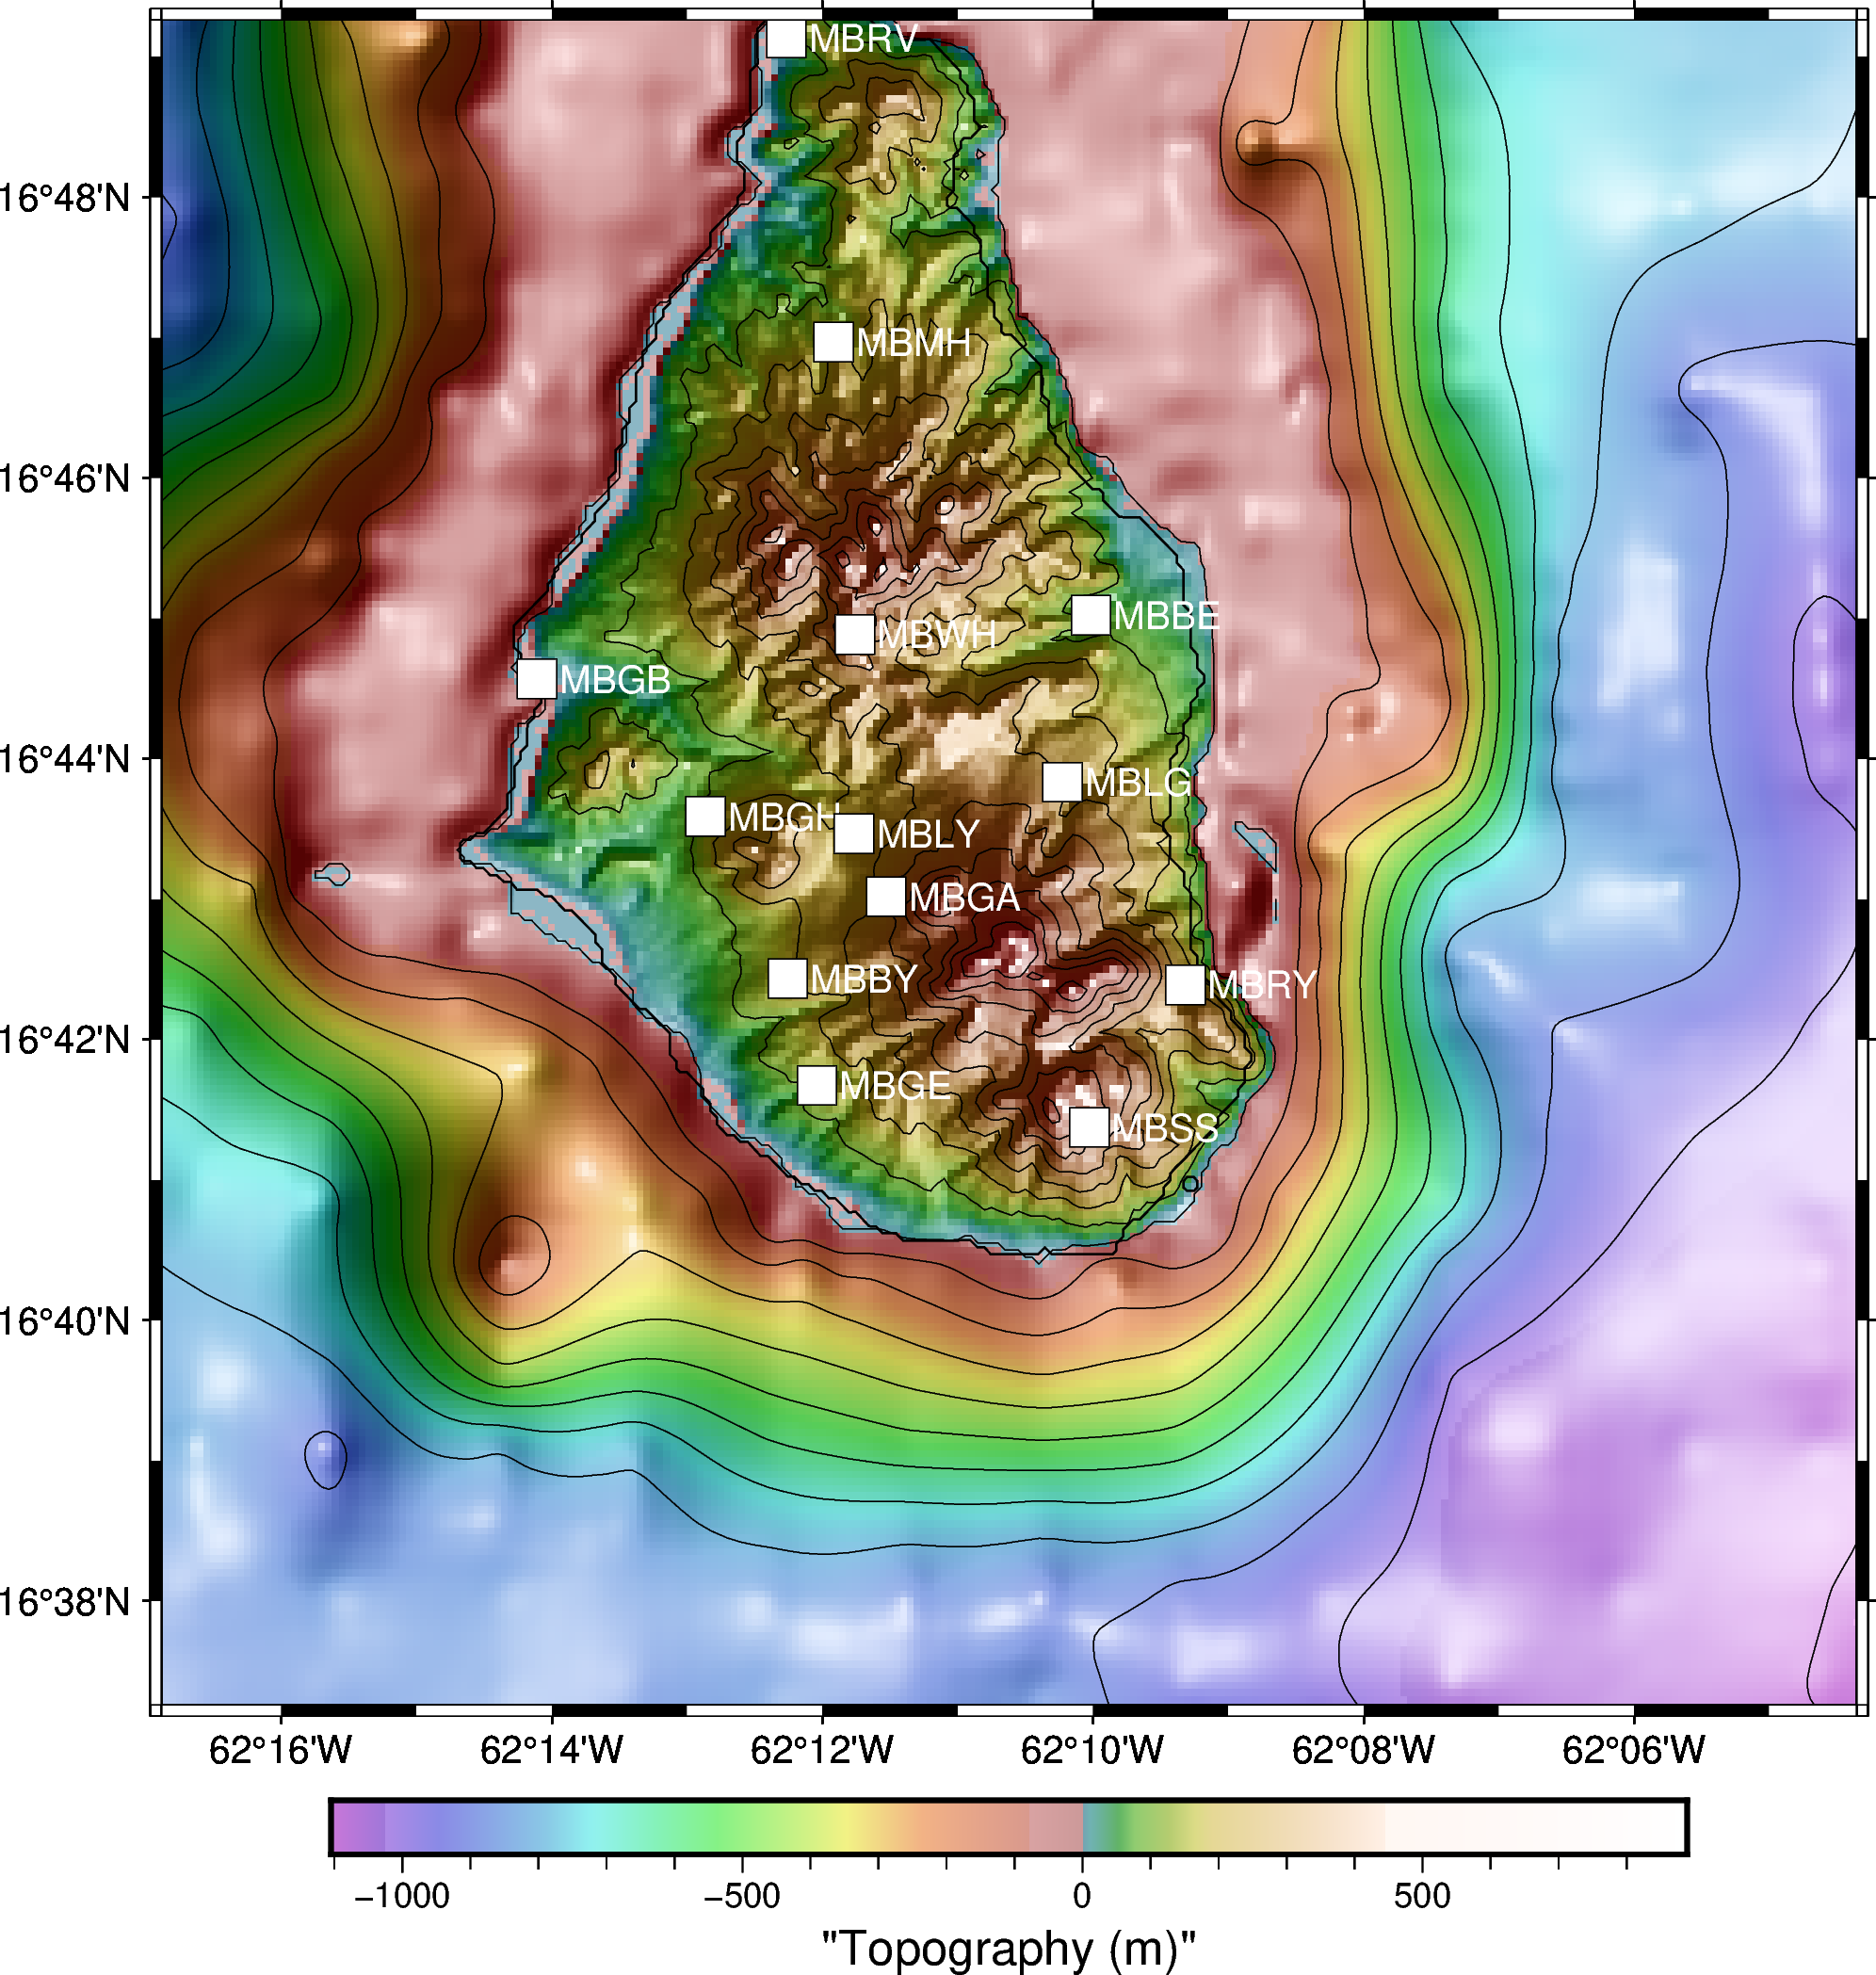

In [2]:
invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
invMVO = invMVO.select(starttime=startt, endtime=endt)
invMVO = invMVO.select(channel='*Z')
topo_map(inv=invMVO, show=True, add_labels=True, resolution='03s', DEM_DIR=DEM_DIR);

### 2.2 Define a grid of source locations and reduced displacement at those nodes

/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


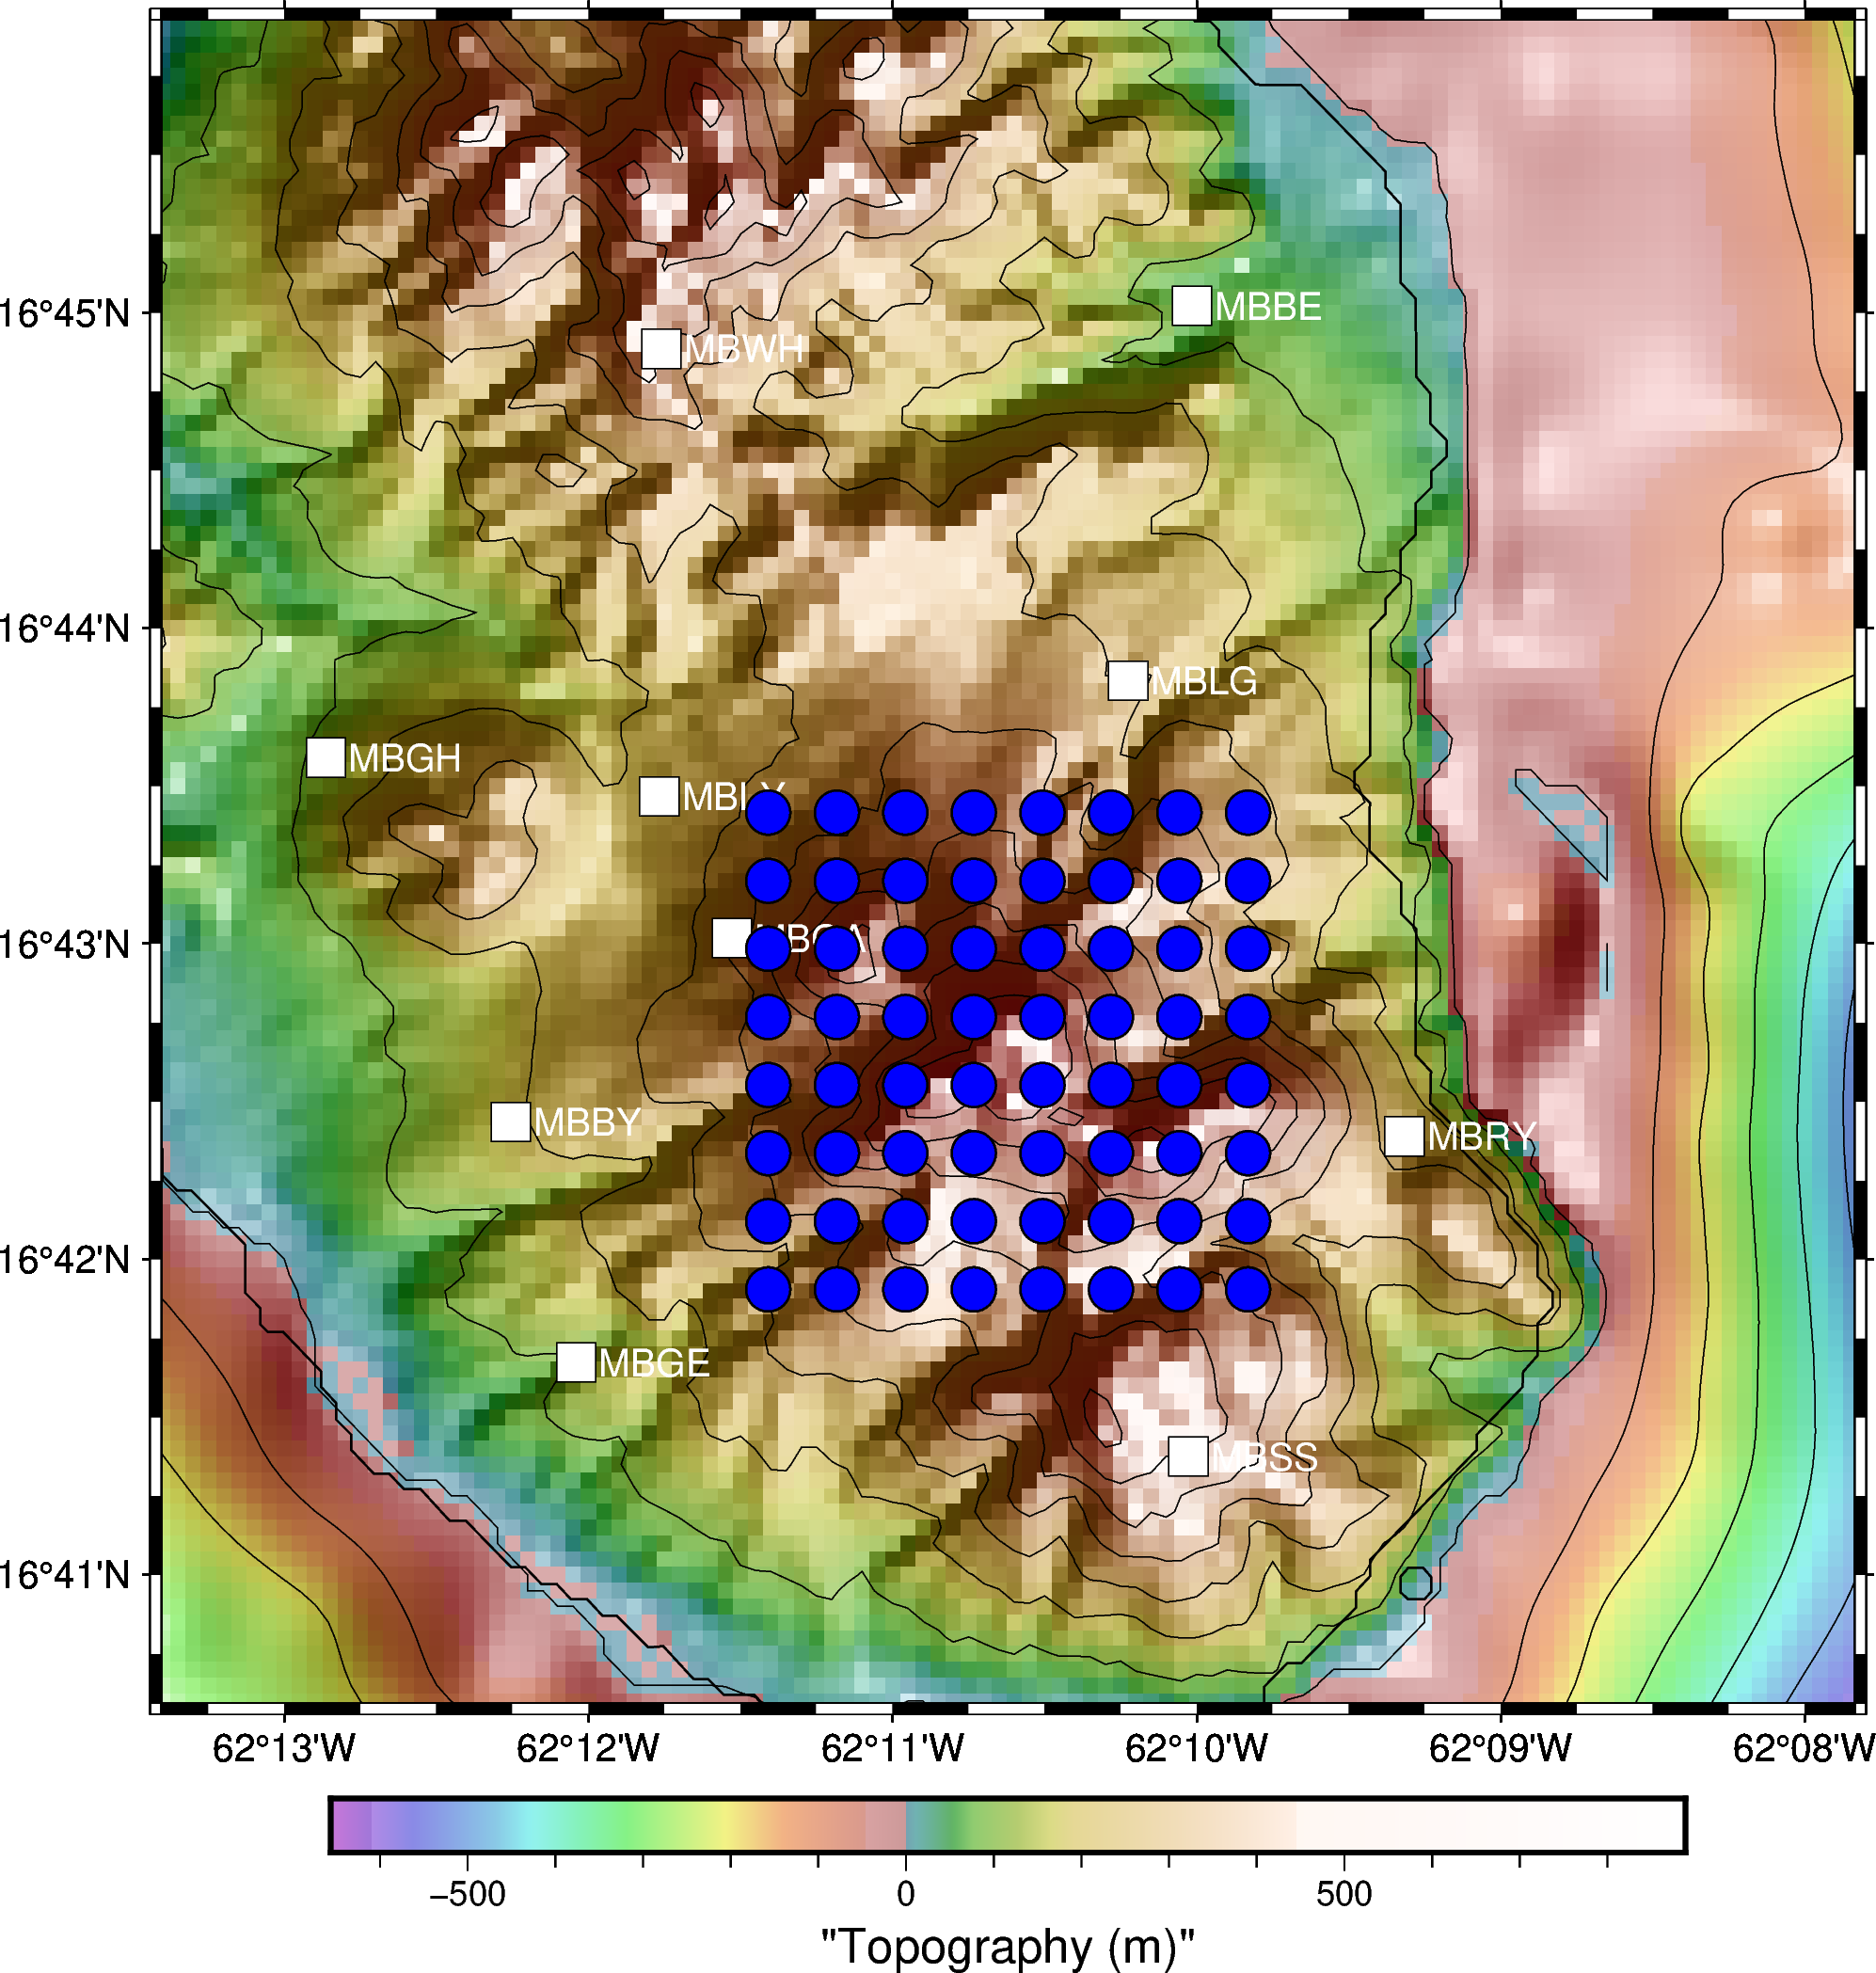

METRIC: mean


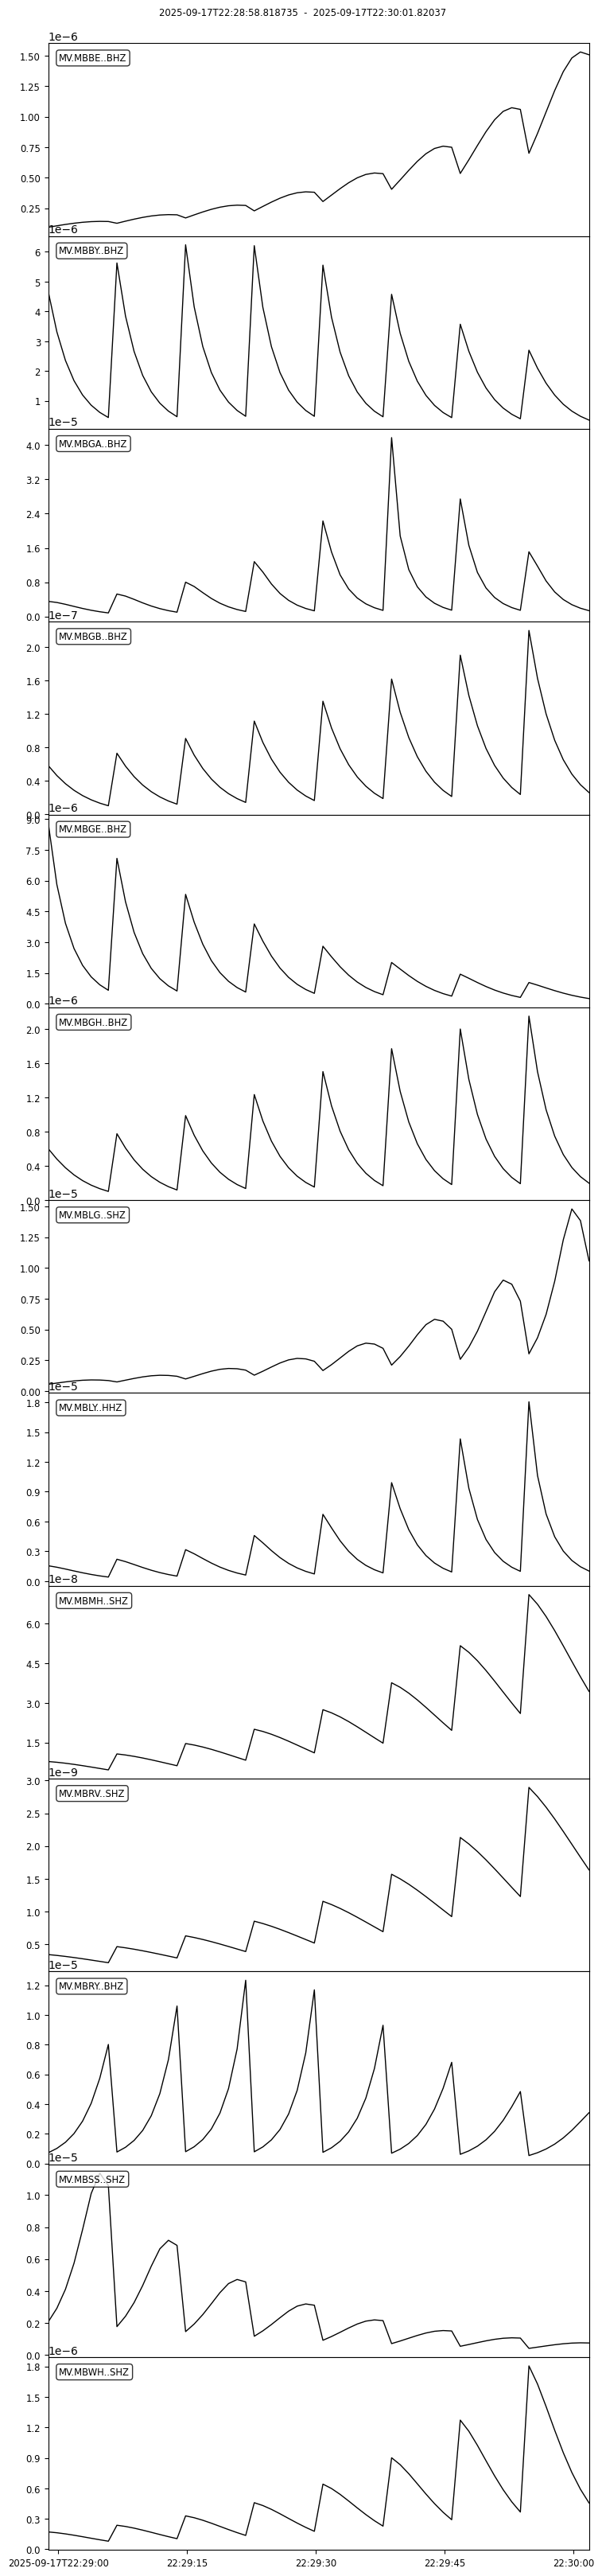

In [3]:
# params
sampling_interval = 1.0  # seconds, to simulate moving window

# grid params
node_spacing_m = 400
nlat = 8   # 11
nlon = 8   # 11
centerlat =  16.711
centerlon =  -62.177

gridobj = Grid(centerlat, centerlon, nlat, nlon, node_spacing_m)
topo_map_args = {'inv':invMVO, 'DEM_DIR':DEM_DIR, 'add_labels':True, 'zoom_level':2}
gridobj.plot(scale=2, symbol='c', topo_map_kwargs=topo_map_args)

synthetic_source = synthetic_source_from_grid(
    gridobj,
    sampling_interval=sampling_interval,
    DR_cm2=100.0,
    t0=obspy.UTCDateTime(0),
    order="C",
)

surfaceWaveSpeed_kms = 1.5
peakf = 8.0
Q = 23

synthVSAMobj = simulate_SAM(
    invMVO,
    synthetic_source,
    units='m/s',
    surfaceWaves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    peakf=peakf,
    Q=Q,
    noise_level_percent=0.0,
    verbose=True,
)
synthVSAMobj.plot(metrics="mean")

['MV.MBBE..BHZ', 'MV.MBBY..BHZ', 'MV.MBGA..BHZ', 'MV.MBGB..BHZ', 'MV.MBGE..BHZ', 'MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBLY..HHZ', 'MV.MBMH..SHZ', 'MV.MBRV..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ']


/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


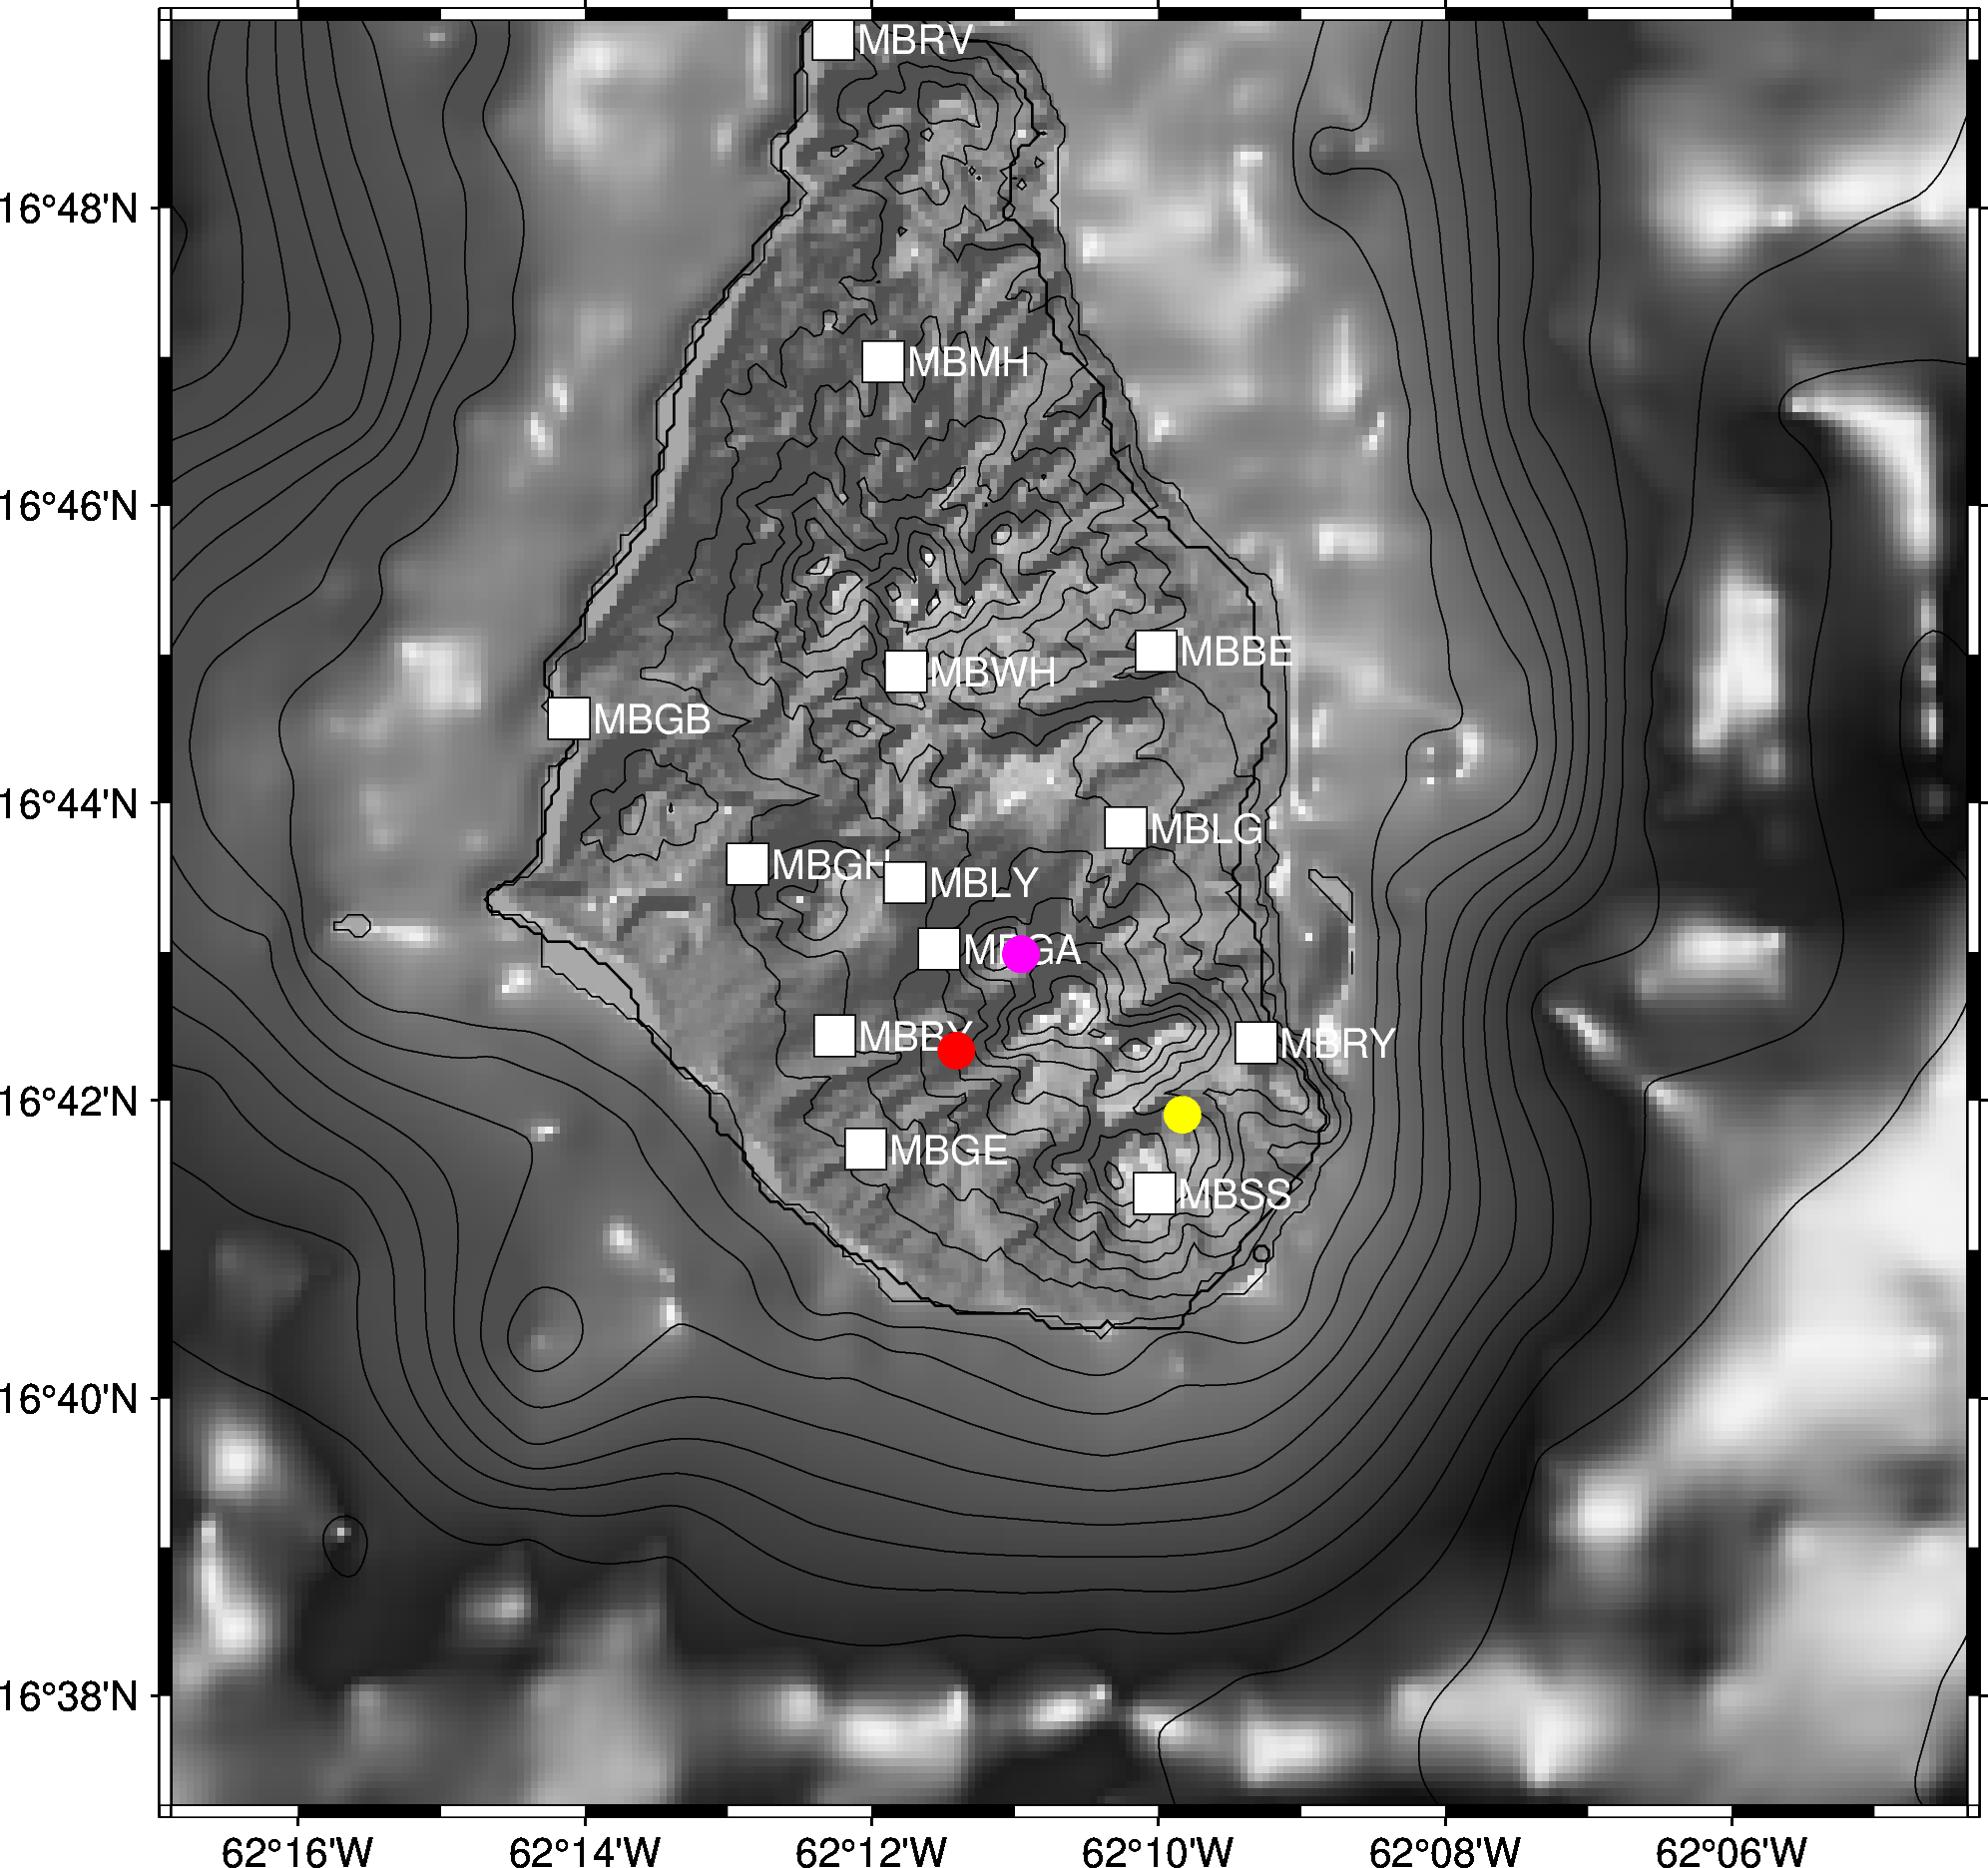

(<pygmt.figure.Figure at 0x14a622600>, array([ 7, 16, 42]))

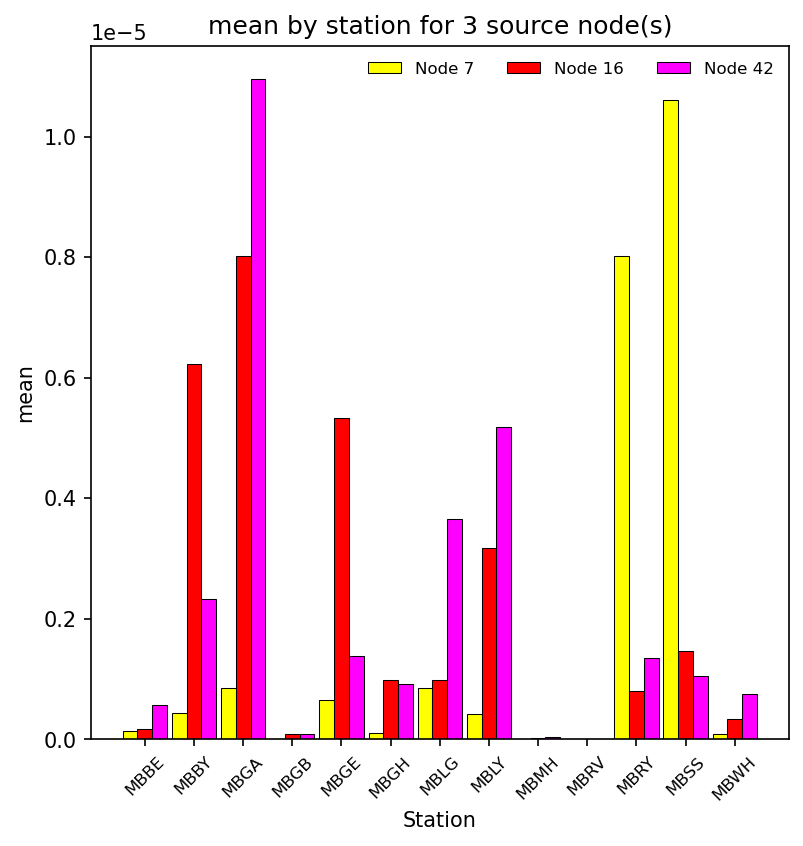

In [4]:
print(synthVSAMobj.get_seed_ids()  )
plot_SAM(synthVSAMobj, gridobj, K=3, metric='mean', DEM_DIR=DEM_DIR, inv=invMVO)

### 2.3 Plot synthetic source locations, and DR time series (all equal=100 ${cm}^2$)

/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


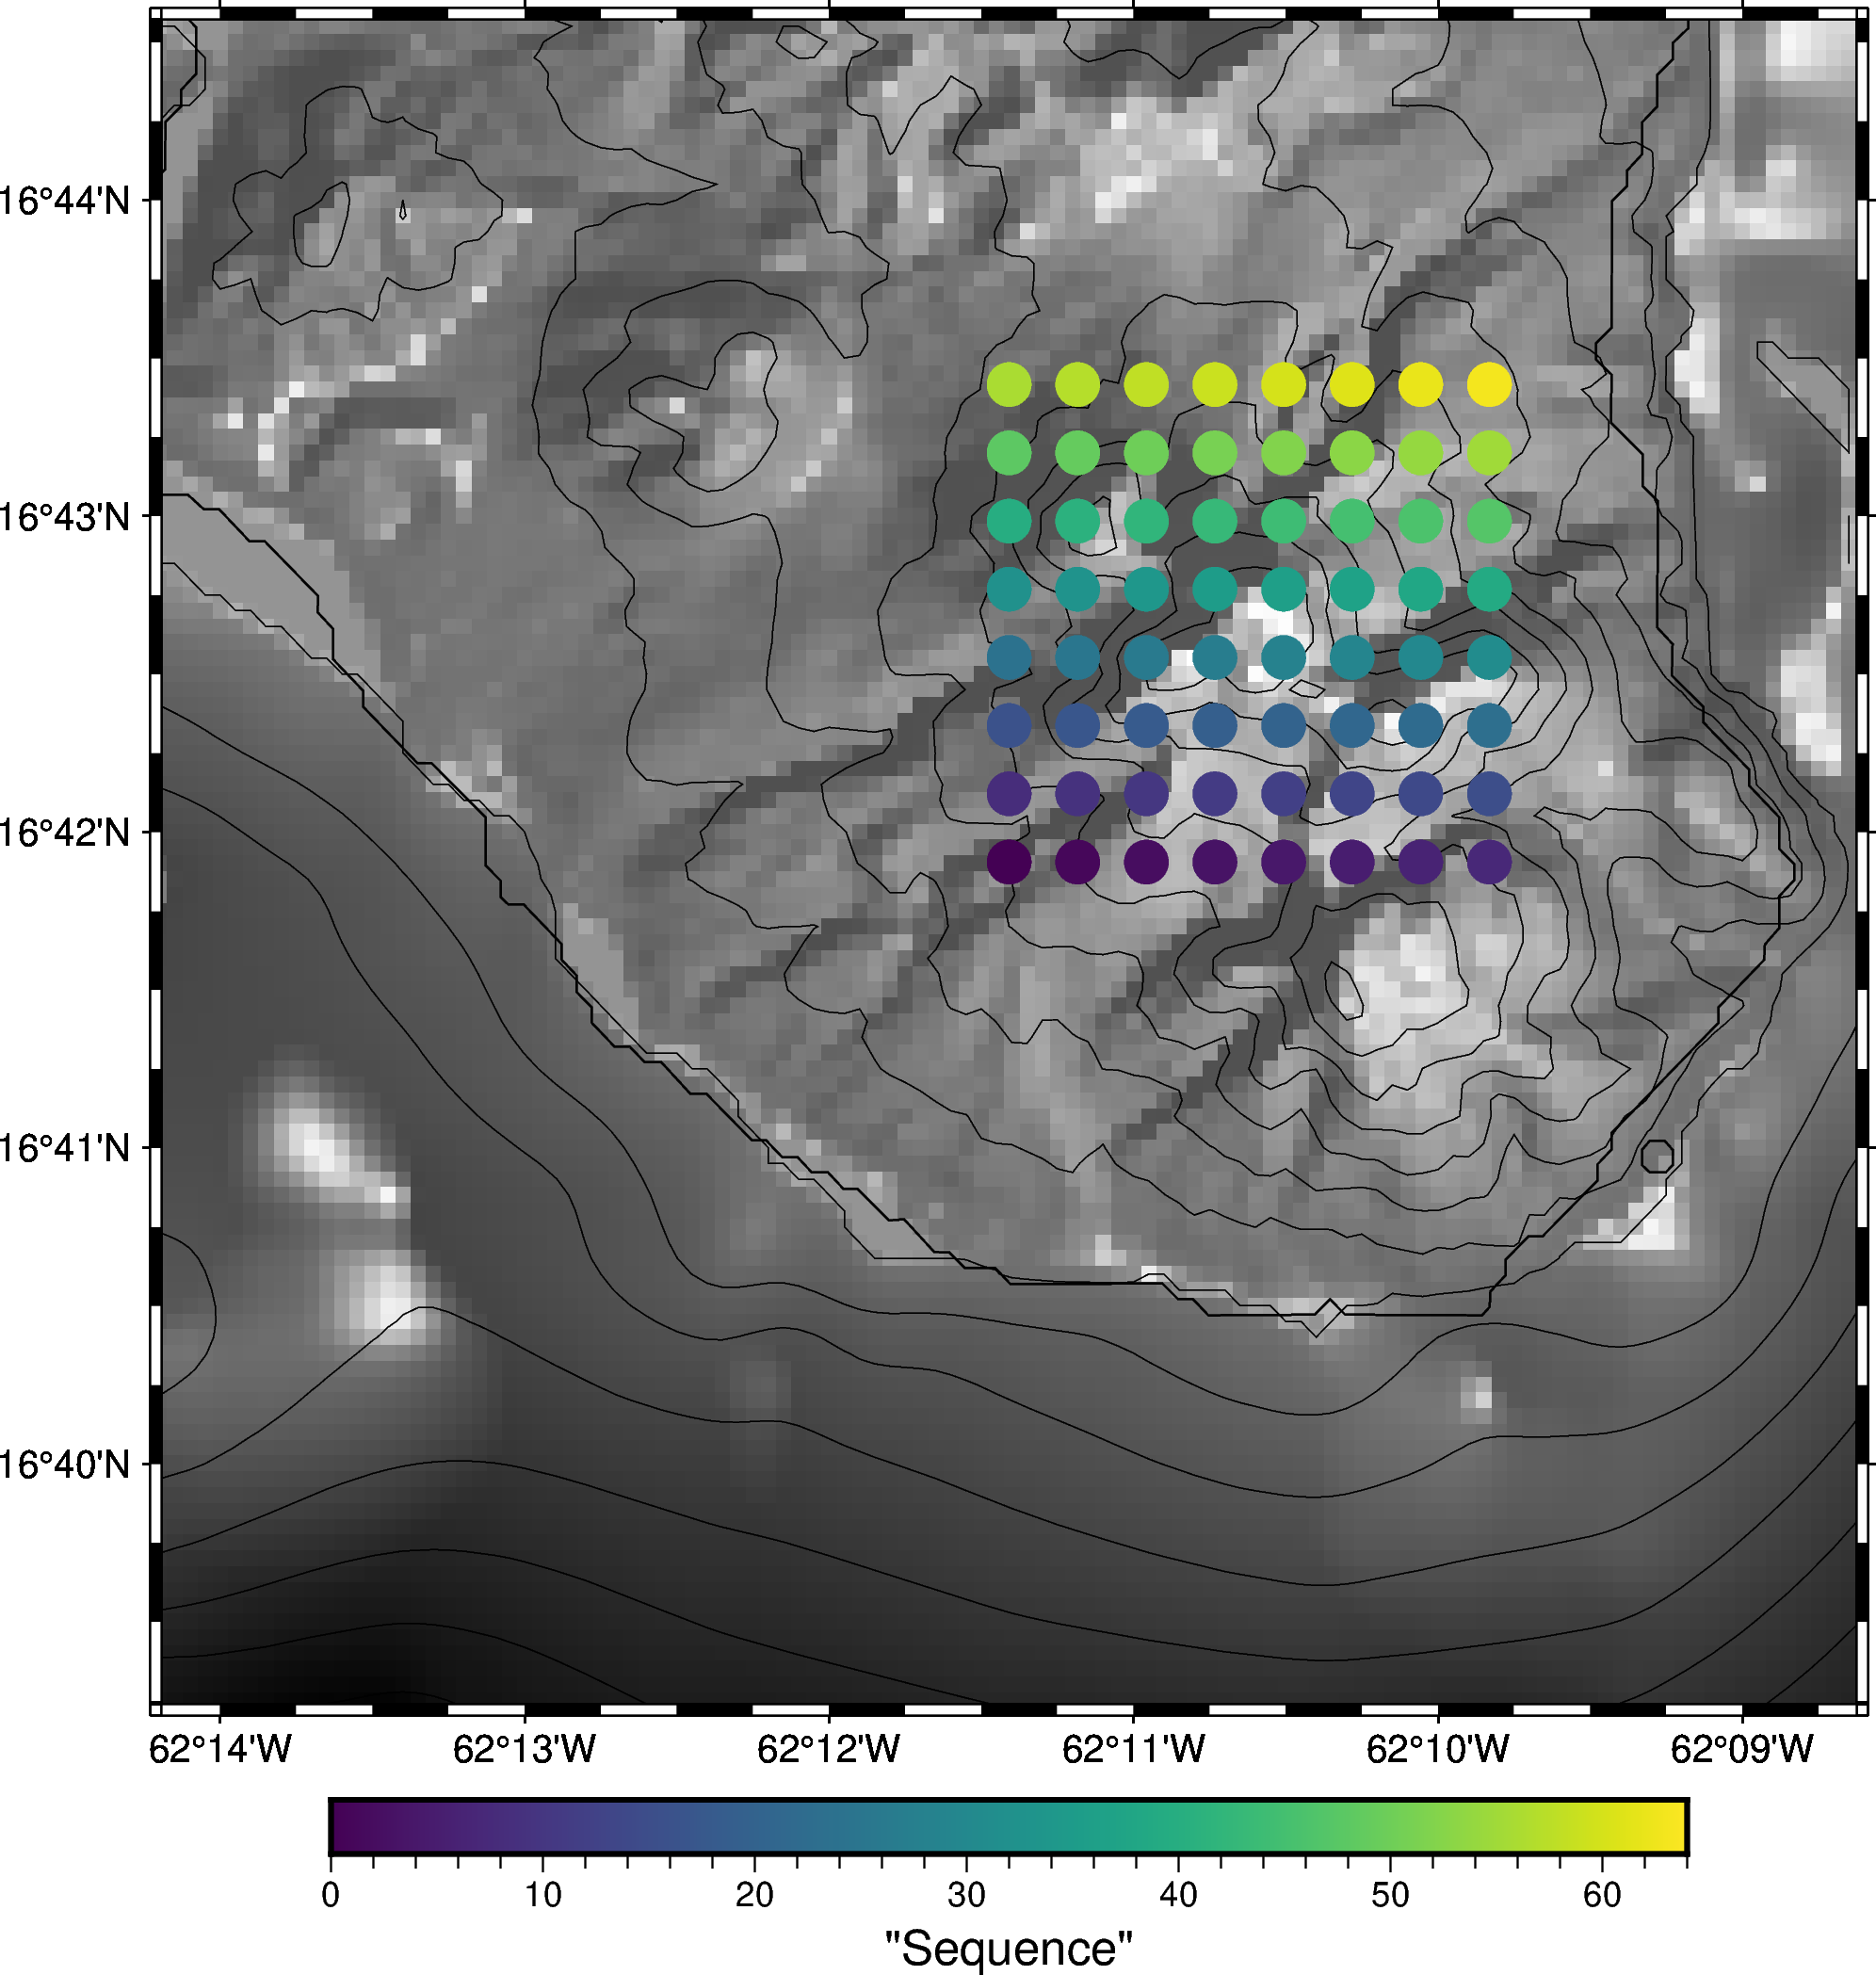

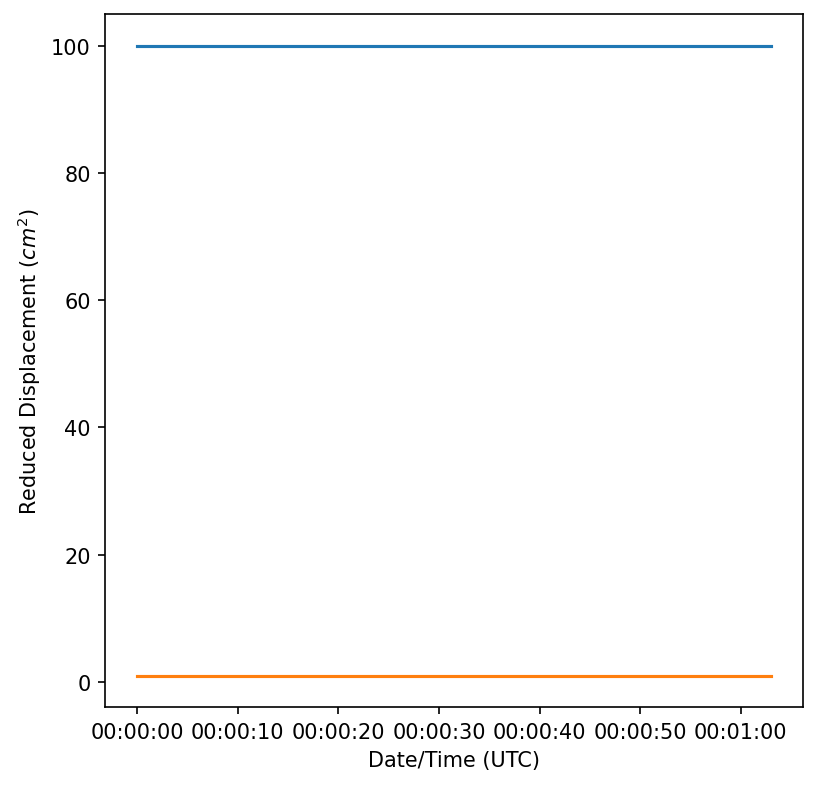

In [5]:
window_seconds = 1
aslobj = ASL(synthVSAMobj, 'mean', gridobj, window_seconds)
aslobj.source = synthetic_source
aslobj.plot(zoom_level=2, threshold_DR=1.0, scale=0.4)

### 2.4 Run slow location algorithm on synthetic source and plot resulting locations and DR time series

[ASL] Computing node→station distances…
[ASL] Distances ready for 13 channels over 64 nodes.
[ASL] Computing amplitude corrections (surface_waves=True, v=1.5 km/s, Q=23, peakf=8.0 Hz)…
[ASL] Amplitude corrections ready for 13 channels.
[ASL] locate (slow): preparing data…
[ASL] locate (slow): nsta=13, ntime=64, spatial_blur=off, temporal_smooth_win=0
[ASL] connectedness: score=0.421  n_used=12  mean_km=1.38  p90_km=2.43
[ASL] locate (slow): done.
[TIMER] Location algorithm took 0.067 s


/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


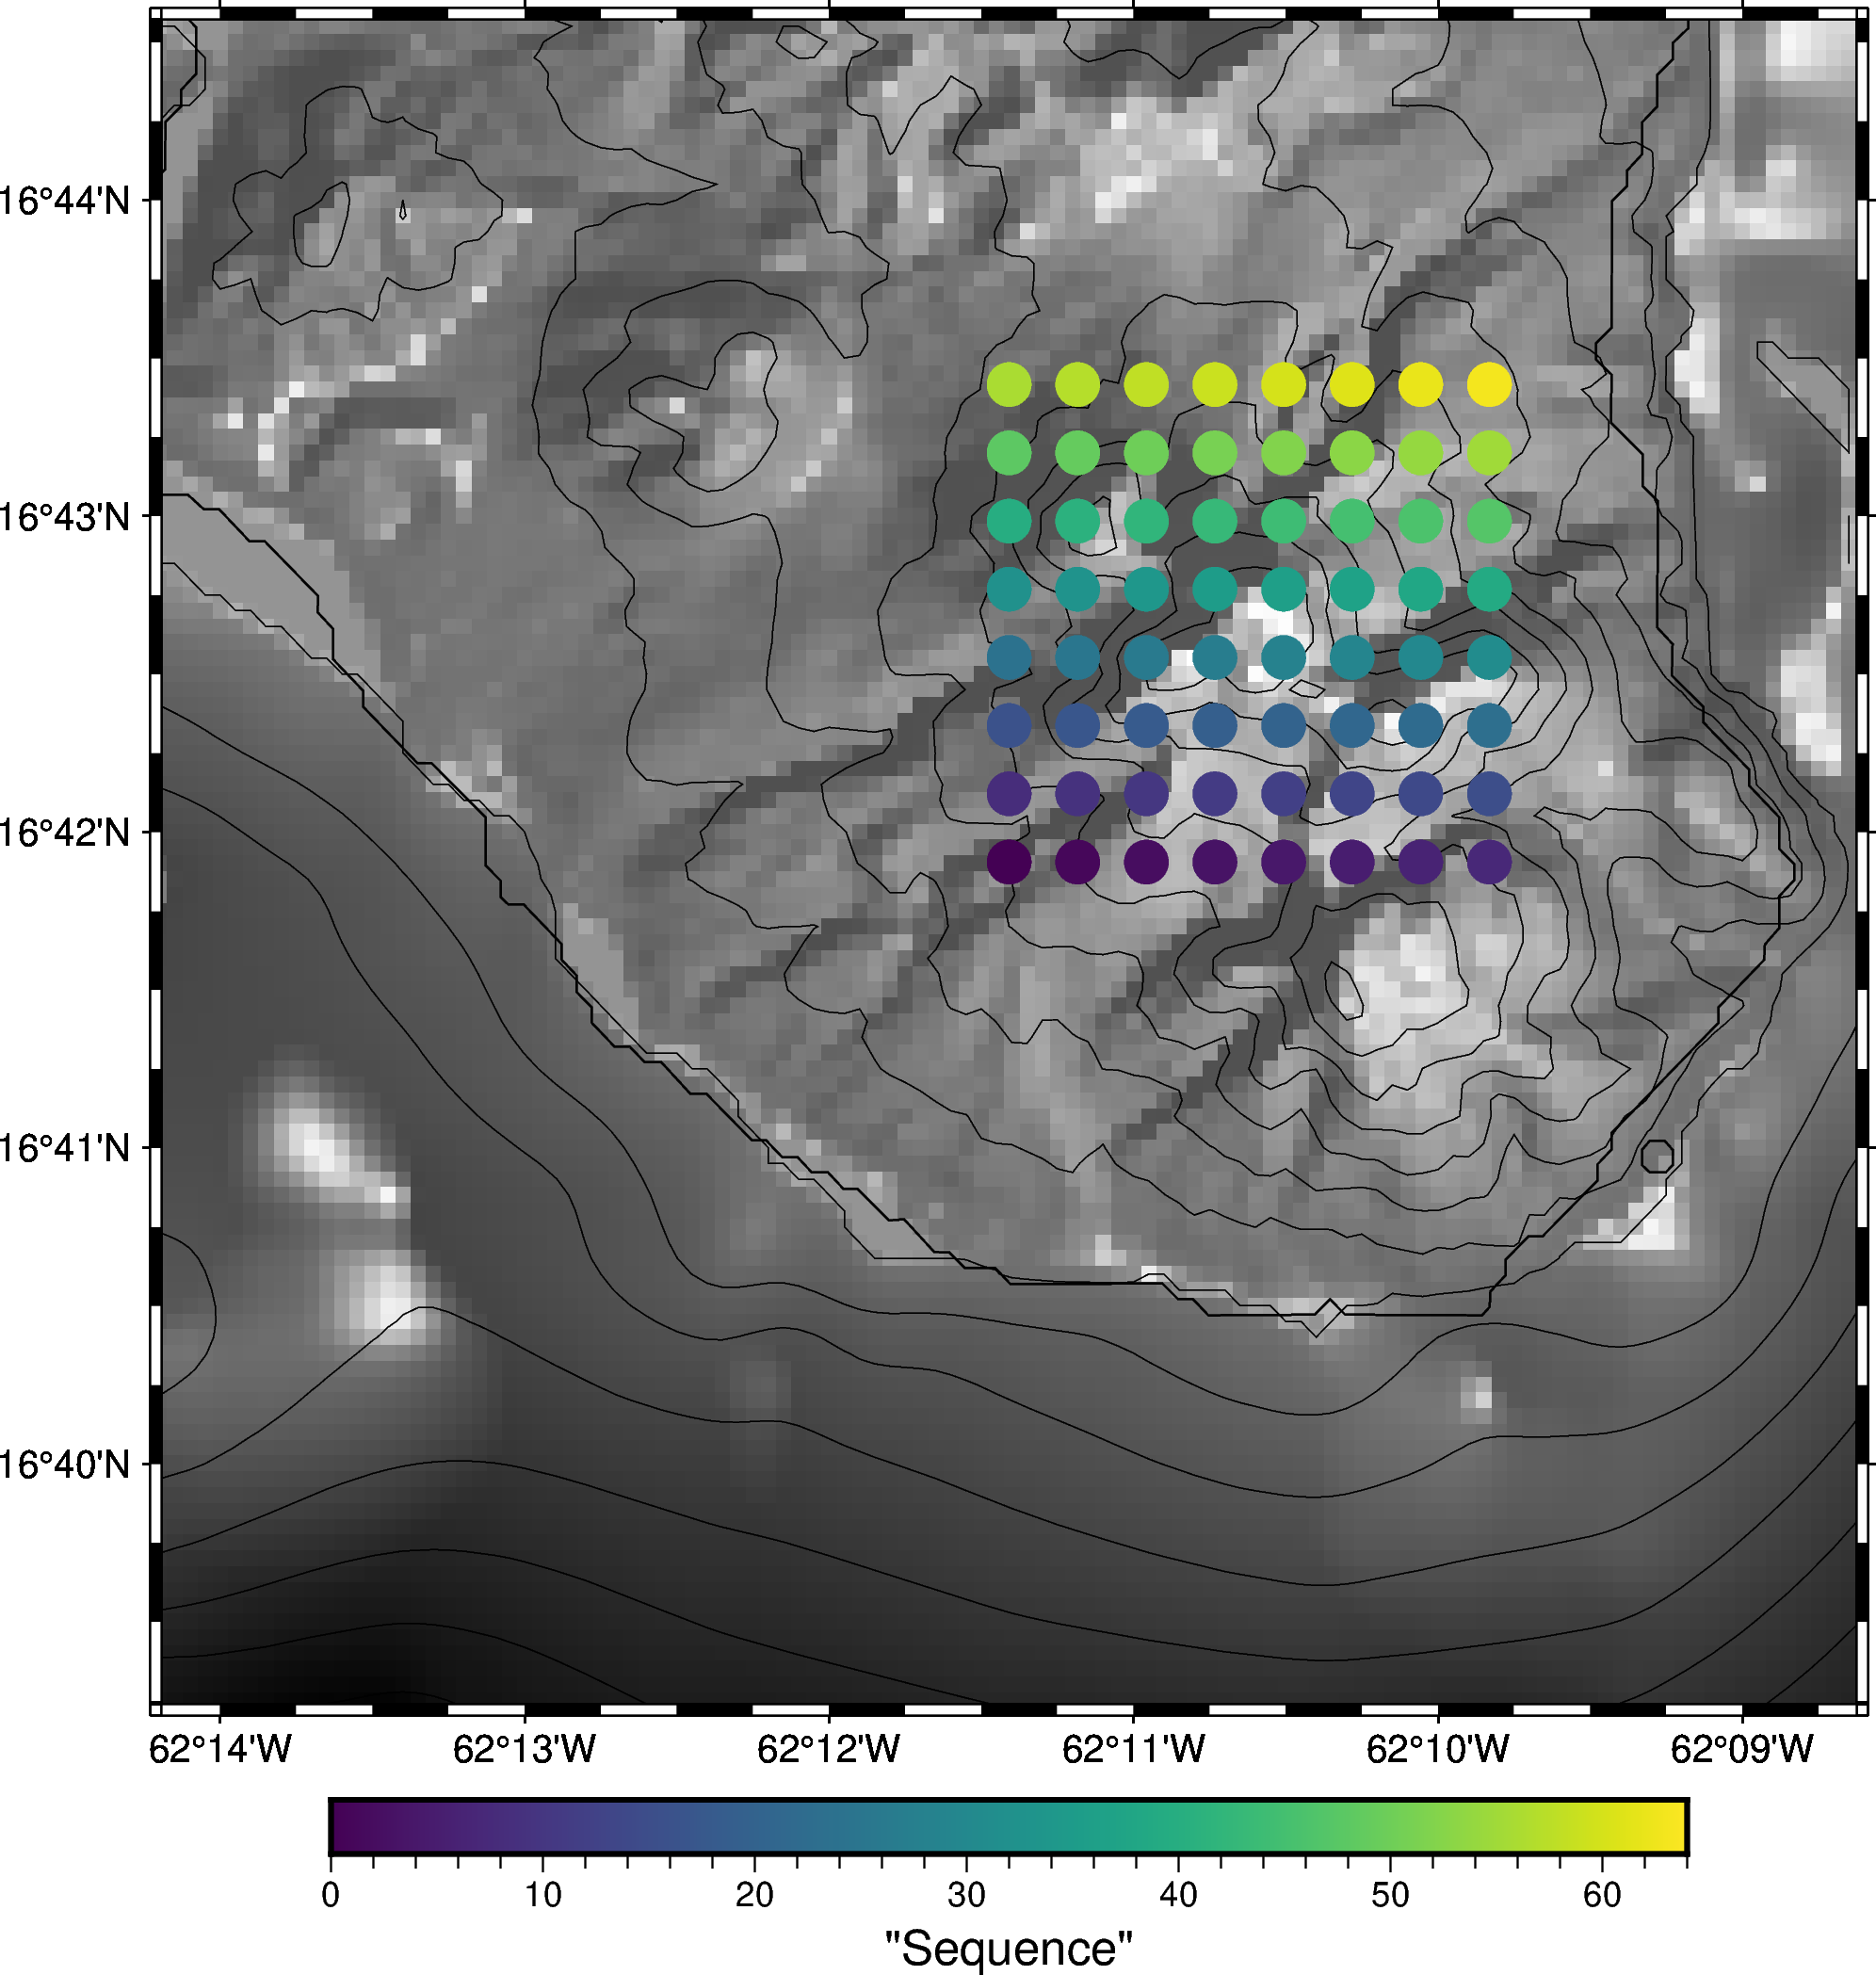

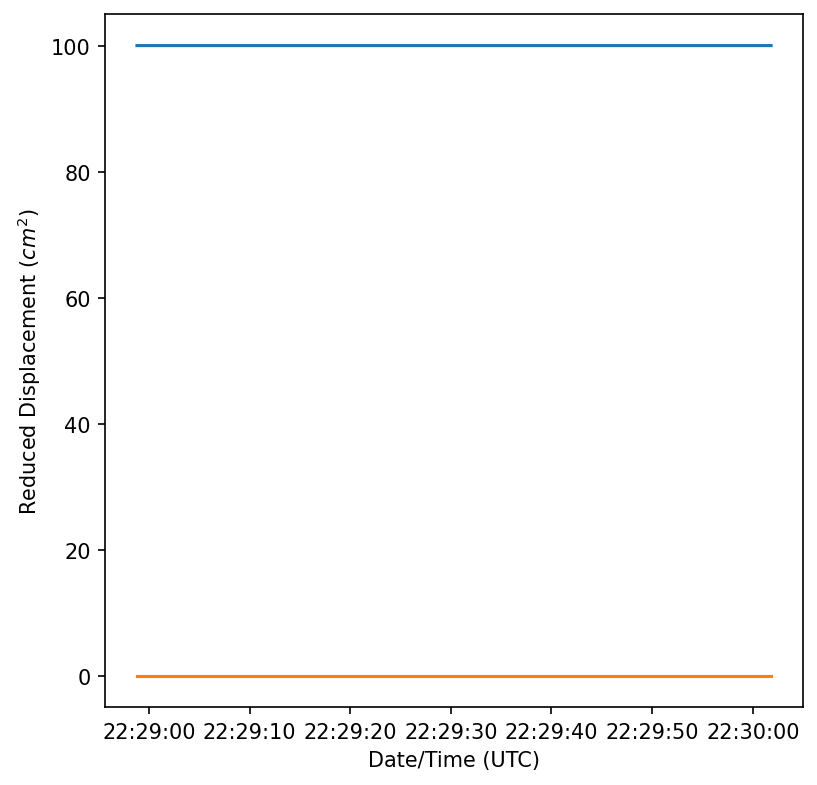

In [6]:

# 1) Distances (no cache)
aslobj.compute_grid_distances(inventory=invMVO, stream=None)

# 2) Amplitude corrections (no cache)
aslobj.compute_amplitude_corrections(
    surface_waves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    Q=Q,
    peakf=peakf,
    dtype="float32",
)

# 3) Locate & time
t0 = time.time()
aslobj.locate(verbose=True)
t1 = time.time()
print(f"[TIMER] Location algorithm took {t1 - t0:.3f} s")

# 4) Plot
aslobj.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)

### 2.5 Run fast location algorithm on synthetic source and plot resulting locations and DR time series

[ASL] fast_locate: preparing data…
[ASL] fast_locate: nsta=13, ntime=64, batch=1024, spatial_blur=off, temporal_smooth_win=0
[ASL] fast_locate: [0:64)
[ASL] connectedness: score=0.405  n_used=12  mean_km=1.47  p90_km=2.37
[ASL] fast_locate: done.
Vectorized location algorithm took 0.02043294906616211 s


/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


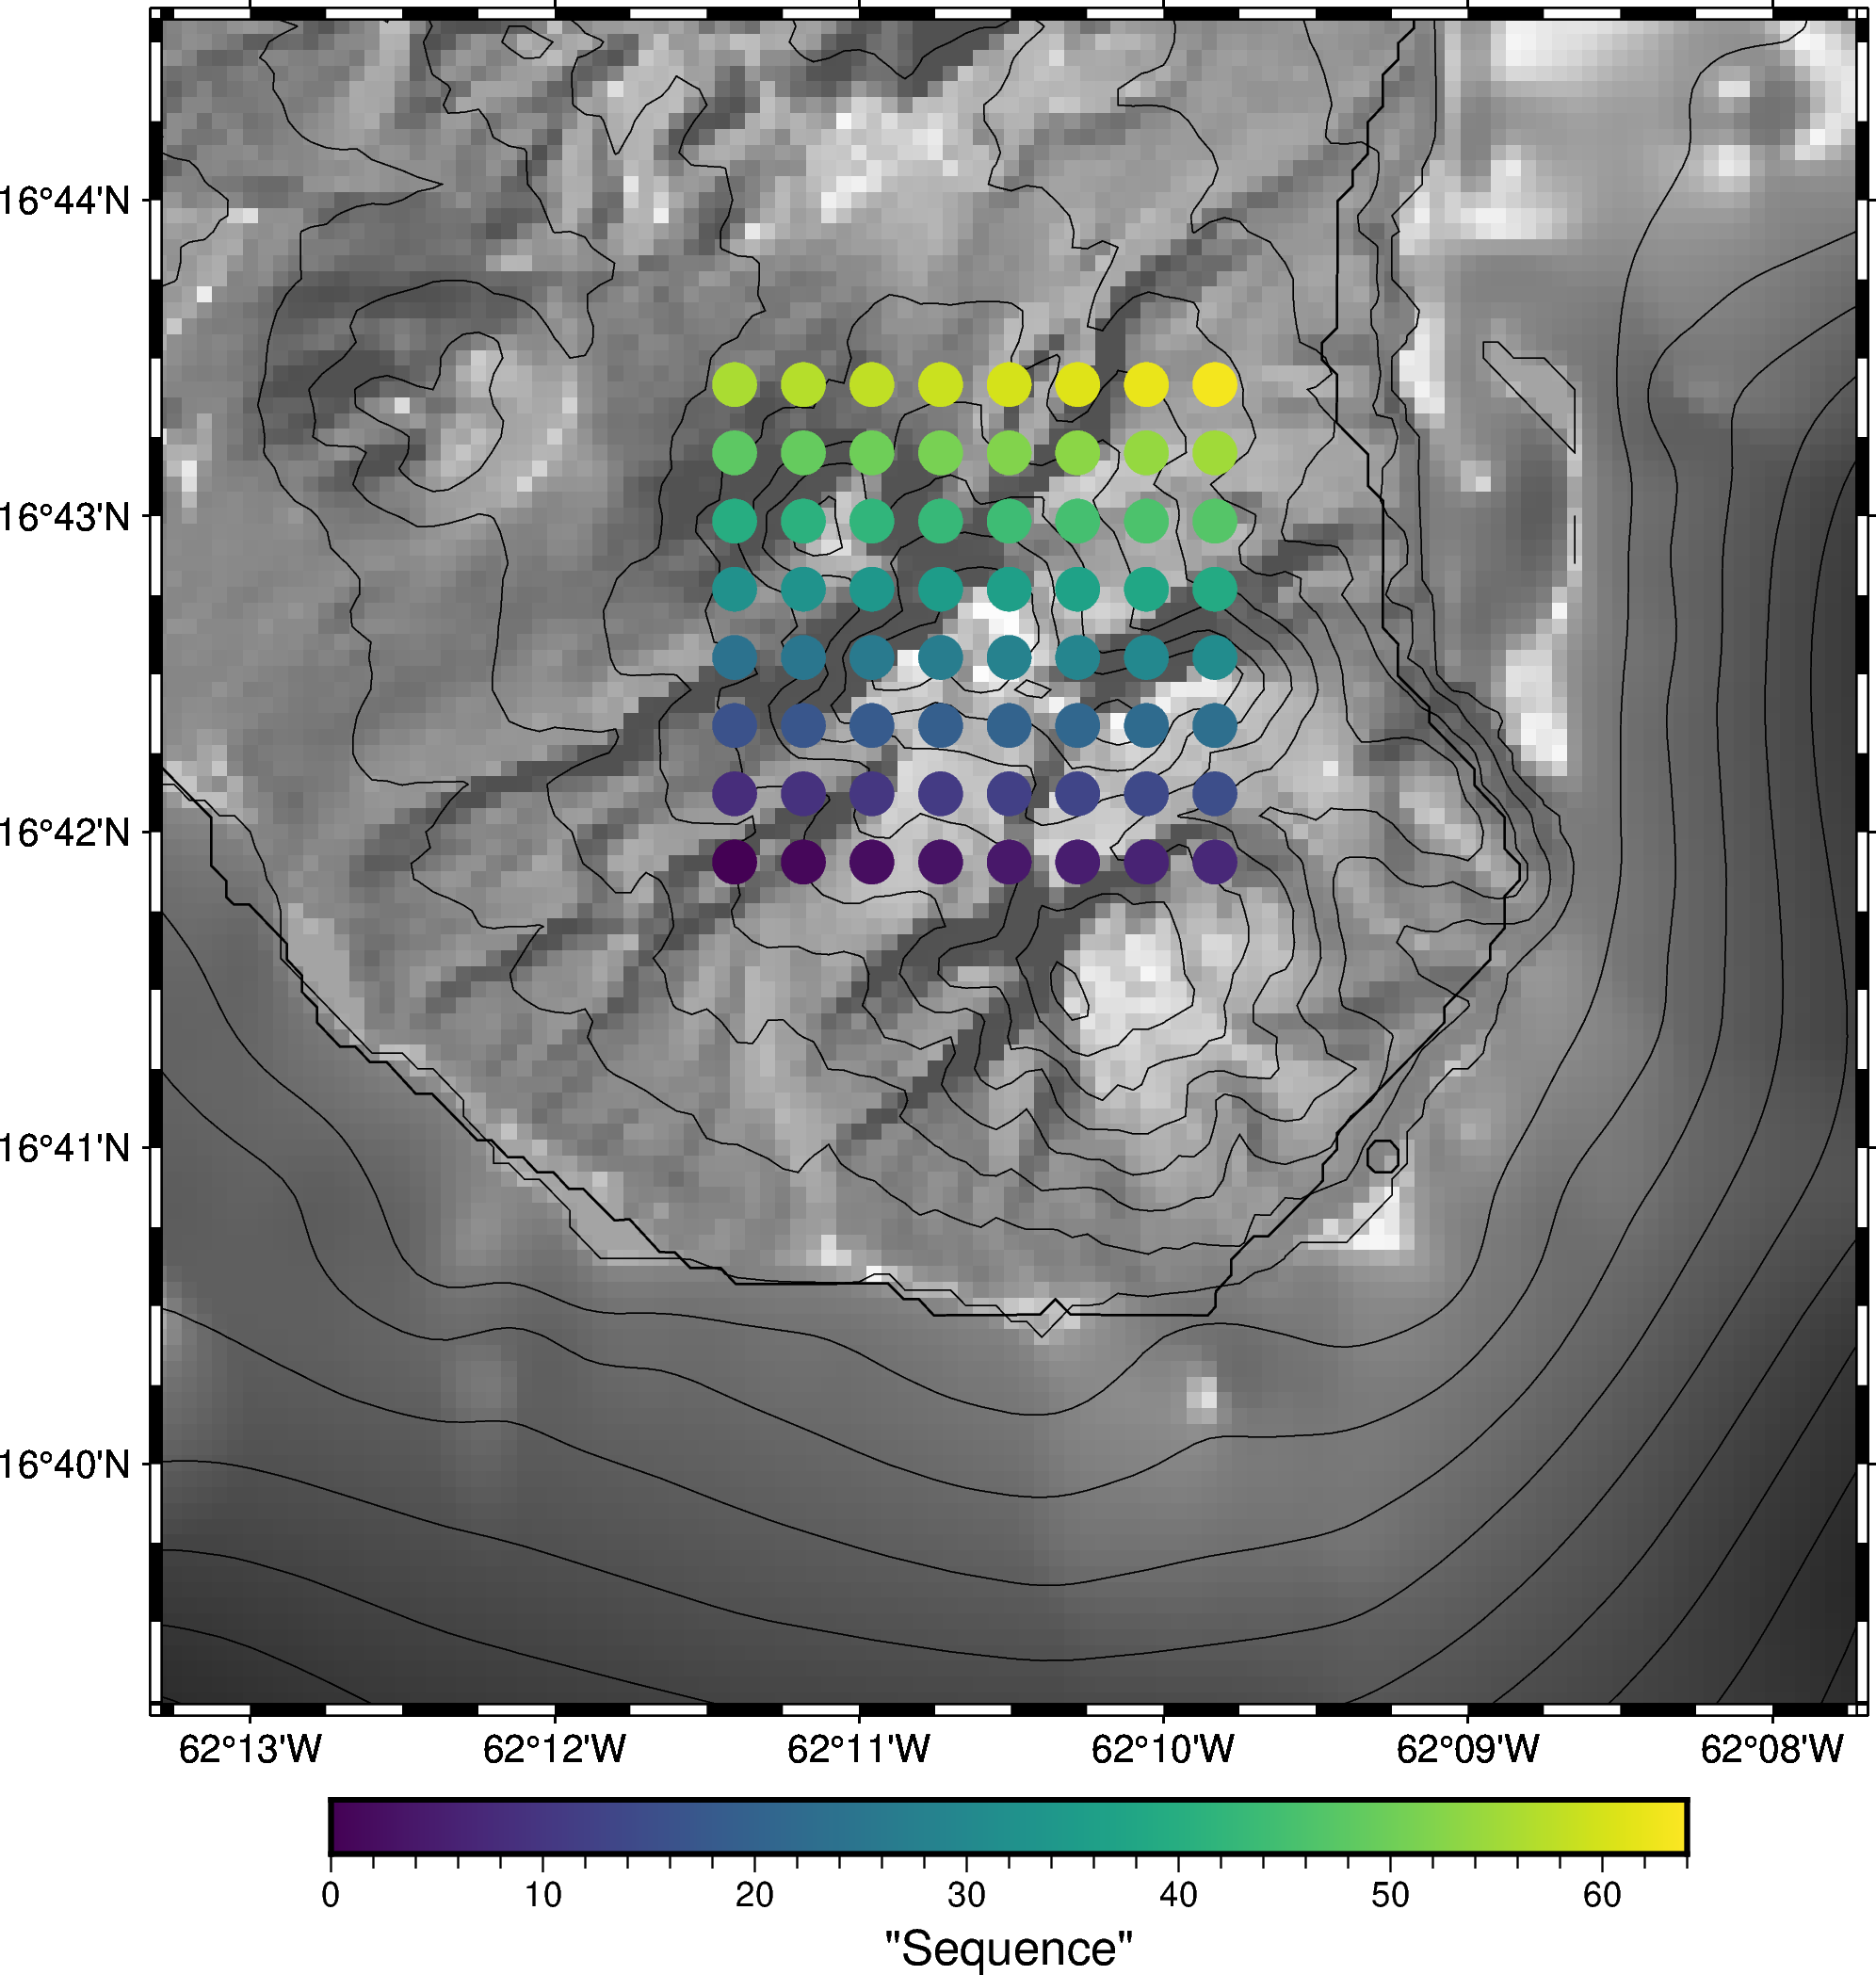

{'key_mismatch': {'only_in_1': set(), 'only_in_2': {'node_index'}}}

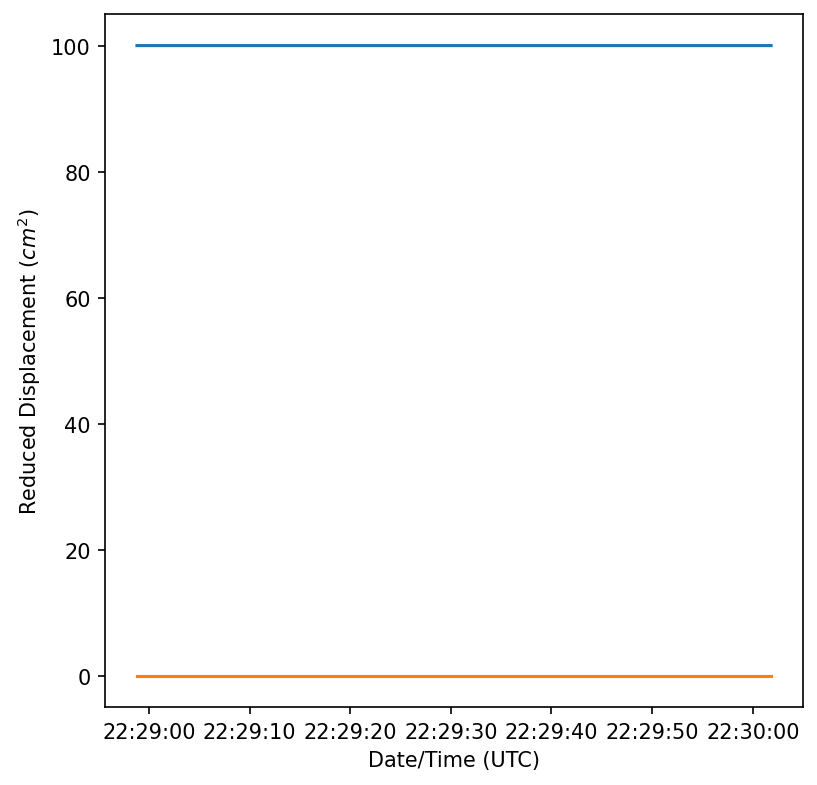

In [7]:
import copy
aslobj2 = copy.deepcopy(aslobj)
aslobj2.source = None
time1 = time.time()
aslobj2.fast_locate(misfit_backend=StdOverMeanMisfit())
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj2.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)

# Compare results. Any differences?
compare_asl_sources(aslobj, aslobj2)

[ASL] fast_locate: preparing data…
[ASL] fast_locate: nsta=13, ntime=64, batch=1024, spatial_blur=off, temporal_smooth_win=0
[ASL] fast_locate: [0:64)
[ASL] connectedness: score=0.421  n_used=12  mean_km=1.38  p90_km=2.43
[ASL] fast_locate: done.
                          t       lat        lon         DR   misfit      azgap  nsta  node_index  connectedness
2025-09-17T22:28:58.818735Z 16.698409 -62.190146 100.000011 0.000263 137.512470    13           0       0.420803
2025-09-17T22:28:59.818738Z 16.698409 -62.186390 100.000011 0.000263 138.948632    13           1       0.420803
2025-09-17T22:29:00.818741Z 16.698409 -62.182634 100.000011 0.000372 136.962382    13           2       0.420803
2025-09-17T22:29:01.818744Z 16.698409 -62.178878 100.000011 0.000372 131.712213    13           3       0.420803
2025-09-17T22:29:02.818747Z 16.698409 -62.175122 100.000011 0.000000 122.285746    13           4       0.420803
2025-09-17T22:29:03.818749Z 16.698409 -62.171366 100.000011 0.000000 107.15

/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


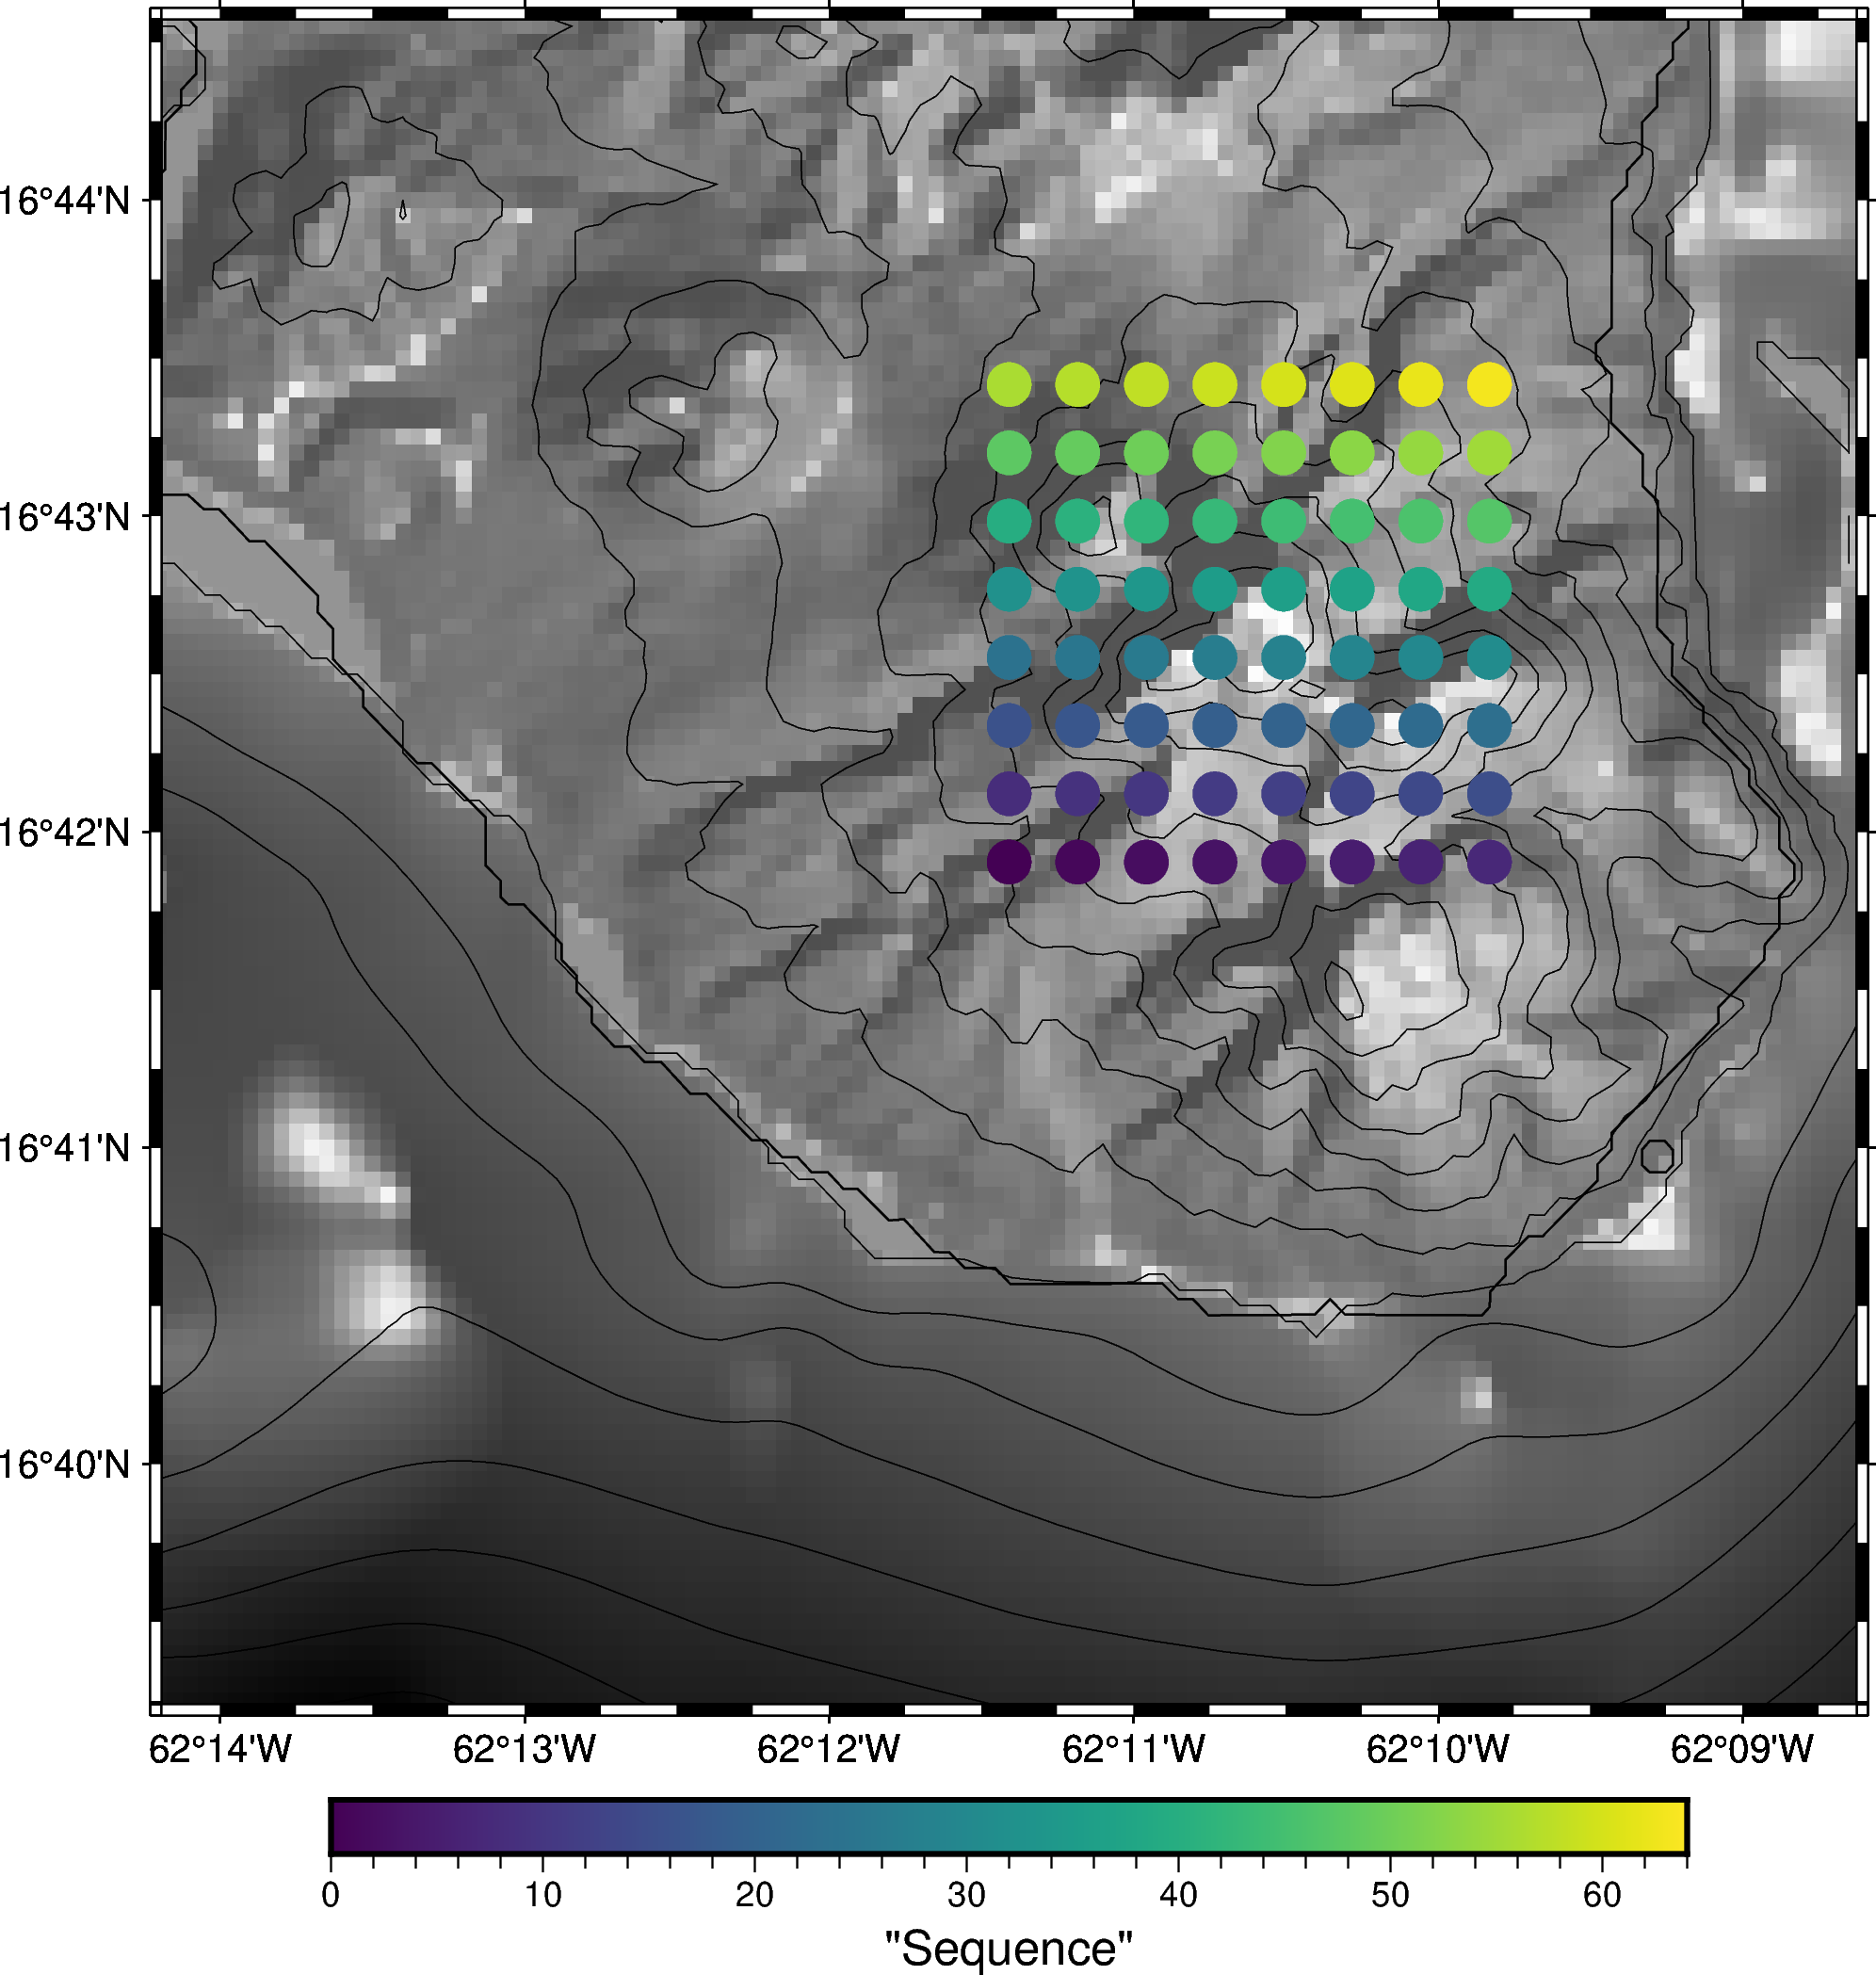

{'connectedness': 'Numeric mismatch (not allclose)'}


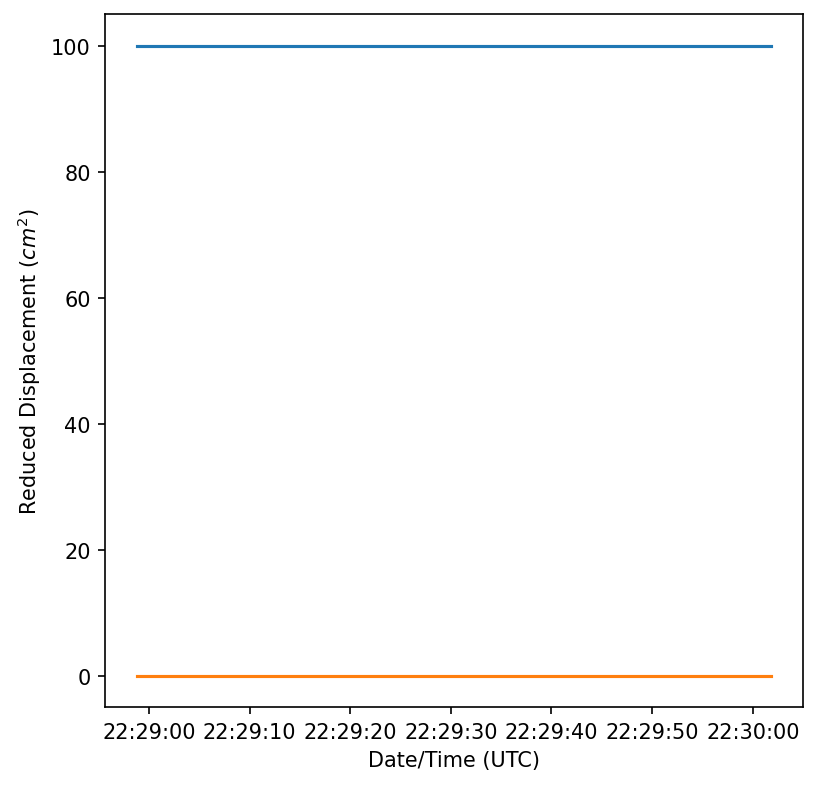

In [8]:
aslobj3 = copy.deepcopy(aslobj)
aslobj3.source = None
time1 = time.time()
# pure correlation (most aggressive)
aslobj3.fast_locate(misfit_backend=R2DistanceMisfit(use_log=True, square=True, alpha=0.0))
time2 = time.time()
aslobj3.print_source()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj3.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)
print(compare_asl_sources(aslobj2, aslobj3))

[ASL] fast_locate: preparing data…
[ASL] fast_locate: nsta=13, ntime=64, batch=1024, spatial_blur=off, temporal_smooth_win=0
[ASL] fast_locate: [0:64)
[ASL] connectedness: score=0.421  n_used=12  mean_km=1.38  p90_km=2.43
[ASL] fast_locate: done.
                          t       lat        lon         DR   misfit      azgap  nsta  node_index  connectedness
2025-09-17T22:28:58.818735Z 16.698409 -62.190146 100.000011 0.047534 137.512470    13           0       0.420803
2025-09-17T22:28:59.818738Z 16.698409 -62.186390 100.000011 0.036781 138.948632    13           1       0.420803
2025-09-17T22:29:00.818741Z 16.698409 -62.182634 100.000011 0.032148 136.962382    13           2       0.420803
2025-09-17T22:29:01.818744Z 16.698409 -62.178878 100.000011 0.034694 131.712213    13           3       0.420803
2025-09-17T22:29:02.818747Z 16.698409 -62.175122 100.000011 0.043317 122.285746    13           4       0.420803
2025-09-17T22:29:03.818749Z 16.698409 -62.171366 100.000011 0.054216 107.15

/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


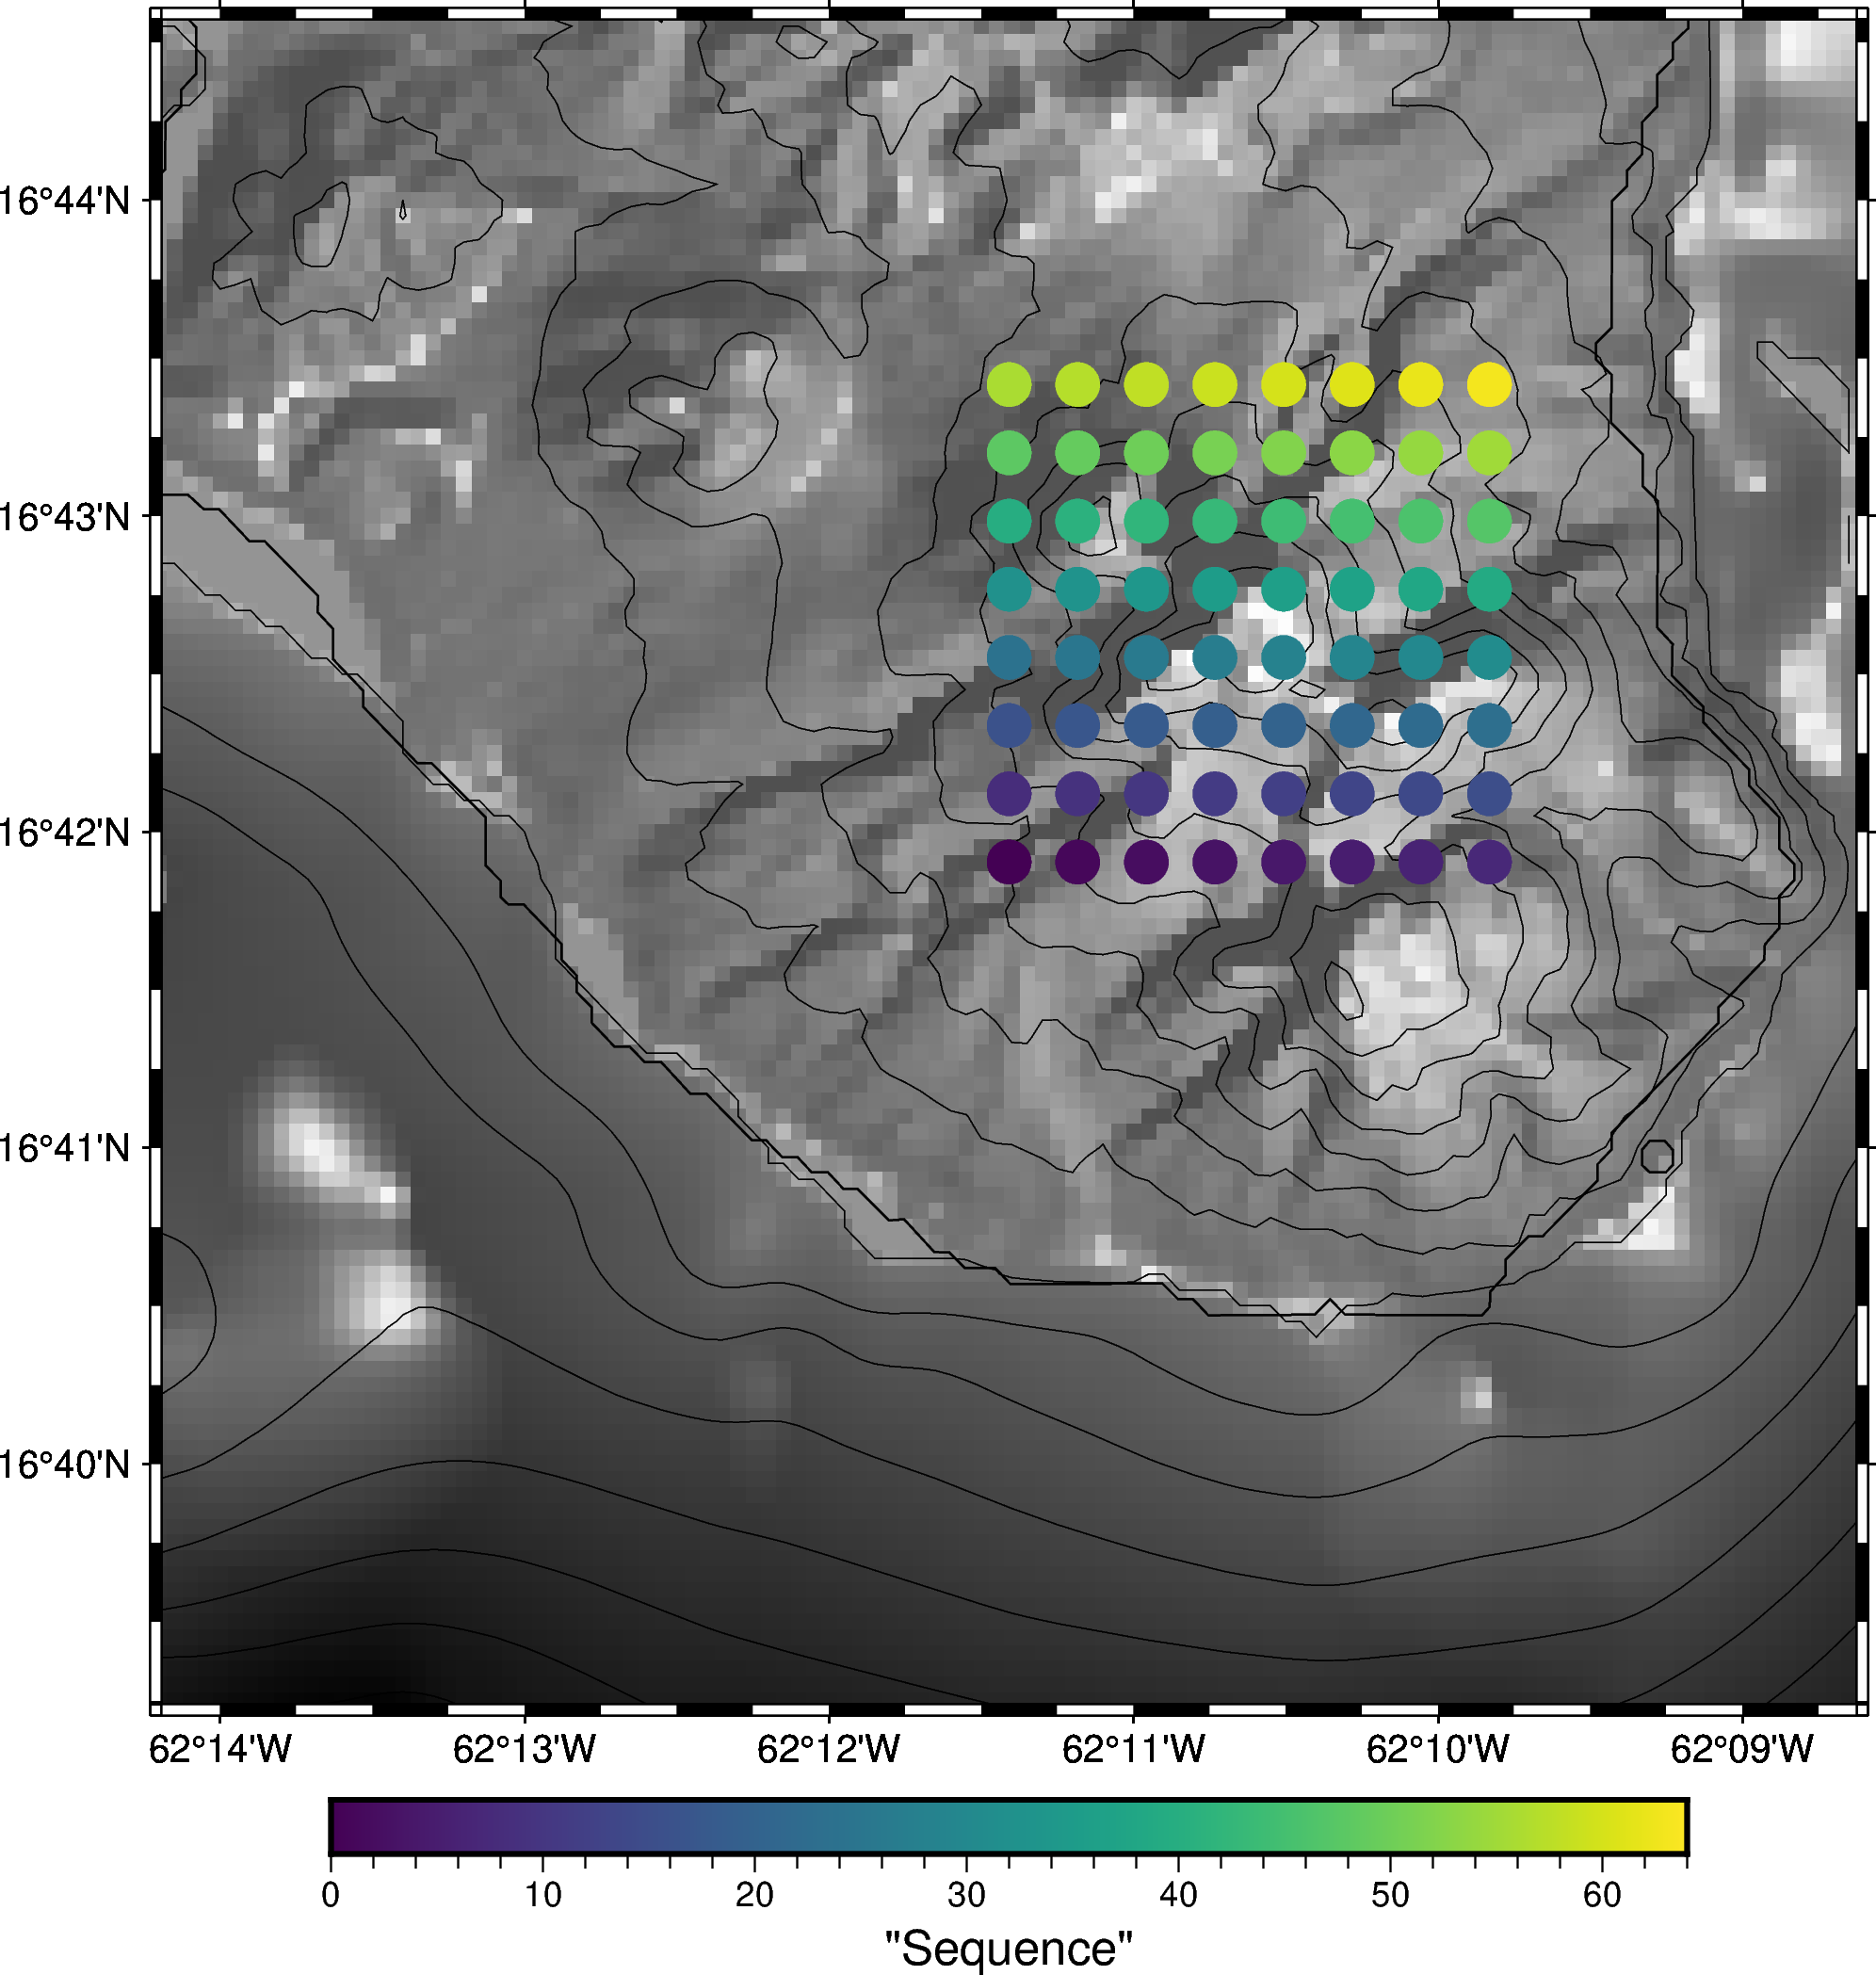

{'misfit': 'Numeric mismatch (not allclose)'}


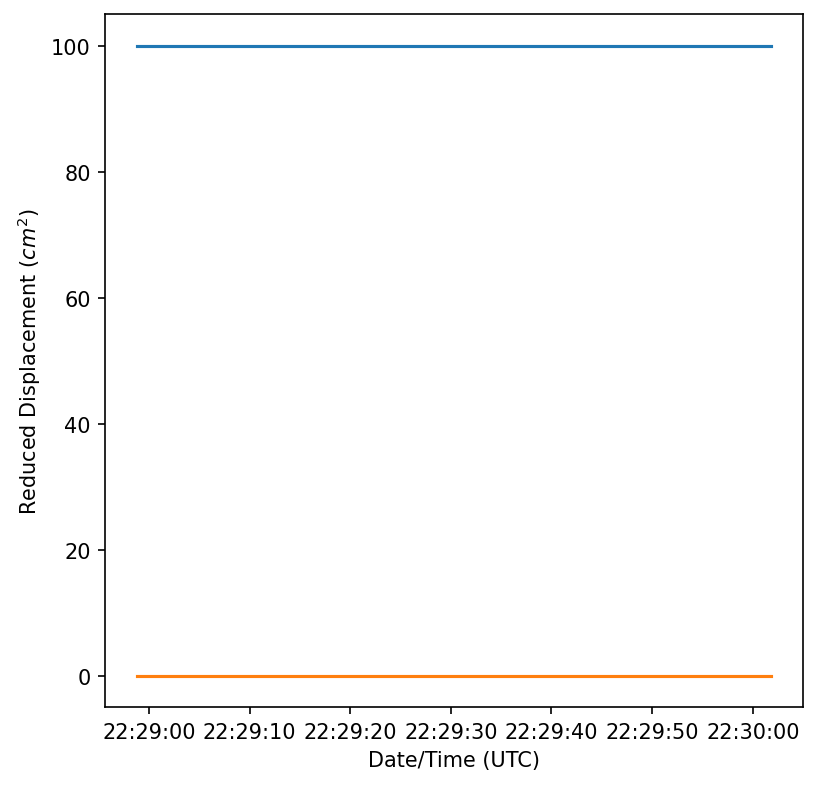

In [ ]:
# blended (often more stable in practice)
aslobj4 = copy.deepcopy(aslobj)
aslobj4.source = None
time1 = time.time()
aslobj4.fast_locate(misfit_backend=R2DistanceMisfit(use_log=True, square=True, alpha=1.0))
aslobj4.print_source()
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj4.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)
print(compare_asl_sources(aslobj3, aslobj4))

### 2.6 Try to estimate decay power law exponent (N), and Q in exponential attenuation term.
In this case we know they should be N=0.5 (surface waves), and Q=23, since we synthesized the data used in this example with those values.


In [ ]:
print(aslobj2.estimate_decay_params(use_reduced=False, verbose=True))
print(aslobj3.estimate_decay_params(use_reduced=False, verbose=True, neighborhood_k=9 ))
print(aslobj4.estimate_decay_params(use_reduced=False, bounded=True, neighborhood_k=9, verbose=True))
# params["N"], params["Q"] are your estimates

[ASL] decay-fit @ t=4, node=4 (lat=16.69841, lon=-62.17512)  N=0.494, k=0.73299 1/km, Q=22.9 (f=8.0, v=1.5)  r2=1.000  nsta=13
{'N': 0.4941146099278091, 'k': 0.7329881862034998, 'Q': 22.858705139476587, 'A0_log': -10.672518576809134, 'r2': 0.9999935912340141, 'nsta': 13, 'time_index': 4, 'node_index': 4, 'lat': 16.698409497517137, 'lon': -62.17512204572349, 'se_N': 0.010762449001478162, 'se_k': 0.0019918971197572205, 'se_A0': 0.007190537453958709, 'method': 'OLS'}
[ASL] decay-fit @ t=0, node=0 (lat=16.69841, lon=-62.19015)  N=0.495, k=0.73313 1/km, Q=22.9 (f=8.0, v=1.5)  r2=1.000  nsta=13
[ASL] decay-fit @ t=0, node=8 (lat=16.70201, lon=-62.19015)  N=0.672, k=0.71963 1/km, Q=23.3 (f=8.0, v=1.5)  r2=0.996  nsta=13
[ASL] decay-fit @ t=0, node=1 (lat=16.69841, lon=-62.18639)  N=0.871, k=0.66957 1/km, Q=25.0 (f=8.0, v=1.5)  r2=0.994  nsta=13
[ASL] decay-fit @ t=0, node=9 (lat=16.70201, lon=-62.18639)  N=1.143, k=0.64 1/km, Q=26.2 (f=8.0, v=1.5)  r2=0.992  nsta=13
[ASL] decay-fit @ t=0, nod

## 3 Locating real DSAM data: July 12, 2003 collapse

Now we are confident in our ability to locate synthetic data correctly, and determine reduced displacement correctly, we will try to locate some real data. In this example, we use the 'VT' metric from the DSAM dataset. Recall that this is the mean amplitude of the signal (over 60-s time windows) after filtering between 4 and 18 Hz, rather than the 'mean' metric (or 'median', or 'rms' etc.) which are computed on signals filtered between 0.5 and 18 Hz. We do this because Jolly et al. (2002) determined that a 7-9 Hz bandpass was best for locating pyroclastic flows, and so the VT band is the one we have available that best matches this.

### 3.1 Read inventory and DSAM data. Plot DSAM data

Reading /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBGH..BHZ_2003_60s.pickle
Reading /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBLG..SHZ_2003_60s.pickle
Reading /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBRY..BHZ_2003_60s.pickle
Reading /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBSS..SHZ_2003_60s.pickle
Reading /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBWH..SHZ_2003_60s.pickle
METRIC: VT


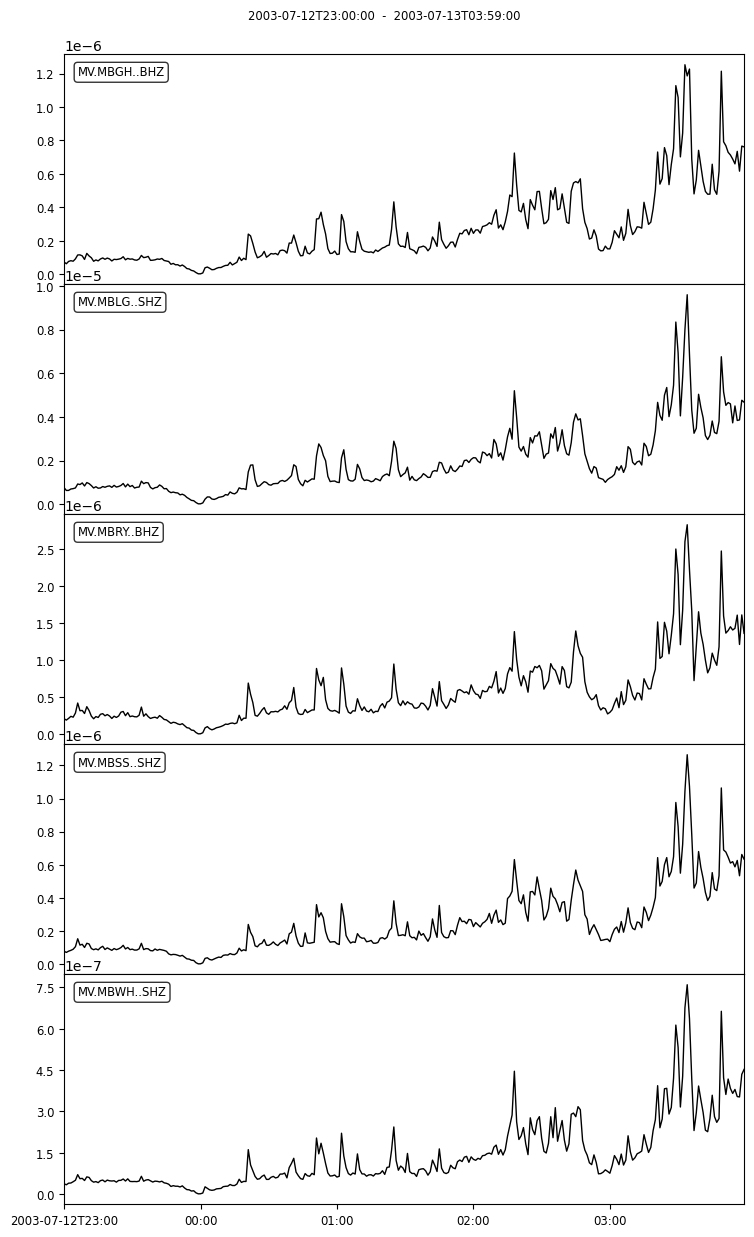

In [11]:
from flovopy.stationmetadata.utils import subset_inv
from flovopy.processing.sam import DSAM 
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
dsamObj = DSAM.read(startt, endt, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'], verbose=True)  
inv_subset = subset_inv(invMVO, dsamObj.to_stream(), level="channel")
dsamObj.plot(metrics='VT')

### 3.2 Create dense grid (20-m node spacing) and plot

/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


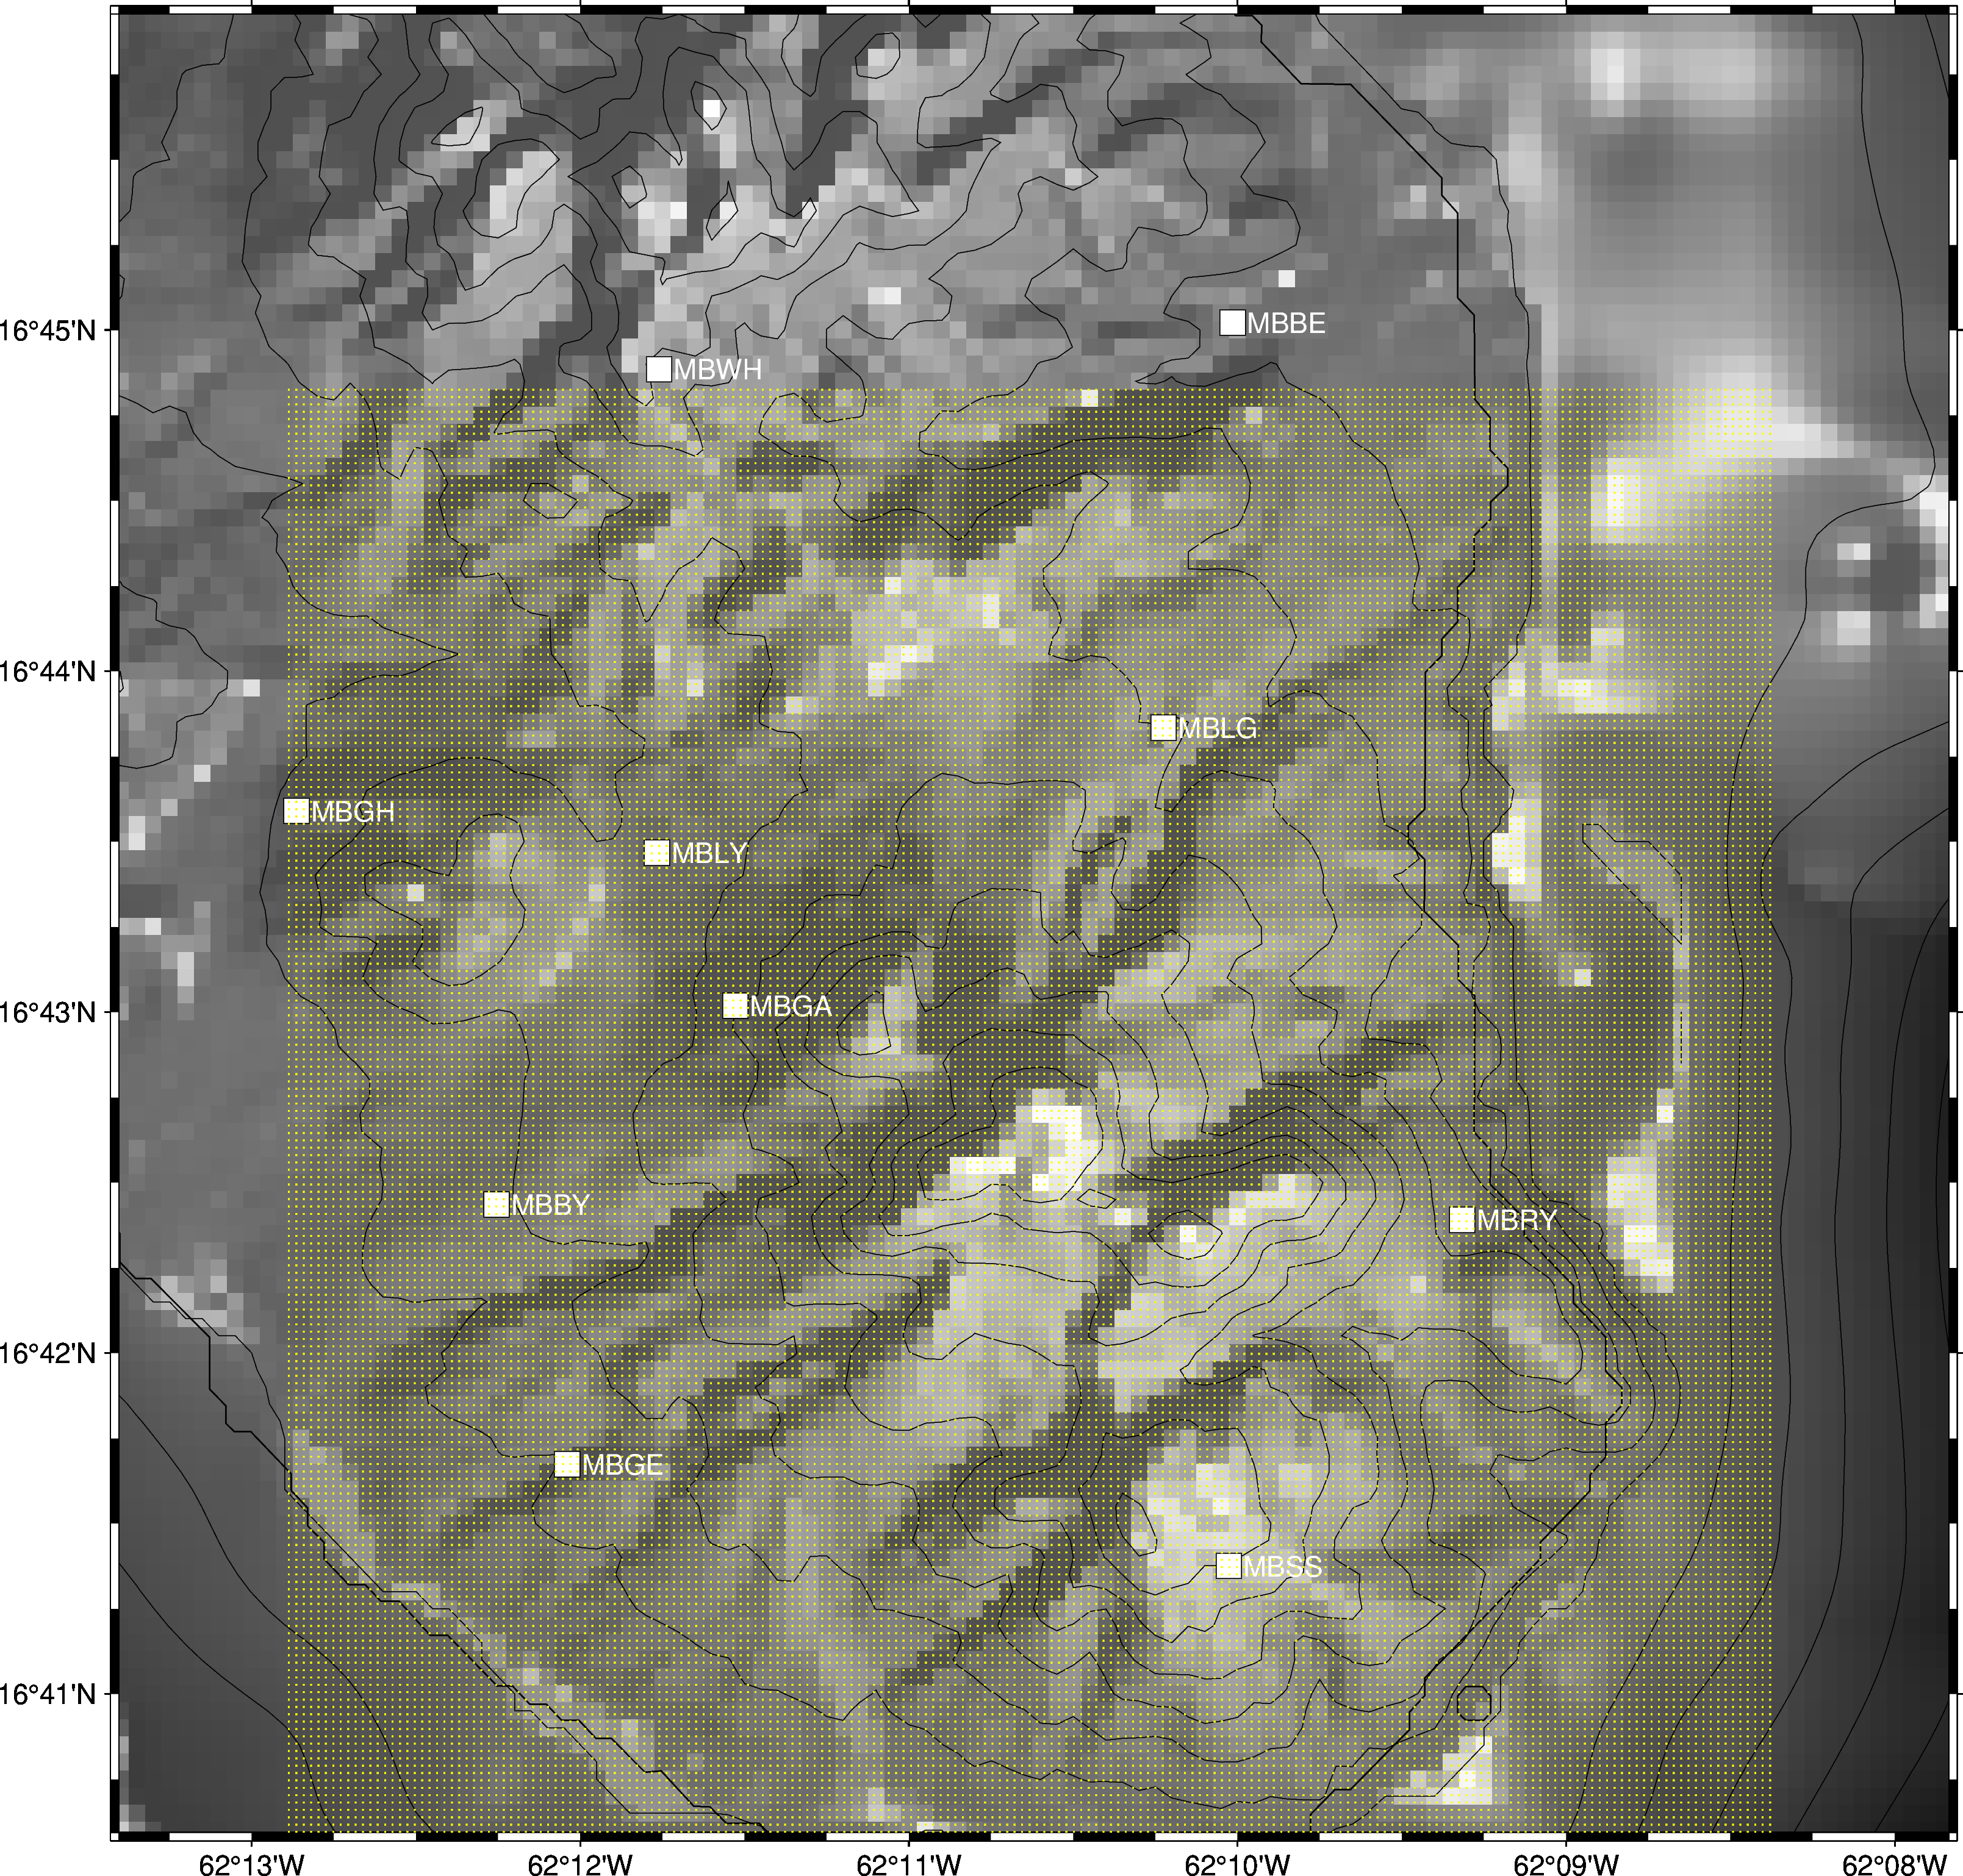

In [12]:
source = {'lat':16.71111, 'lon':-62.17722}
node_spacing_m = 40
grid_size_lat_m = 8000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
topo_map_args = {'inv':invMVO, 'DEM_DIR':DEM_DIR, 'add_labels':True, 'zoom_level':2, 'topo_color':False, 'figsize':10}
gridobj.plot(scale=1.0, symbol='s', pen="0.25p,yellow", topo_map_kwargs=topo_map_args);

### 3.3 Create ASL object, compute combined geometrical spreading and inelatic attenuation corrections for each node

In [13]:
Q = 23
surfaceWaveSpeed_kms = 1.5
peakf = 8.0

aslobj5 = ASL(dsamObj, 'rms', gridobj, window_seconds=60)

# ✅ provide the inventory
aslobj5.compute_grid_distances(inventory=invMVO)

# amplitude corrections (no caching, force recompute)
aslobj5.compute_amplitude_corrections(
    surface_waves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    Q=Q,
    peakf=peakf,
    force_recompute=True
)

[ASL] Computing node→station distances…
[ASL] Distances ready for 13 channels over 40401 nodes.
[ASL] Computing amplitude corrections (surface_waves=True, v=1.5 km/s, Q=23, peakf=8.0 Hz)…
[ASL] Amplitude corrections ready for 13 channels.


{'MV.MBBE..BHZ': array([1702.1836   , 1674.863    , 1648.1313   , ...,    5.805884 ,
           6.0176125,    6.2365227], shape=(40401,), dtype=float32),
 'MV.MBBY..BHZ': array([ 12.800202,  12.670715,  12.546728, ..., 455.08813 , 467.30753 ,
        479.87296 ], shape=(40401,), dtype=float32),
 'MV.MBGA..BHZ': array([ 45.068127,  44.393974,  43.738407, ..., 120.367714, 123.73222 ,
        127.19575 ], shape=(40401,), dtype=float32),
 'MV.MBGB..BHZ': array([ 364.85208,  368.09818,  371.42798, ..., 2158.9636 , 2227.1094 ,
        2297.3887 ], shape=(40401,), dtype=float32),
 'MV.MBGE..BHZ': array([  4.7744155,   4.6760225,   4.5812607, ..., 709.3495   ,
        726.0585   , 743.2051   ], shape=(40401,), dtype=float32),
 'MV.MBGH..BHZ': array([ 66.35029 ,  66.34212 ,  66.349106, ..., 488.39682 , 503.43176 ,
        518.93005 ], shape=(40401,), dtype=float32),
 'MV.MBLG..SHZ': array([345.3579   , 338.77368  , 332.34787  , ...,  12.186468 ,
         12.55738  ,  12.9401865], shape=(40401,)

### 3.4 Run the amplitude location

In [14]:
aslobj5.fast_locate(misfit_backend=StdOverMeanMisfit())

[ASL] fast_locate: preparing data…
[ASL] fast_locate: nsta=5, ntime=300, batch=1024, spatial_blur=off, temporal_smooth_win=0
[ASL] fast_locate: [0:300)
[ASL] connectedness: score=0.844  n_used=45  mean_km=0.18  p90_km=0.31
[ASL] fast_locate: done.


### 3.5 Plot sources and source reduced displacements

/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


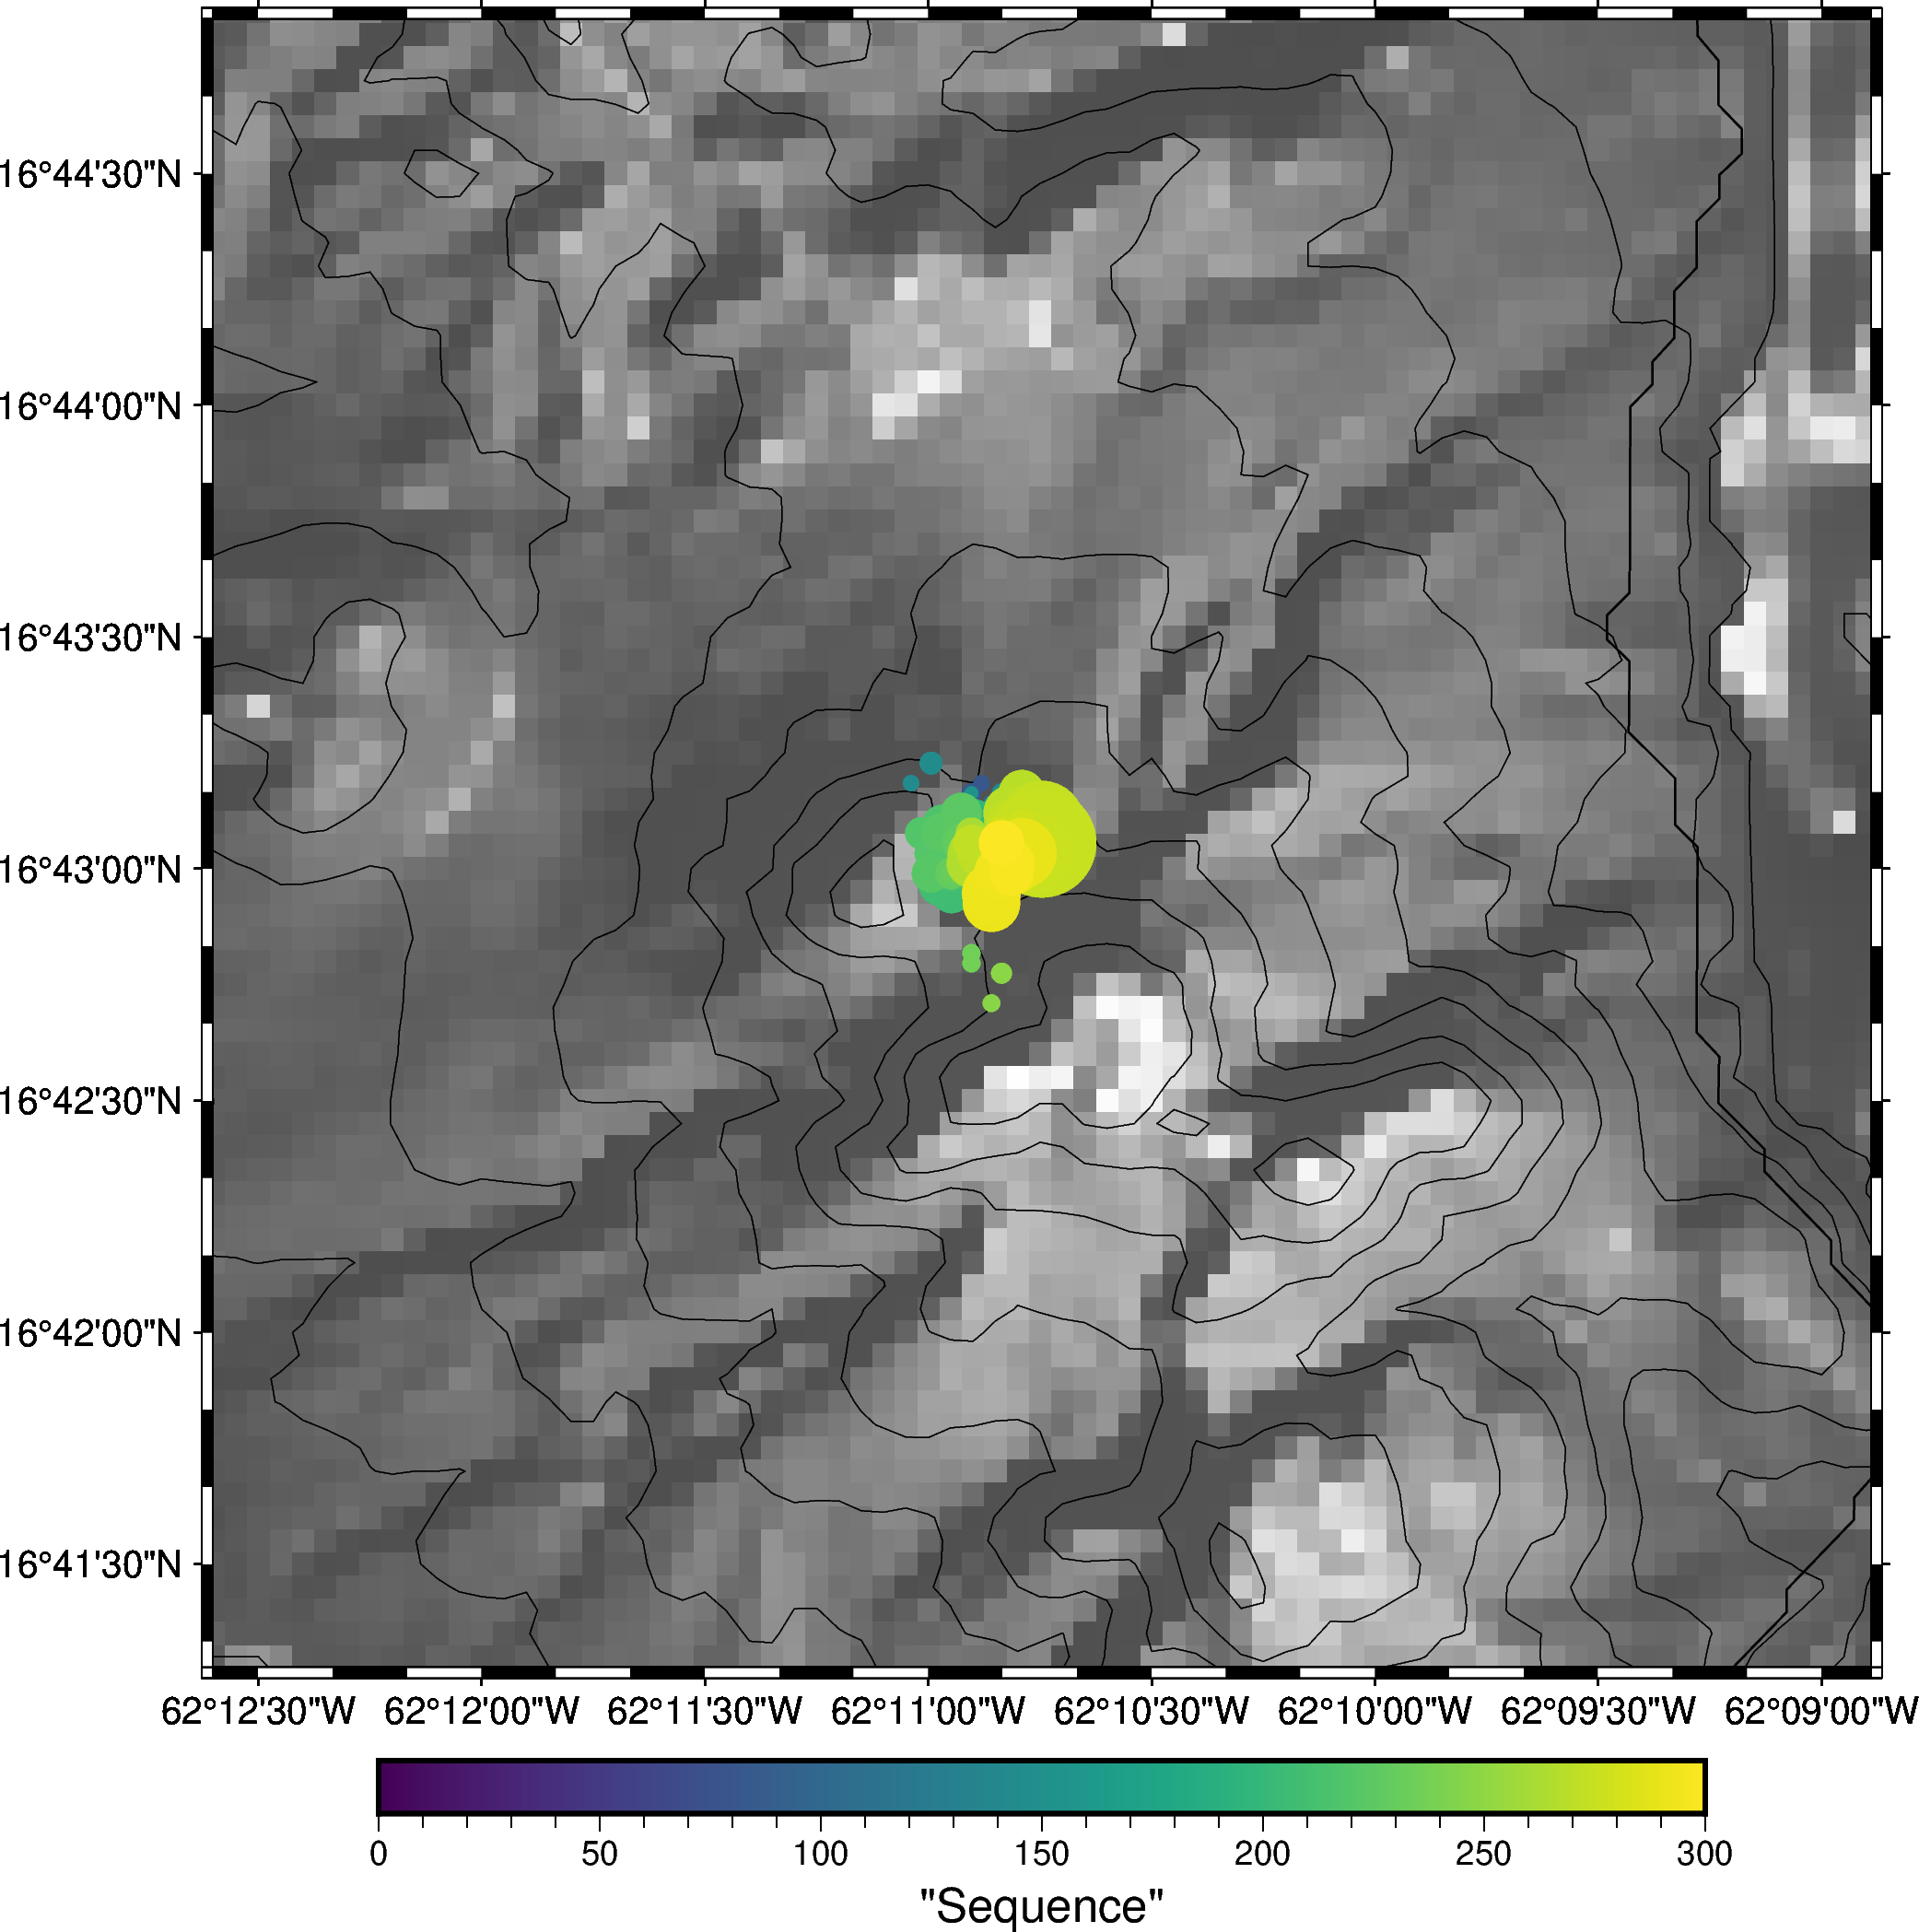

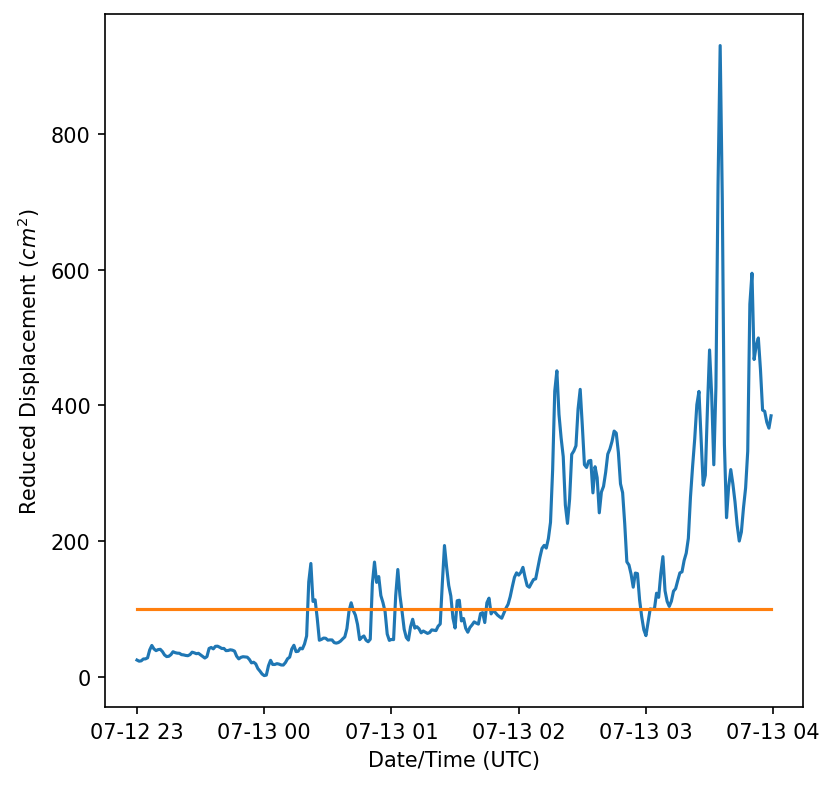

In [15]:
aslobj5.plot(zoom_level=3, threshold_DR=100.0, scale=1, add_labels=True)

## 3.6 Now based on where this is signal located, let's try to see if average amplitude ratios matched those from models assuming this location


Location with the strongest signal: lat=16.717585115562617, lon=-62.17909795535894, DR=930.68927526474


([0, 1, 2, 3, 4],
 [Text(0, 0, 'MBGH'),
  Text(1, 0, 'MBLG'),
  Text(2, 0, 'MBRY'),
  Text(3, 0, 'MBSS'),
  Text(4, 0, 'MBWH')])

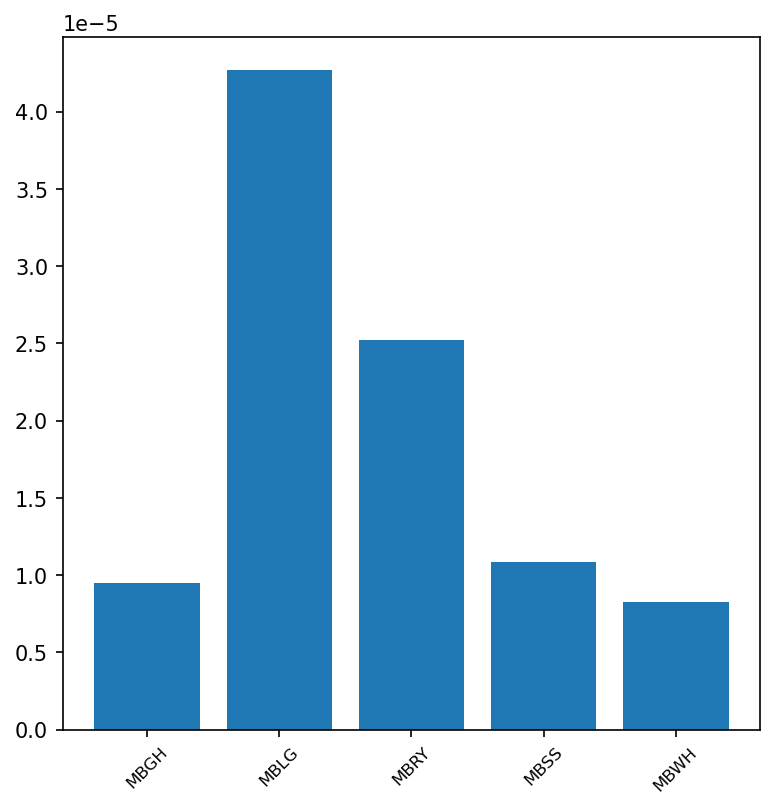

In [16]:
DR = max(aslobj5.source['DR'])
maxi = np.argmax(aslobj5.source['DR'])
slon = aslobj5.source['lon'][maxi]
slat = aslobj5.source['lat'][maxi]
print(f'Location with the strongest signal: lat={slat}, lon={slon}, DR={DR}')

# plot actual amplitude ratios
st = dsamObj.to_stream()
real_amplitudes = [tr.data[maxi] for tr in st ]
x = [id.split('.')[1] for id in dsamObj.get_seed_ids()]
plt.figure()
plt.bar(x, real_amplitudes, width=0.8)
plt.xticks(rotation=45, fontsize=8)

Inventory created at 2025-09-17T22:29:02.201313Z
	Created by: ObsPy 1.4.2
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (5):
			MV (5x)
		Stations (5):
			MV.MBGH ()
			MV.MBLG ()
			MV.MBRY ()
			MV.MBSS ()
			MV.MBWH ()
		Channels (5):
			MV.MBGH..BHZ, MV.MBLG..SHZ, MV.MBRY..BHZ, MV.MBSS..SHZ, 
			MV.MBWH..SHZ


/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


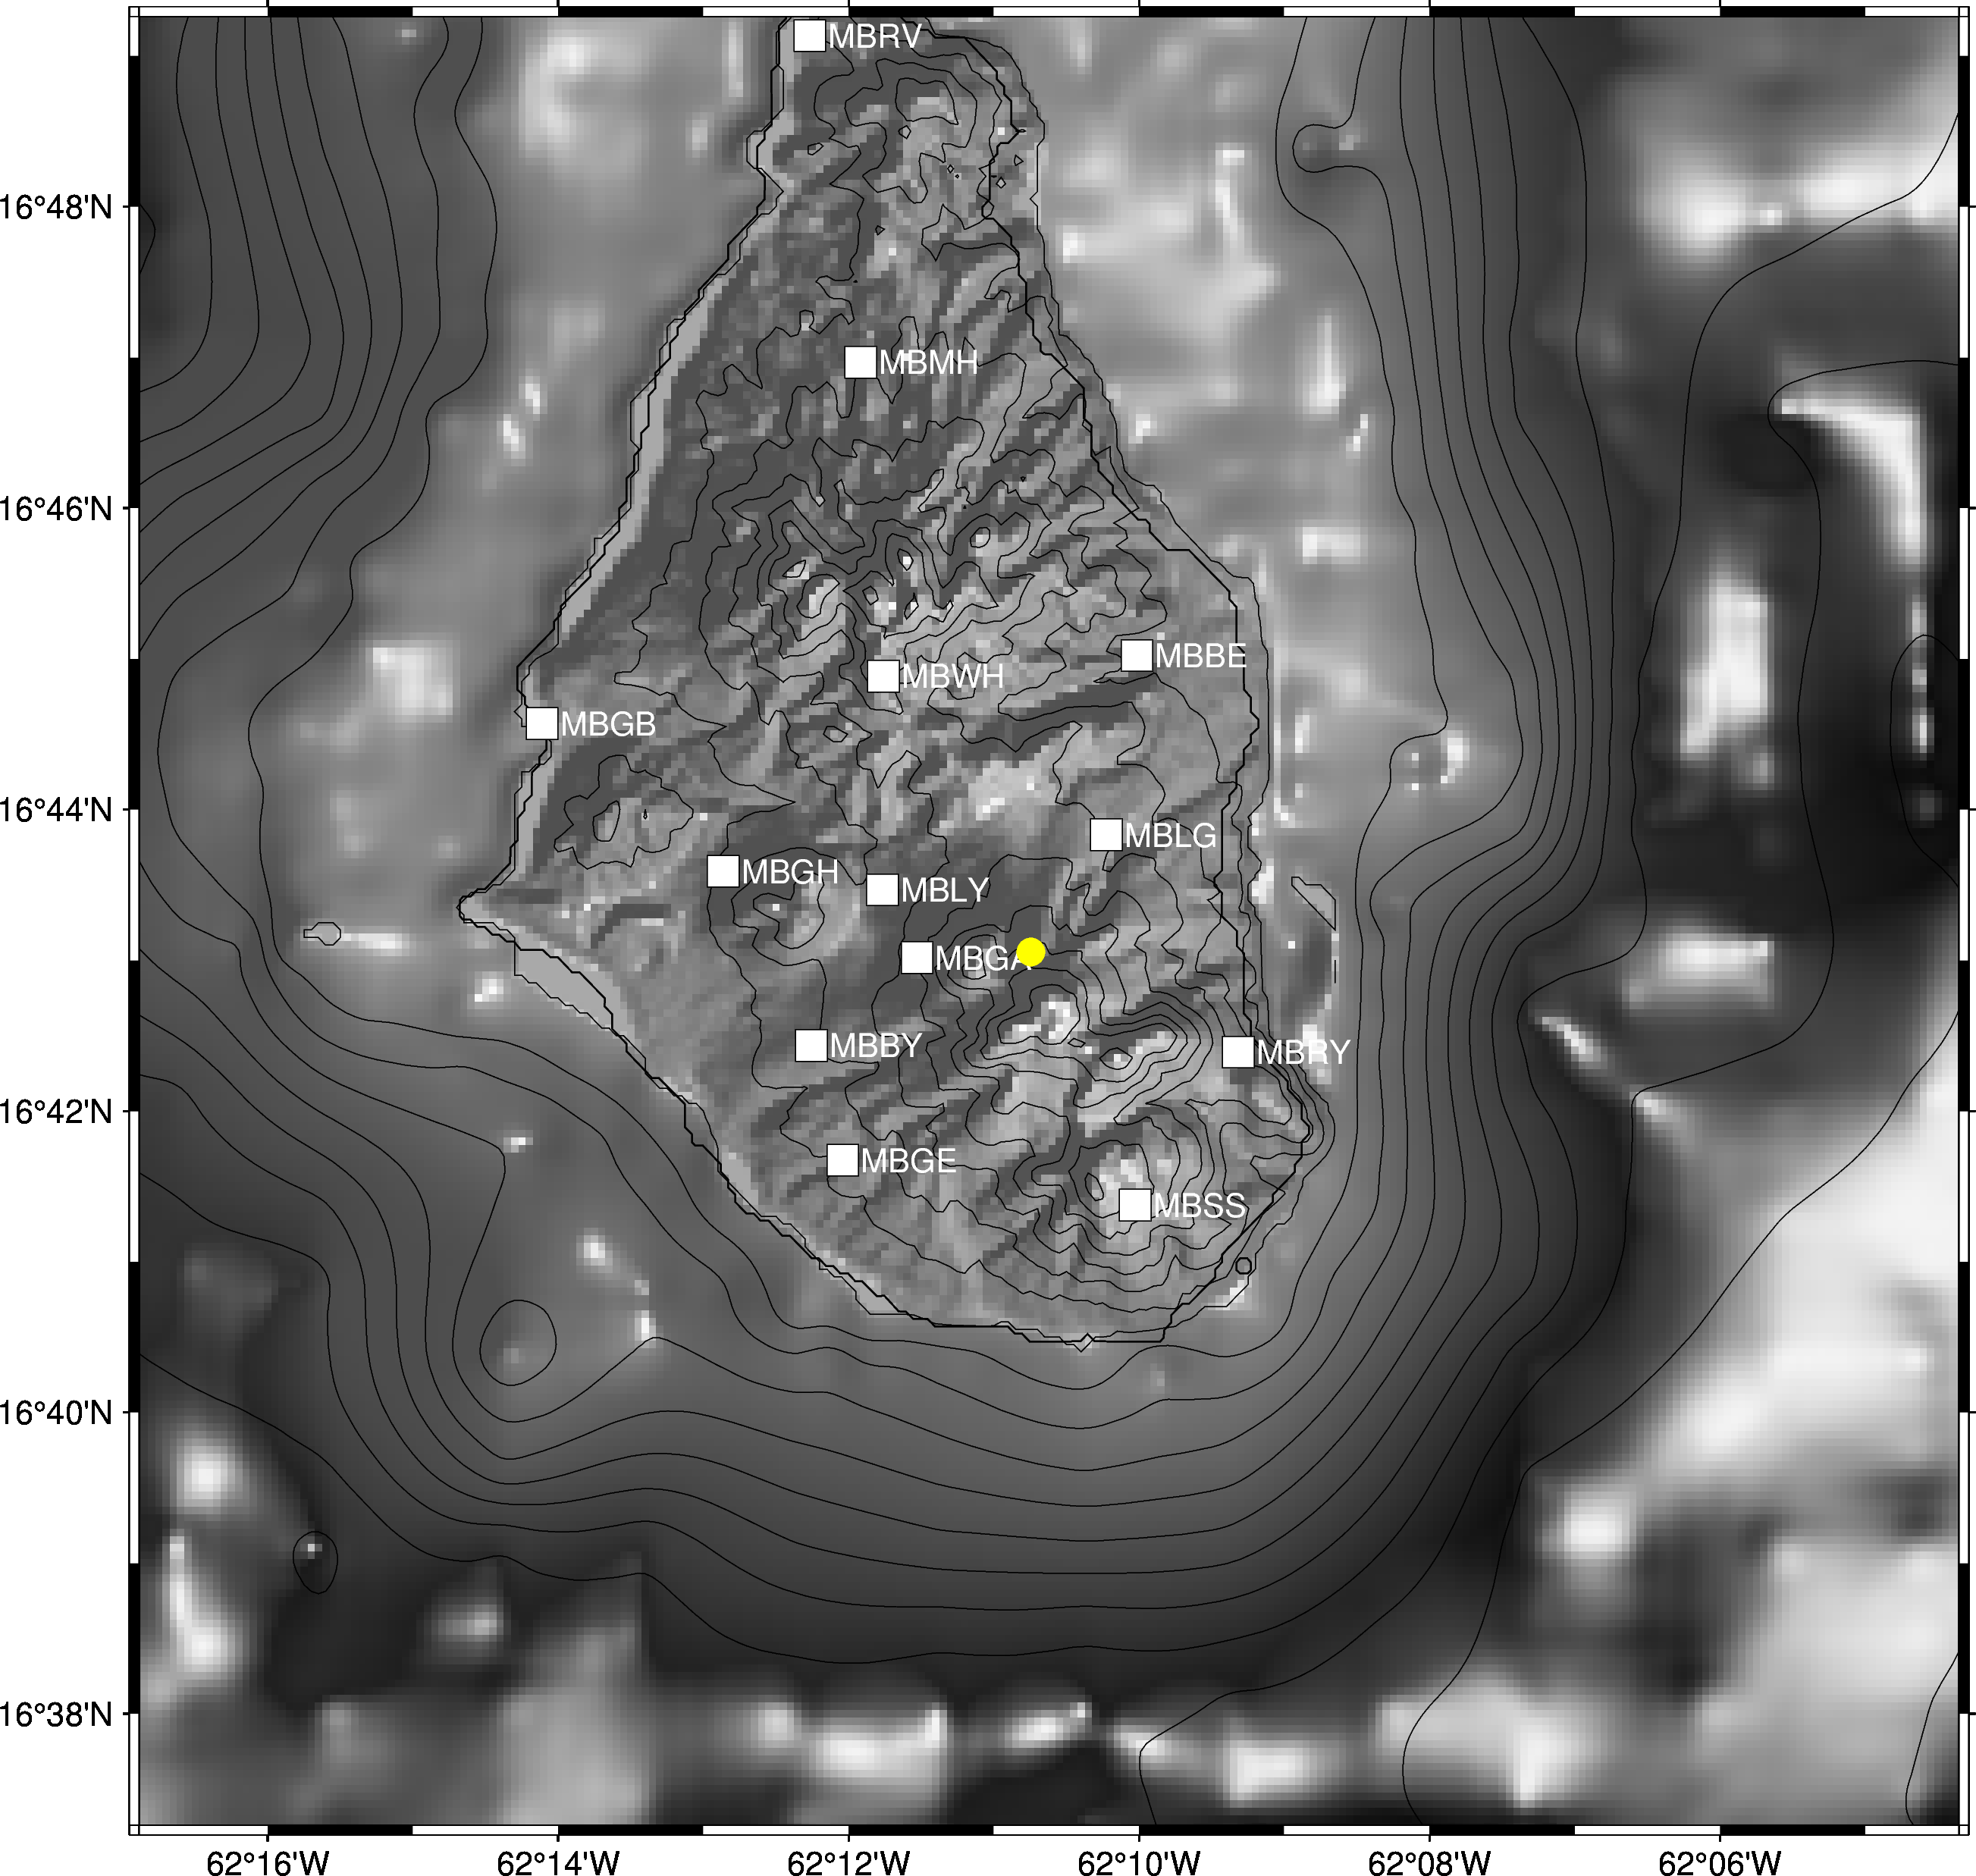

(<pygmt.figure.Figure at 0x149fb5520>, array([0]))

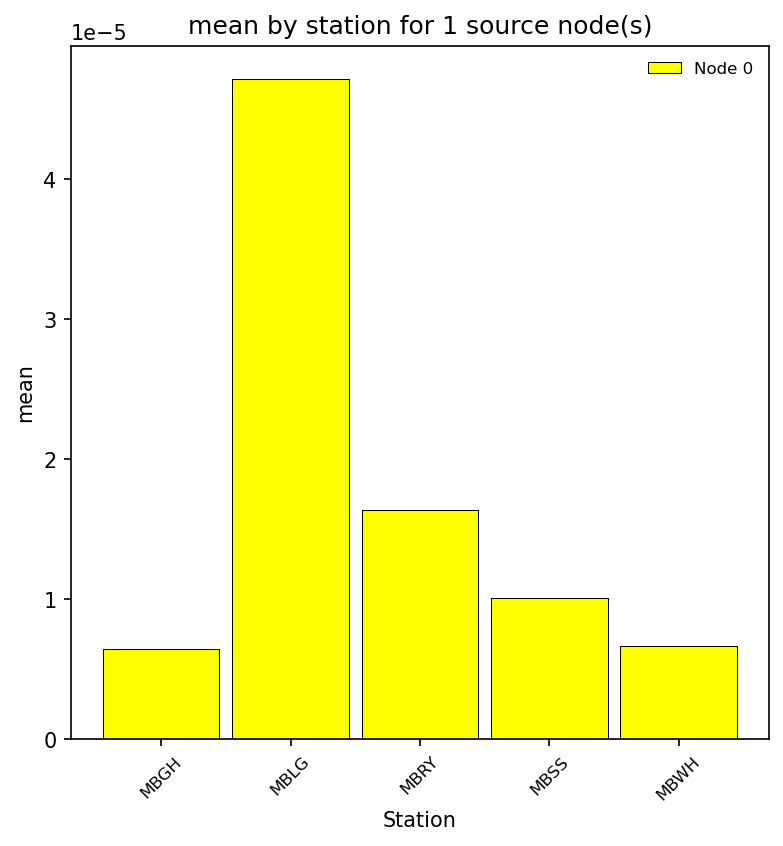

In [17]:
sampling_interval = 60.0  # seconds, to simulate moving window
gridobj = Grid(slat, slon, 1, 1, 1)

synthetic_source2 = synthetic_source_from_grid(
    gridobj,
    sampling_interval=sampling_interval,
    DR_cm2=DR,
    t0=obspy.UTCDateTime(0),
    order="C",
)

surfaceWaveSpeed_kms = 1.5
peakf = 8.0
Q = 23

print(inv_subset)
synthDSAMobj = simulate_SAM(
    inv_subset,
    synthetic_source2,
    surfaceWaves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    peakf=peakf,
    Q=Q,
    noise_level_percent=0.0,
)
plot_SAM(synthDSAMobj, gridobj, K=1, metric='mean', DEM_DIR=DEM_DIR, inv=invMVO, figsize=8)


## 4. Locate a pyroclastic flow

Inventory created at 2024-01-11T03:20:26.394930Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (13):
			MV (13x)
		Stations (13):
			MV.MBBE ()
			MV.MBBY ()
			MV.MBGA ()
			MV.MBGB ()
			MV.MBGE ()
			MV.MBGH ()
			MV.MBLG ()
			MV.MBLY ()
			MV.MBMH ()
			MV.MBRV ()
			MV.MBRY ()
			MV.MBSS ()
			MV.MBWH ()
		Channels (13):
			MV.MBBE..BHZ, MV.MBBY..BHZ, MV.MBGA..BHZ, MV.MBGB..BHZ, 
			MV.MBGE..BHZ, MV.MBGH..BHZ, MV.MBLG..SHZ, MV.MBLY..HHZ, 
			MV.MBMH..SHZ, MV.MBRV..SHZ, MV.MBRY..BHZ, MV.MBSS..SHZ, 
			MV.MBWH..SHZ
MV.MBGB..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBGH..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBLG..SHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBLY..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 100.0 Hz, 18001 sa

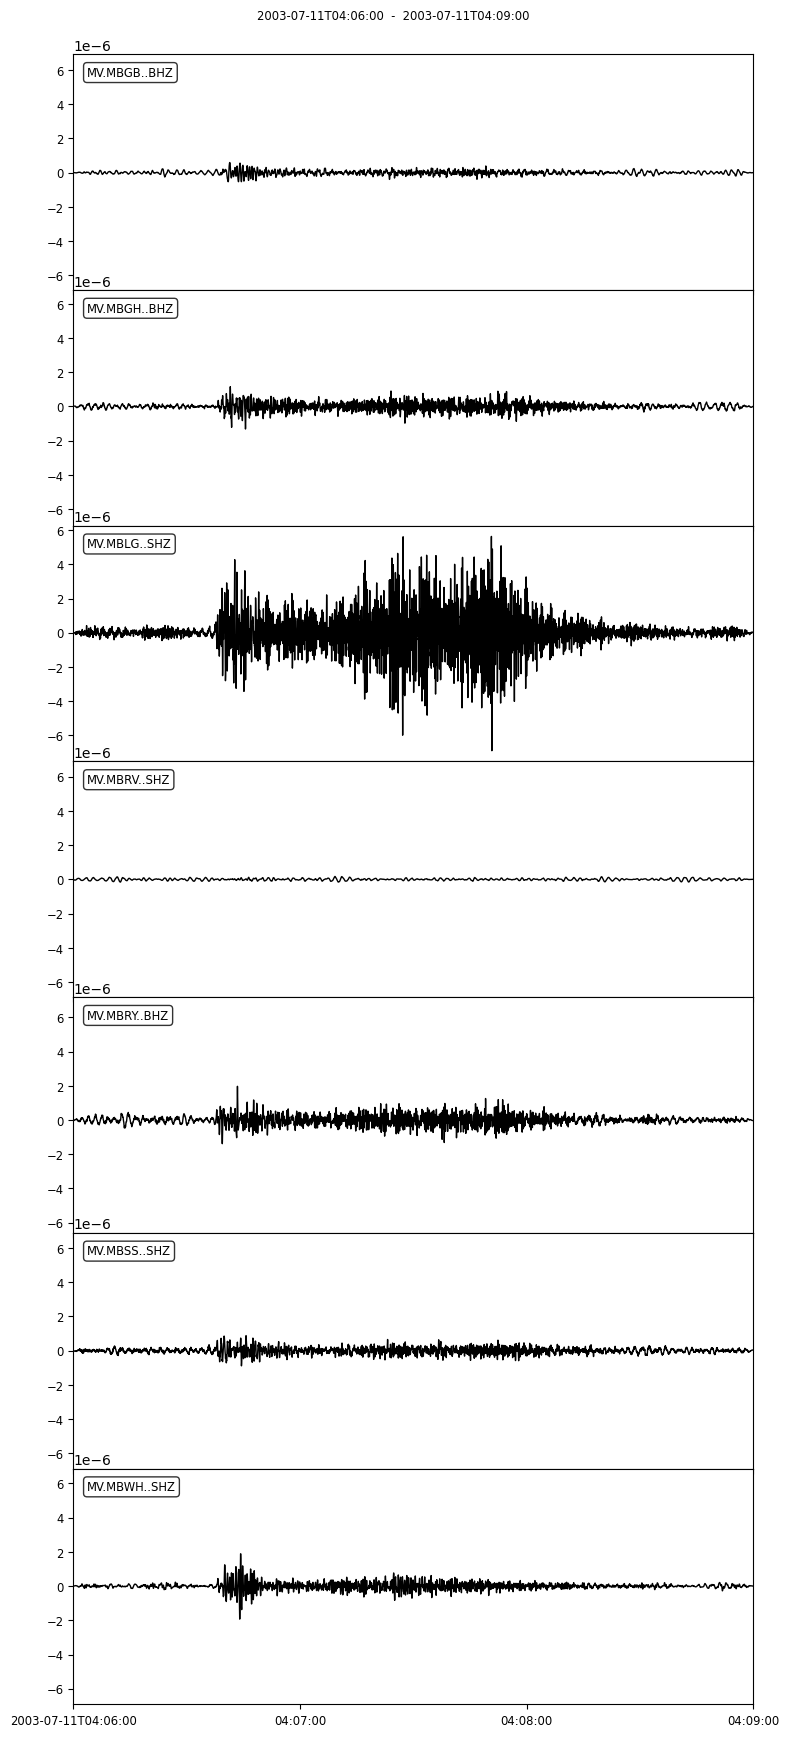

In [18]:

from obspy.clients.filesystem.sds import Client

sdsclient = Client(SDS_DIR)
starttpf = obspy.UTCDateTime(2003,7,11,4,6,0)
endtpf = obspy.UTCDateTime(2003,7,11,4,9,0)
stpf = sdsclient.get_waveforms("MV", "*", "", "*Z", starttpf, endtpf)

# Load inventory
invpf = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
invpf = invMVO.select(starttime=startt, endtime=endt)
invpf = invMVO.select(channel='*Z')
print(invpf)

# remove instrument response - and set units accordingly IMPORTANT!
pre_filt = [0.4, 0.5, 18, 20]
#pre_filt = [6.0, 7.0, 9.0, 10.0]
for tr in stpf:
    print(tr)
    try:
        tr.remove_response(inventory=invpf, pre_filt=pre_filt, output="DISP", plot=False) 
    except:
        stpf.remove(tr)
    else:
        tr.stats['units'] = 'm'
stpf.plot(equal_scale=True);


NOTE: 'squash_nans' is deprecated; SAM now always uses NaN-aware reducers.
METRIC: rms


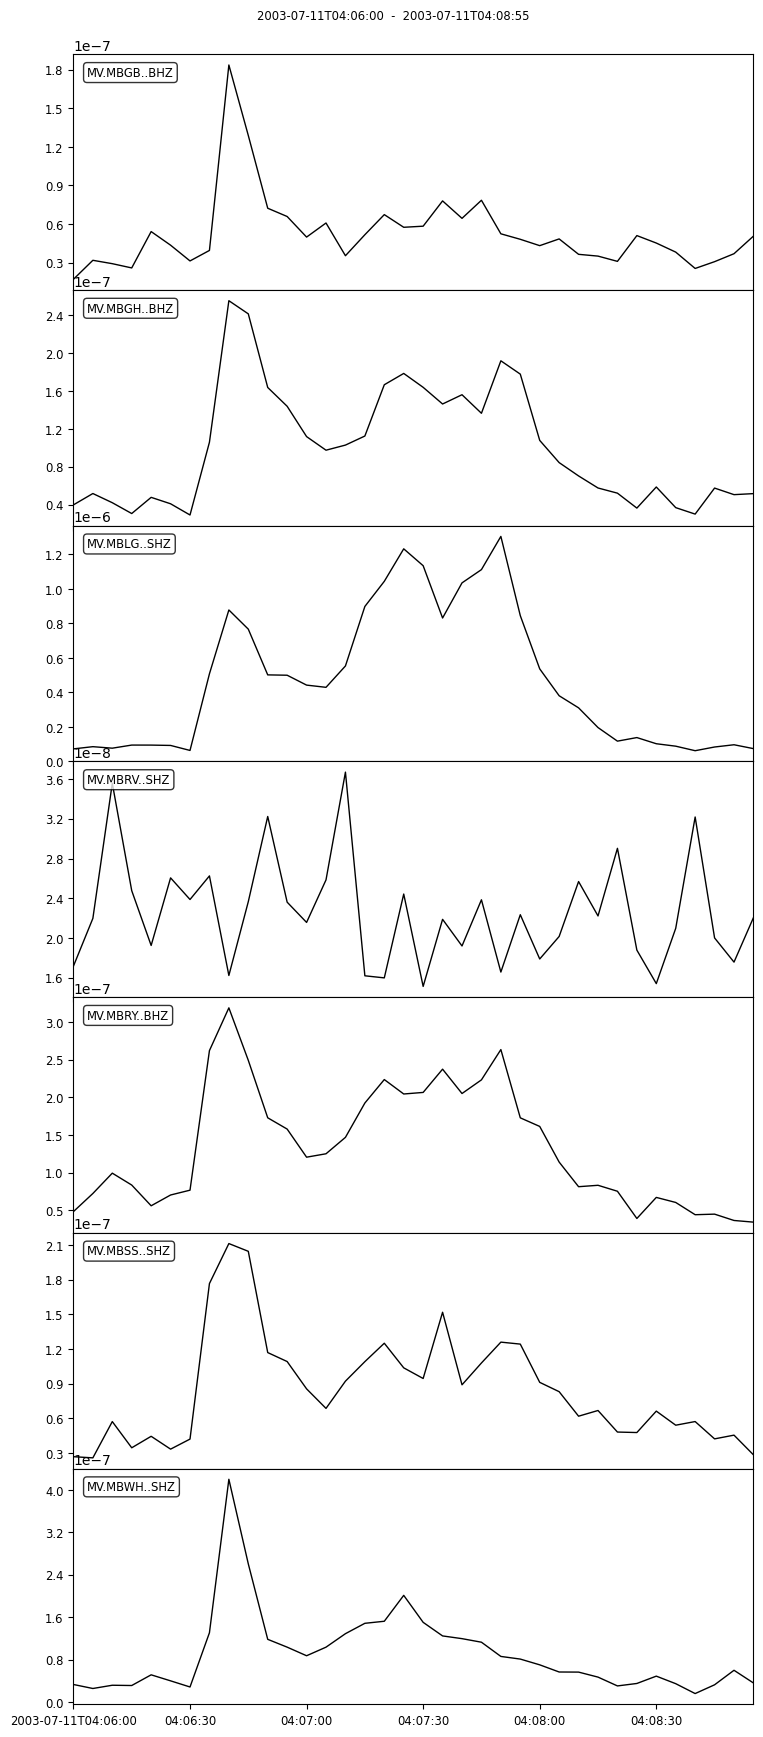

In [19]:

# compute DSAM data with 10-s time window
dsamObjpf = DSAM(stream=stpf, sampling_interval=5)
#print(dsamObj)
dsamObjpf.plot(metrics='rms', equal_scale=False)

In [20]:

# same parameters as before
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

# denser grid than before
source = {'lat':16.71111, 'lon':-62.17722}
#node_spacing_m = 20
node_spacing_m = 10 
grid_size_lat_m = 10000
grid_size_lon_m = 10000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  

SCAFFOLD: Inventory created at 2024-01-11T03:20:26.394930Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (13):
			MV (13x)
		Stations (13):
			MV.MBBE ()
			MV.MBBY ()
			MV.MBGA ()
			MV.MBGB ()
			MV.MBGE ()
			MV.MBGH ()
			MV.MBLG ()
			MV.MBLY ()
			MV.MBMH ()
			MV.MBRV ()
			MV.MBRY ()
			MV.MBSS ()
			MV.MBWH ()
		Channels (13):
			MV.MBBE..BHZ, MV.MBBY..BHZ, MV.MBGA..BHZ, MV.MBGB..BHZ, 
			MV.MBGE..BHZ, MV.MBGH..BHZ, MV.MBLG..SHZ, MV.MBLY..HHZ, 
			MV.MBMH..SHZ, MV.MBRV..SHZ, MV.MBRY..BHZ, MV.MBSS..SHZ, 
			MV.MBWH..SHZ
SCAFFOLD: Inventory created at 2024-01-11T03:20:26.394930Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (13):
			MV (13x)
		Stations (13):
			MV.MBBE ()
			MV.MBBY ()
			MV.MBGA ()
			MV.MBGB ()
			MV.MBGE ()
			MV.MBGH ()
			MV.MBLG ()
			MV.MBLY ()
			MV.MBMH ()
			MV.MBRV ()
			MV.MBR

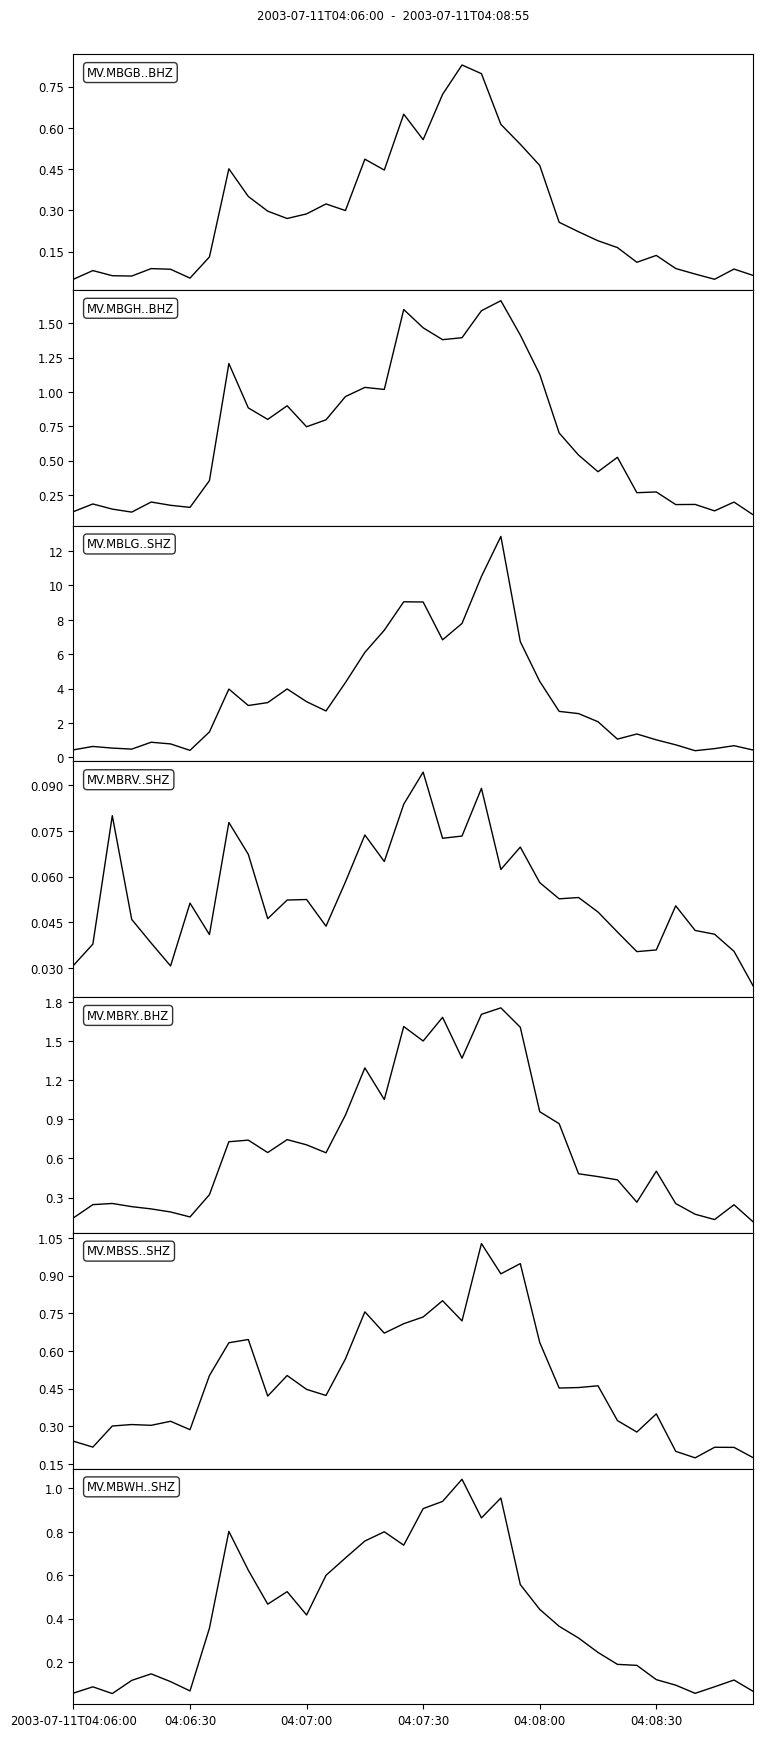

In [21]:
# Reduced displacement if source was at dome
DRSobjpf = dsamObjpf.compute_reduced_displacement(invpf, source, surfaceWaves=True, Q=None, wavespeed_kms=1.5)
DRSobjpf.plot(equal_scale=False, metrics=['VT'])

In [22]:
aslobjpf = ASL(dsamObjpf, 'VT', gridobj, window_seconds=5)

aslobjpf.compute_grid_distances(inventory=invpf)

aslobjpf.compute_amplitude_corrections(surface_waves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, peakf = peakf)


[ASL] Computing node→station distances…
[ASL] Distances ready for 13 channels over 1002001 nodes.
[ASL] Computing amplitude corrections (surface_waves=True, v=1.5 km/s, Q=23, peakf=8.0 Hz)…
[ASL] Amplitude corrections ready for 13 channels.


{'MV.MBBE..BHZ': array([4966.097   , 4945.2     , 4924.4146  , ...,   15.078819,
          15.20663 ,   15.335484], shape=(1002001,), dtype=float32),
 'MV.MBBY..BHZ': array([  38.19103 ,   38.058407,   37.926743, ..., 1406.835   ,
        1415.9023  , 1425.0315  ], shape=(1002001,), dtype=float32),
 'MV.MBGA..BHZ': array([136.4387 , 135.87338, 135.31157, ..., 377.33658, 379.83676,
        382.35446], shape=(1002001,), dtype=float32),
 'MV.MBGB..BHZ': array([ 671.68964,  672.412  ,  673.1412 , ..., 5247.107  , 5287.4604 ,
        5328.123  ], shape=(1002001,), dtype=float32),
 'MV.MBGE..BHZ': array([  16.38545 ,   16.299007,   16.213211, ..., 2215.5945  ,
        2228.3481  , 2241.1824  ], shape=(1002001,), dtype=float32),
 'MV.MBGH..BHZ': array([ 158.93106,  158.73656,  158.54413, ..., 1376.3248 , 1386.4482 ,
        1396.6469 ], shape=(1002001,), dtype=float32),
 'MV.MBLG..SHZ': array([1043.6653  , 1038.5776  , 1033.5199  , ...,   40.63733 ,
          40.917656,   41.20006 ], shape=(1

In [23]:
aslobjpf.fast_locate()
print(aslobjpf.estimate_decay_params(use_reduced=False, verbose=True, neighborhood_k=30))


[ASL] fast_locate: preparing data…
[ASL] fast_locate: nsta=7, ntime=36, batch=1024, spatial_blur=off, temporal_smooth_win=0
[ASL] fast_locate: [0:36)
[ASL] connectedness: score=0.381  n_used=12  mean_km=1.62  p90_km=3.71
[ASL] fast_locate: done.
[ASL] decay-fit @ t=3, node=897761 (lat=16.74672, lon=-62.14295)  N=-0.340, k=0.49192 1/km, Q=34.1 (f=8.0, v=1.5)  r2=0.724  nsta=7
[ASL] decay-fit @ t=3, node=898762 (lat=16.74681, lon=-62.14295)  N=-0.350, k=0.49389 1/km, Q=33.9 (f=8.0, v=1.5)  r2=0.723  nsta=7
[ASL] decay-fit @ t=3, node=896760 (lat=16.74663, lon=-62.14295)  N=-0.329, k=0.48996 1/km, Q=34.2 (f=8.0, v=1.5)  r2=0.726  nsta=7
[ASL] decay-fit @ t=3, node=897762 (lat=16.74672, lon=-62.14285)  N=-0.338, k=0.49164 1/km, Q=34.1 (f=8.0, v=1.5)  r2=0.725  nsta=7
[ASL] decay-fit @ t=3, node=897760 (lat=16.74672, lon=-62.14304)  N=-0.341, k=0.49221 1/km, Q=34.0 (f=8.0, v=1.5)  r2=0.724  nsta=7
[ASL] decay-fit @ t=3, node=898763 (lat=16.74681, lon=-62.14285)  N=-0.349, k=0.49359 1/km, Q=

                          t       lat        lon        DR   misfit      azgap  nsta  node_index  connectedness
2003-07-11T04:06:00.000000Z 16.742406 -62.149990 10.139541 0.738572 222.515800     7      849638       0.380954
2003-07-11T04:06:05.000000Z 16.742946 -62.155248  8.727733 0.718672 212.004540     7      855588       0.380954
2003-07-11T04:06:10.000000Z 16.746453 -62.150271 14.925669 0.706142 222.648691     7      894680       0.380954
2003-07-11T04:06:15.000000Z 16.746723 -62.142947 22.520931 0.715812 235.832666     7      897761       0.380954
2003-07-11T04:06:20.000000Z 16.742946 -62.151492 12.894717 0.717042 219.598018     7      855628       0.380954
2003-07-11T04:06:25.000000Z 16.740878 -62.156469  9.747876 0.733973 208.725217     7      832552       0.380954
2003-07-11T04:06:30.000000Z 16.742676 -62.151116 12.635858 0.741694 220.300704     7      852629       0.380954
2003-07-11T04:06:35.000000Z 16.741237 -62.153746 14.217604 0.706225 214.595132     7      836585       0

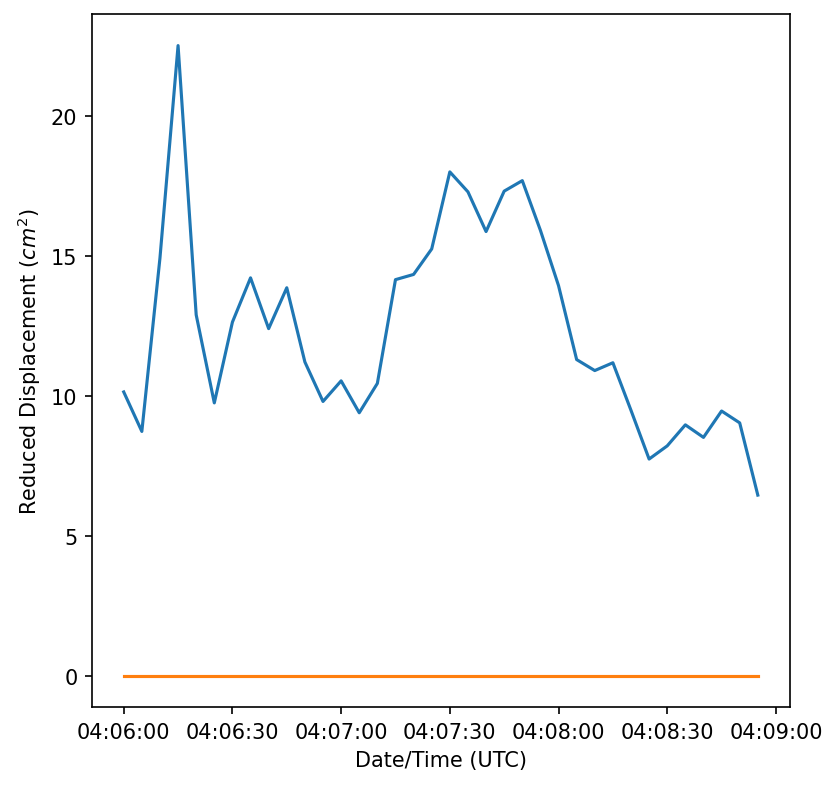

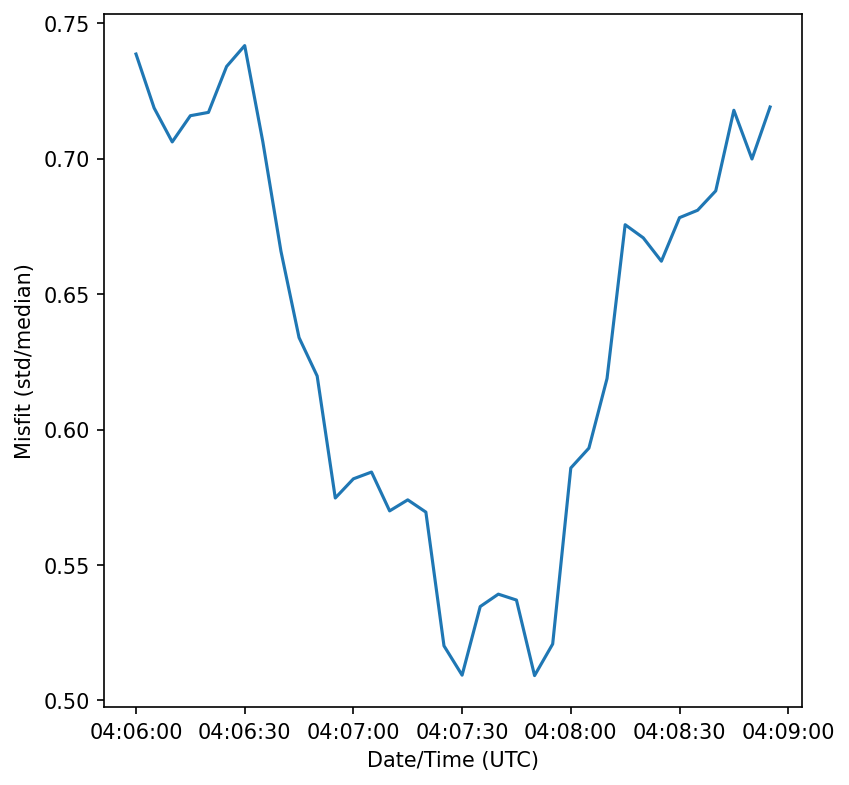

/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


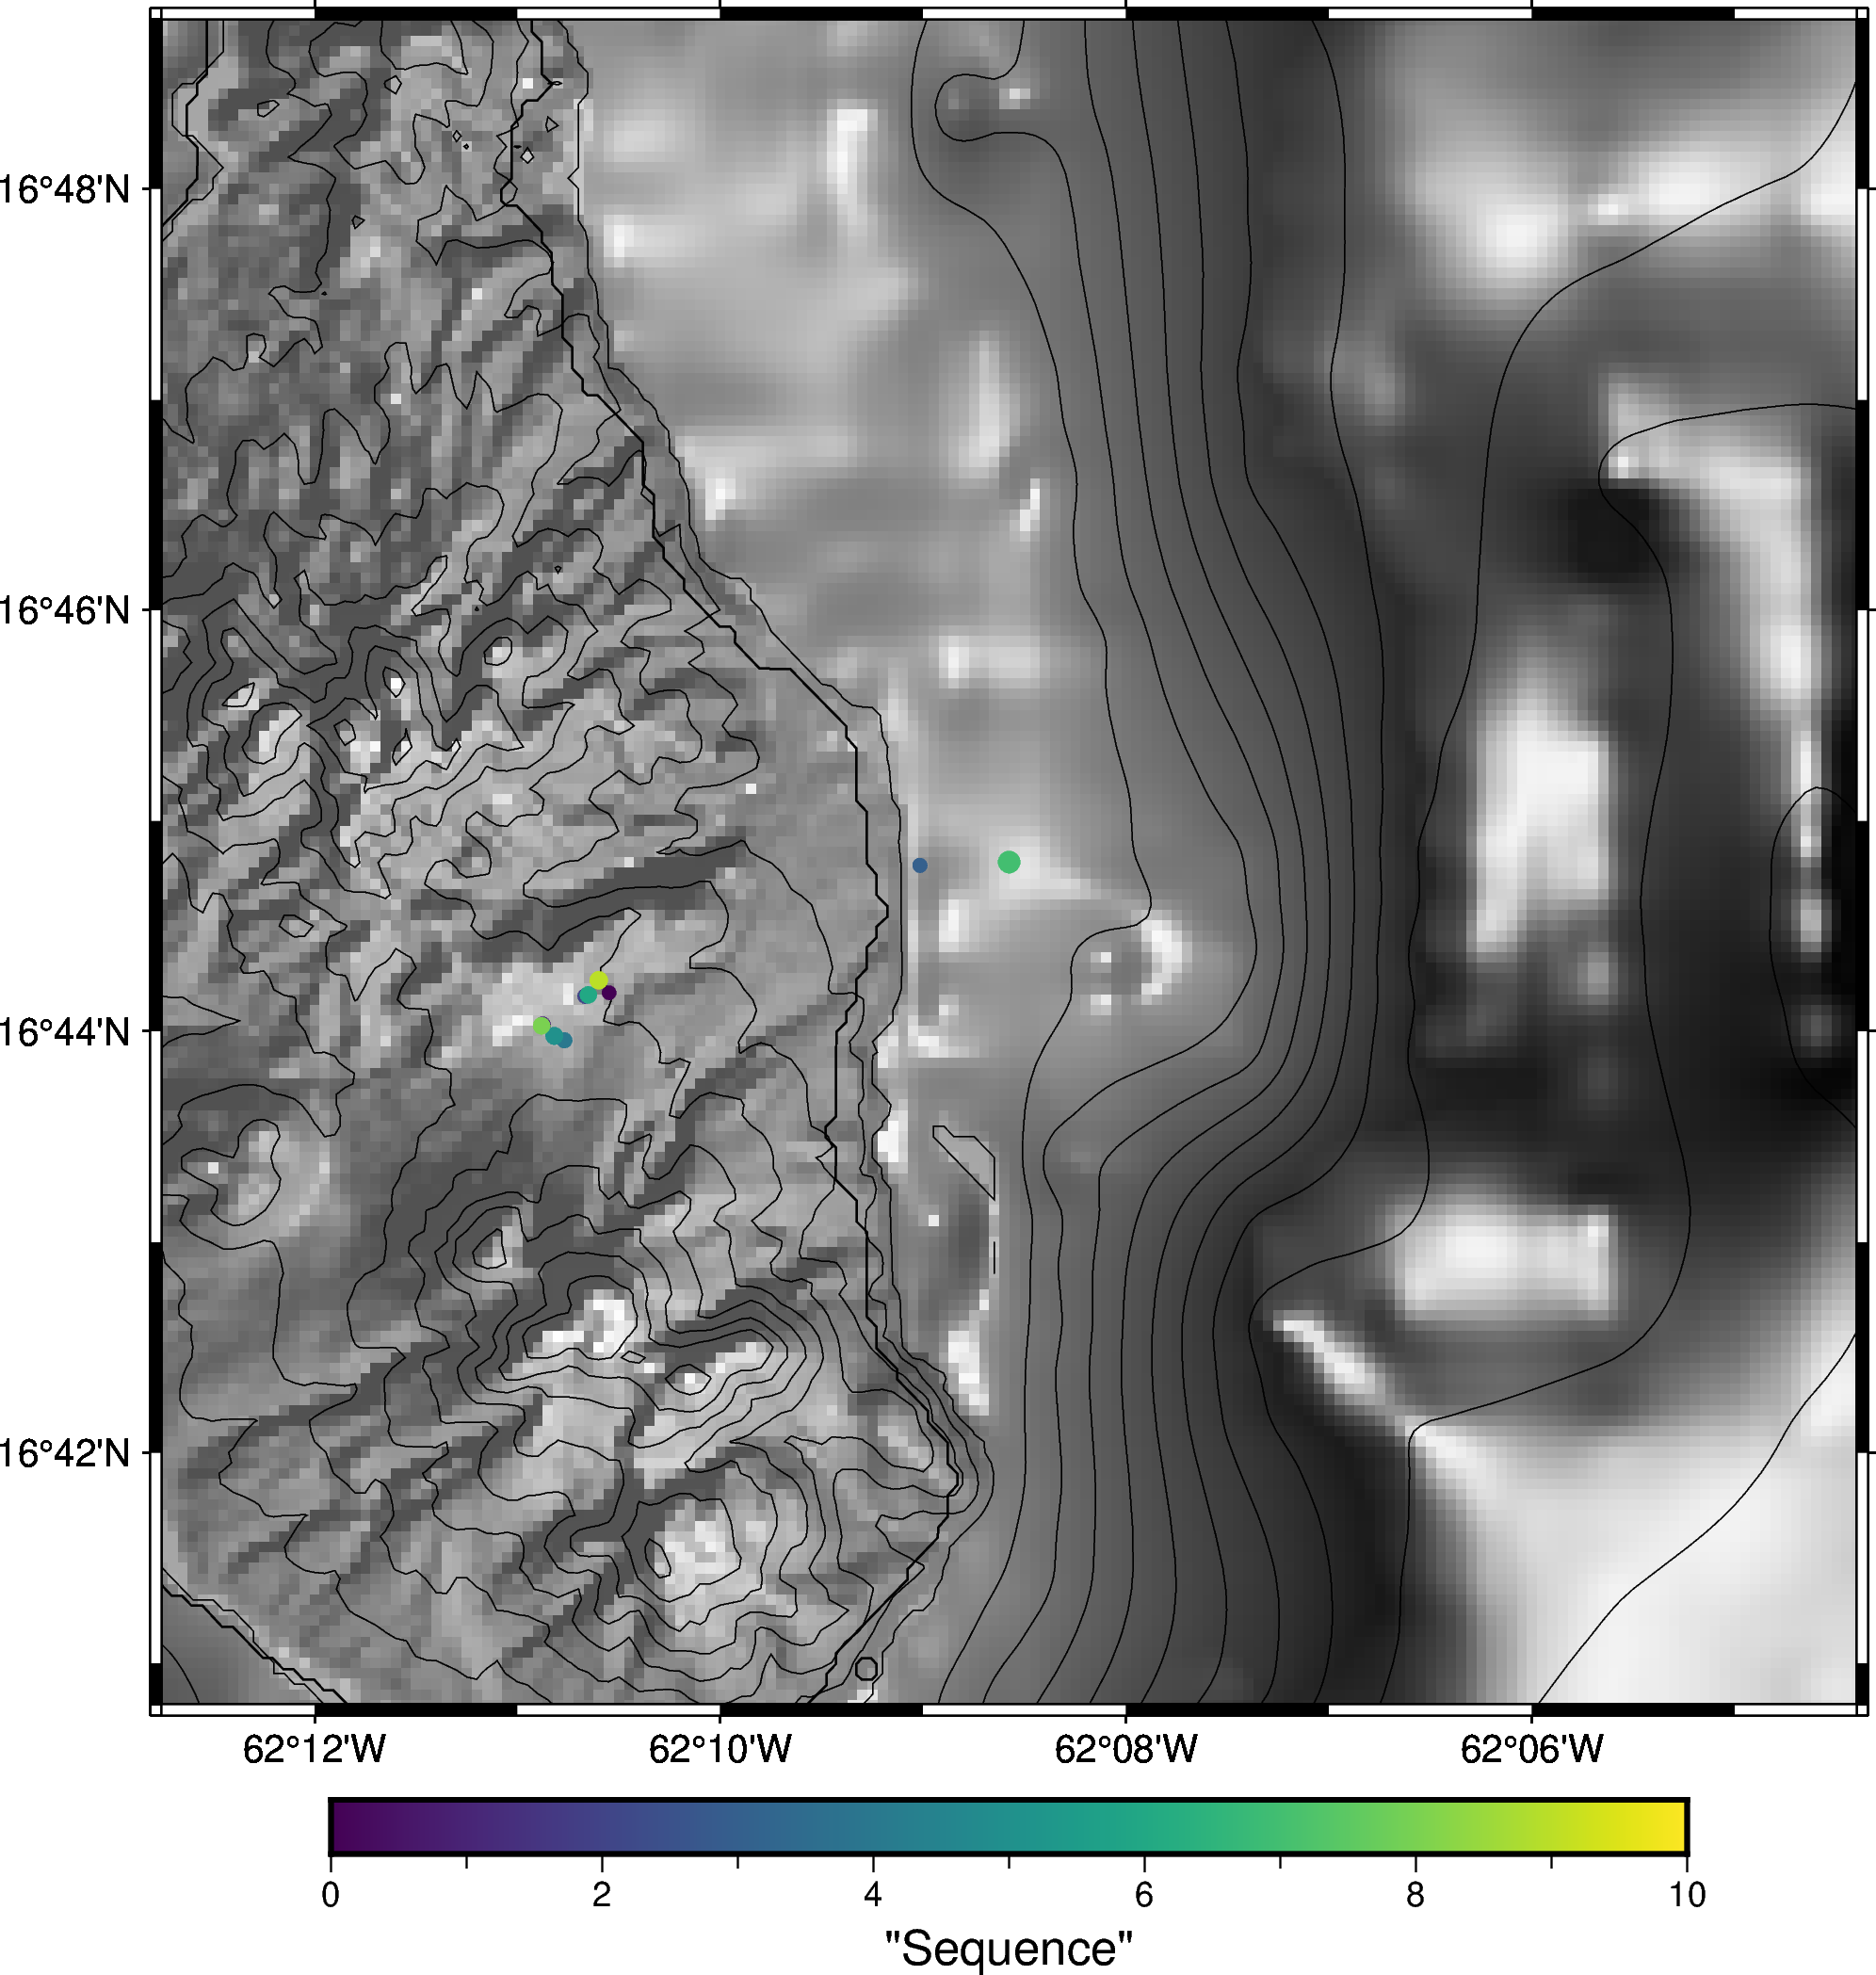

plot [WARNING]: - not a valid number and may not be decoded properly.


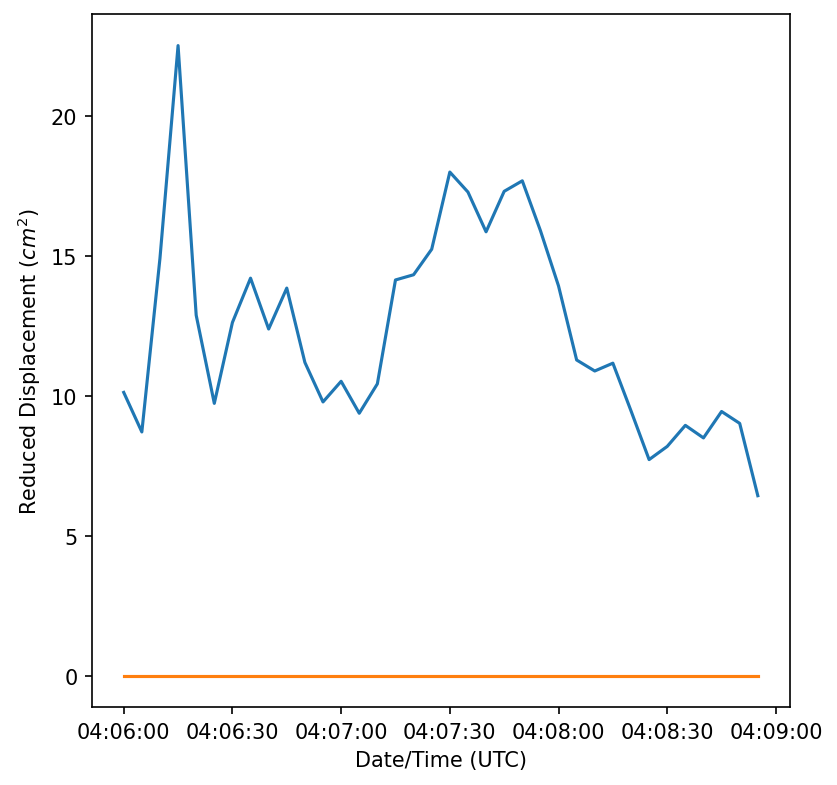

In [24]:
aslobjpf.print_source()
aslobjpf.plot_reduced_displacement()
aslobjpf.plot_misfit()
aslobjpf.plot(zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, add_labels=False)

[ASL] fast_locate: preparing data…
[ASL] fast_locate: nsta=7, ntime=36, batch=1024, spatial_blur=on, temporal_smooth_win=5
[ASL] fast_locate: [0:36)
[ASL] connectedness: score=0.413  n_used=12  mean_km=1.42  p90_km=3.25
[ASL] fast_locate: done.


/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:87: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=ergrid, interval=step, pen="0.25p,black", limit=limit)


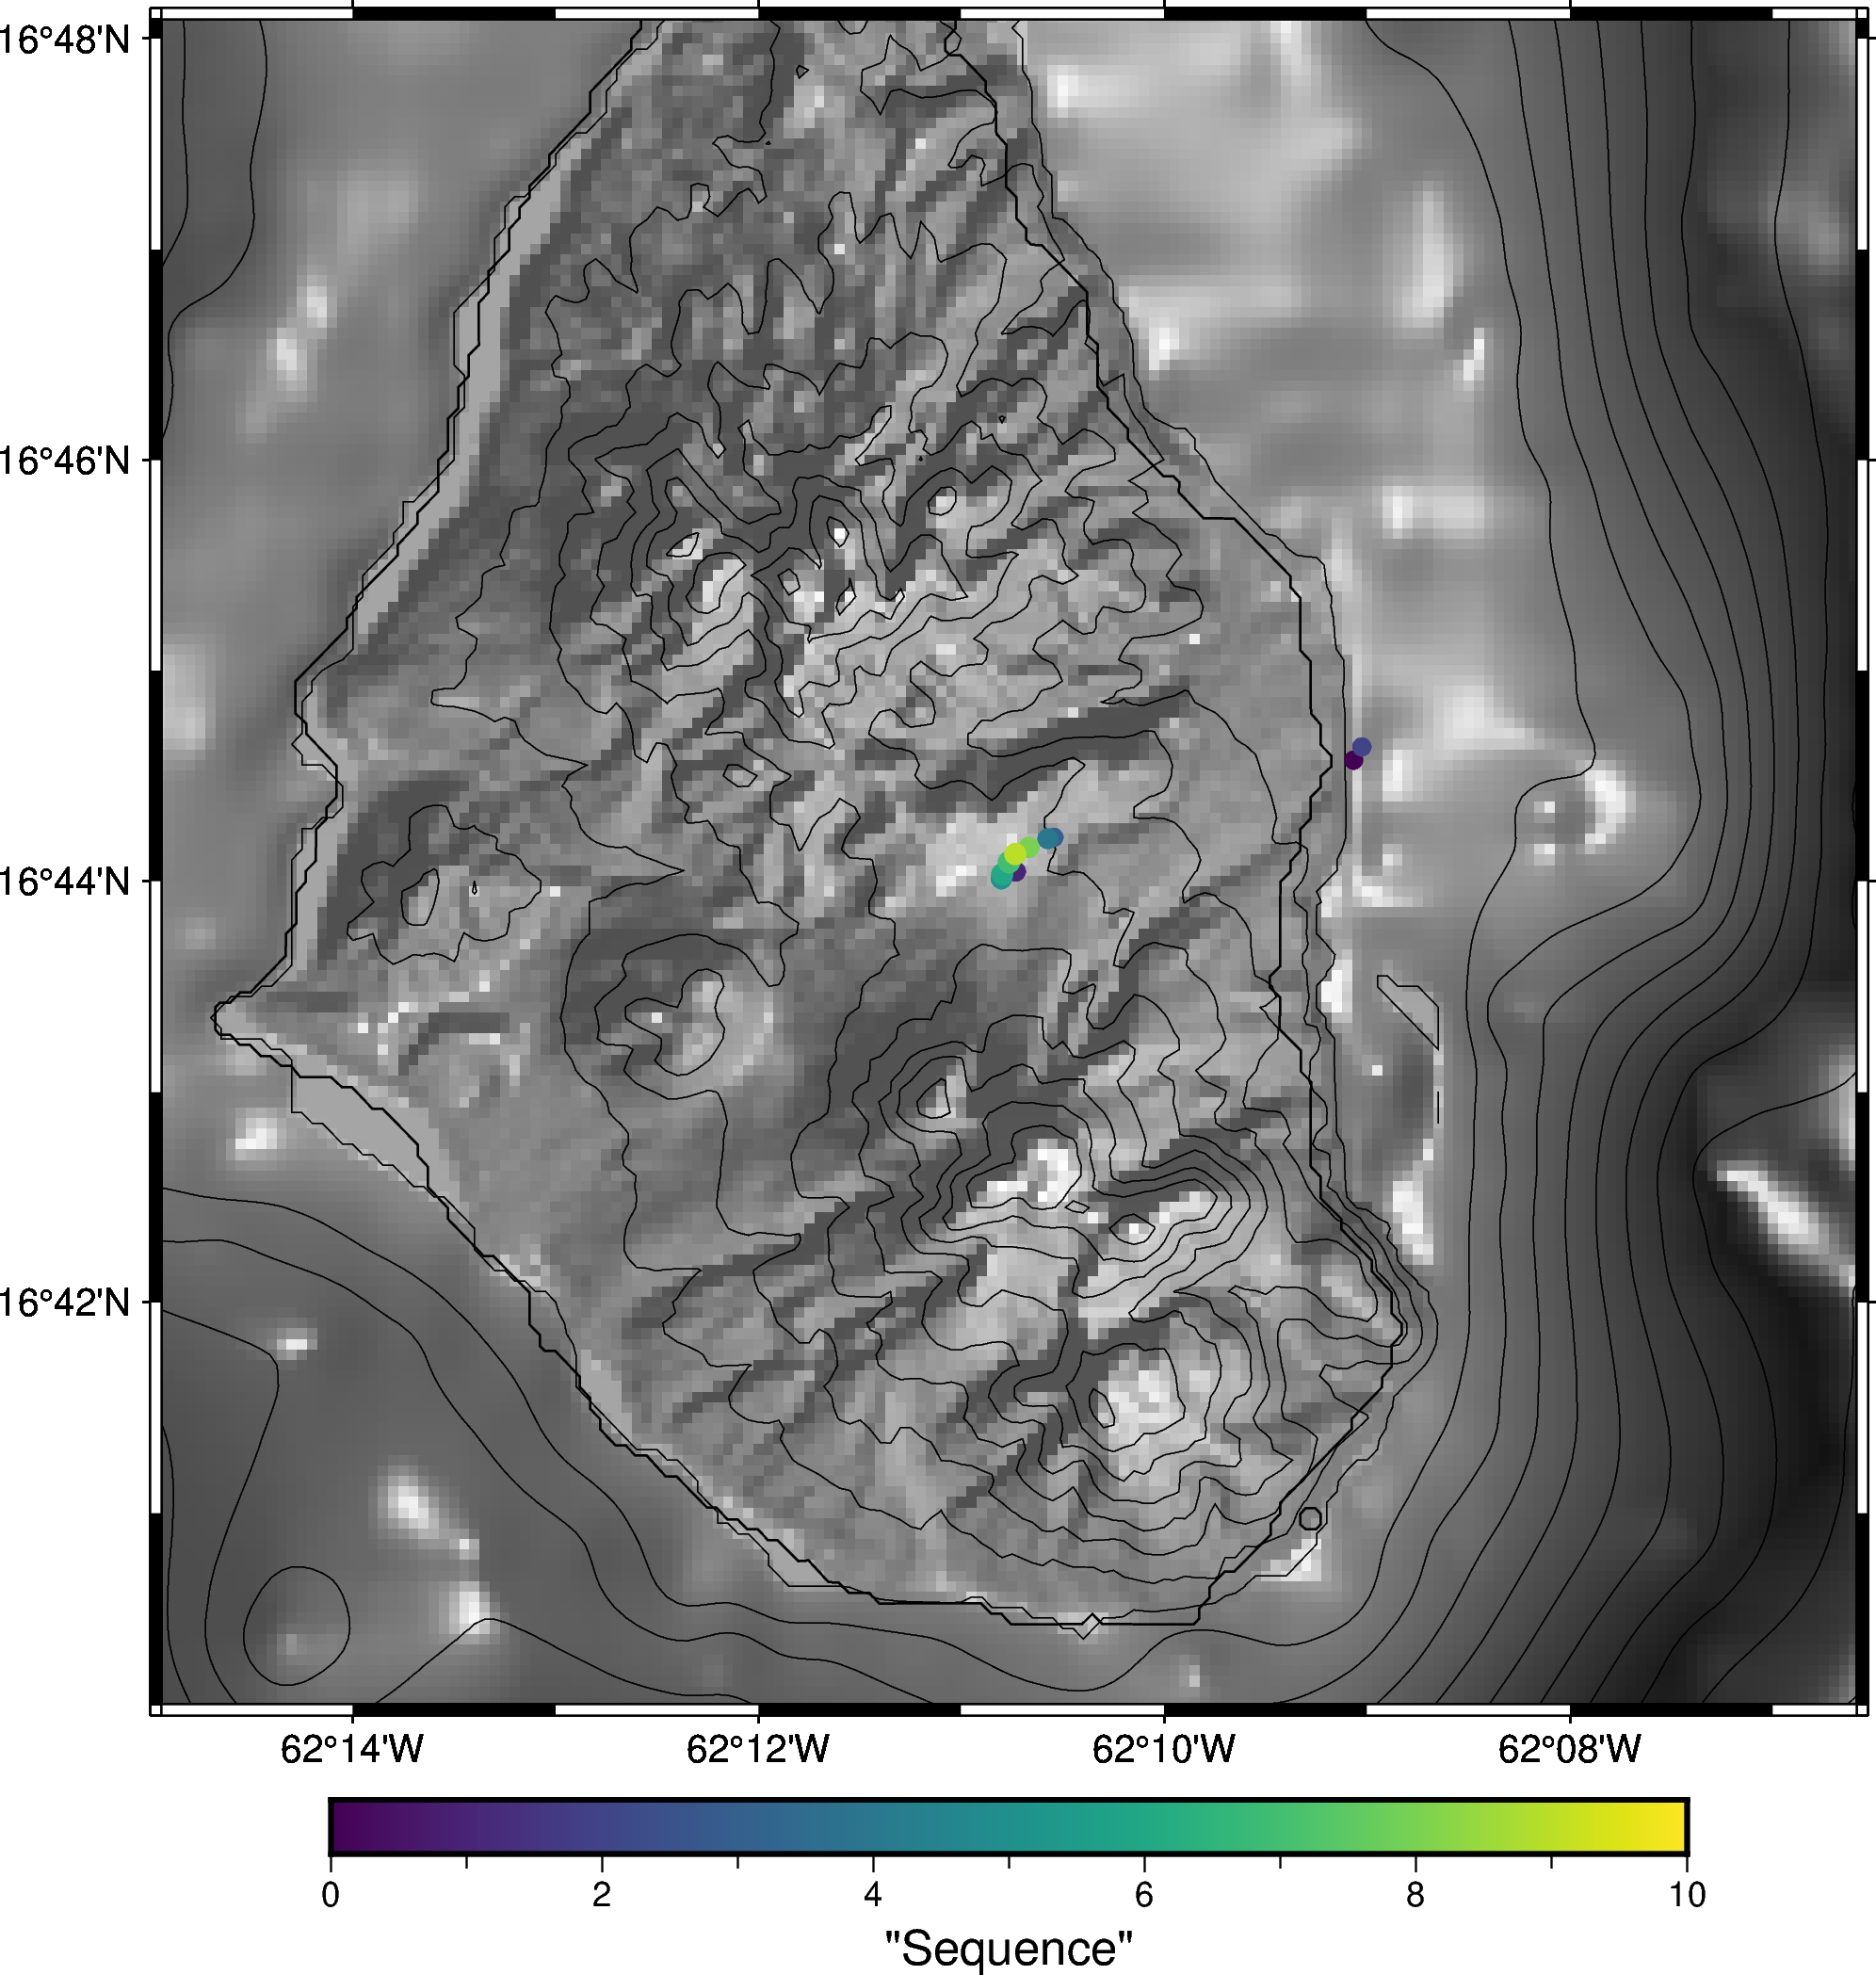

plot [WARNING]: - not a valid number and may not be decoded properly.


TypeError: ASL.refine_and_relocate() got an unexpected keyword argument 'spatial_smooth_sigma'

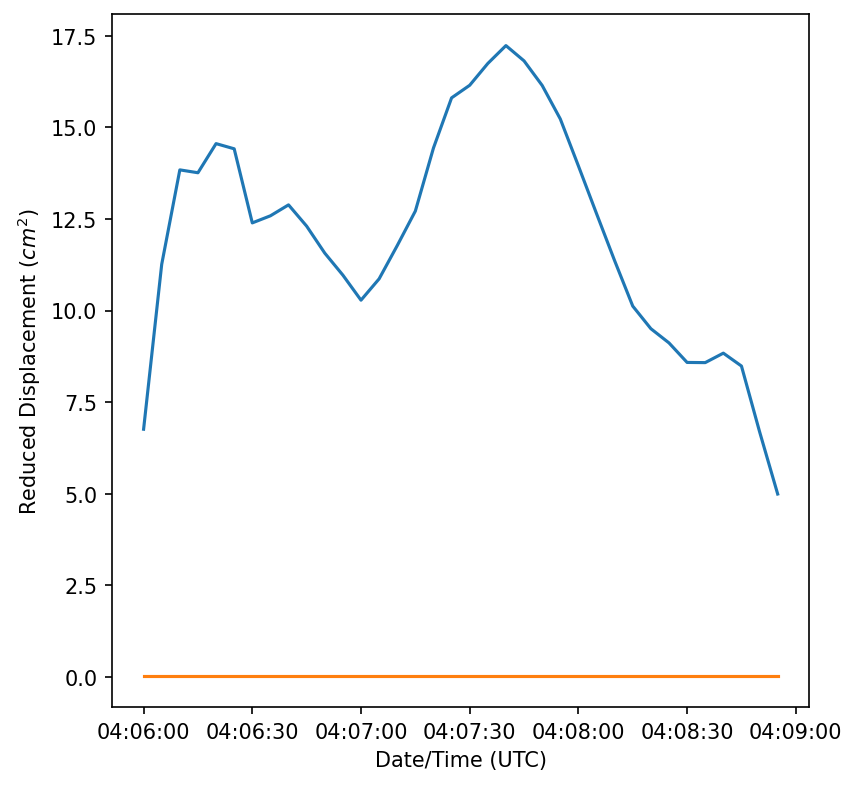

In [25]:
# Locate with spatial + temporal smoothing
#   - spatial_smooth_sigma=1.5 → Gaussian blur across grid nodes (favoring coherent patches)
#   - temporal_smooth_win=5    → 5-point moving average in time (smoother track)
aslobjpf.fast_locate(spatial_smooth_sigma=1.5, temporal_smooth_win=5, verbose=True)
aslobjpf.plot(zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, add_labels=False)

# Refine and relocate within a smaller sub-grid
#   - top_frac=0.25 → focus on top 25% of DR values
#   - margin_km=1.0 → expand bounding box by 1 km
#   - also applies the same spatial+temporal smoothing
aslobjpf.refine_and_relocate(top_frac=0.25, margin_km=1.0,
                             spatial_smooth_sigma=1.5,
                             temporal_smooth_win=5)
aslobjpf.plot(zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, add_labels=False)